In [1]:
from pylab import plt
import pandas as pd
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import datetime as dt
import scipy as sc
from pylab import mpl
import scipy.integrate as sci
import scipy.stats as scs
import pandas_datareader as web
import statsmodels.api as sm
import enum
import scipy.optimize as spo
from numpy.fft import *
from yahoo_fin import options
from dawp import *
from mystic.solvers import fmin, fmin_powell, diffev, diffev2, sparsity,lattice
import math
import sys
import yfinance as yf

sys.path.append('../')
sys.path.append('C:/Users/kiedy/dx')

np.set_printoptions(suppress=True, formatter={'all': lambda x: '%5.4f' % x})

In [2]:
options1=pd.DataFrame([43.10, 35.60, 22.90, 20.20, 13.30],
                     columns=['price'])
options1['strike']=(1090,1100,1120,1125,1140)
options1['maturity']=dt.datetime(2002,5,17)
options1['T']=0.088


options2=pd.DataFrame([84.50, 64.30, 39.50, 33.50, 30.70, 28.00,  25.60, 23.20,19.10,15.30,12.10,10.90],
                     columns=['price'])
options2['strike']=(1050,1075,1110,1120,1125,1130,1135,1140,1150,1160,1170,1175)
options2['maturity']=dt.datetime(2002,6,21)
options2['T']=0.184


options3=pd.DataFrame([161.60, 144.80, 120.10, 100.70, 82.50,65.50,51.00,45.50,38.10,27.70,19.60,13.20],
                     columns=['price'])
options3['strike']=(975,995,1025,1050,1075,1100,1125,1135,1150,1175,1200,1225)
options3['maturity']=dt.datetime(2002,9,20)
options3['T']=0.436



options4=pd.DataFrame([173.30,157.00,133.10,114.80,97.60,81.20,66.90,58.90,53.90,42.50,33.00,24.90,18.30,13.20],
                     columns=['price'])
options4['strike']=(975,995,1025,1050,1075,1100,1125,1140,1150,1175,1200,1225,1250,1275)
options4['maturity']=dt.datetime(2002,12,20)
options4['T']=0.692


options5=pd.DataFrame([146.50,96.20,81.70,68.30,56.60,46.10,36.90,29.30,22.50,17.20,12.80],
                     columns=['price'])
options5['strike']=(1025,1100,1125,1150,1175,1200,1225,1250,1275,1300,1325)
options5['maturity']=dt.datetime(2003,3,21)
options5['T']=0.936


options6=pd.DataFrame([182.10,143.00,111.30,97.00,83.30,60.90,49.80,41.20,27.10,17.10,10.10],
                     columns=['price'])
options6['strike']=(995,1050,1100,1125,1150,1200,1225,1250,1300,1350,1400)
options6['maturity']=dt.datetime(2003,6,20)
options6['T']=1.192

options7=pd.DataFrame([171.40,140.40,112.80,99.80,66.90,49.50,35.70,25.20,17.00,12.20],
                     columns=['price'])
options7['strike']=(1050,1100,1150,1175,1250,1300,1350,1400,1450,1500)
options7['maturity']=dt.datetime(2003,12,19)
options7['T']=1.708

frames=[options1, options2, options3, options4, options5, options6, options7]

options=pd.concat(frames, ignore_index=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


r=0.019
q=0.012
S0=1124.47
i = np.complex(0.0, 1.0)

In [3]:
def CIR(u,T,y0,kappa,eta, lamb):
    gamma=np.sqrt(kappa**2 - 2*lamb**2*1j*u)
    A=np.exp(kappa**2*eta*T/lamb**2)/(np.cosh(gamma*T/2)+kappa/gamma*np.sinh(gamma*T/2))**(2*kappa*eta/lamb**2)
    B=2*1j*u/(kappa+gamma*np.cosh(gamma*T/2)/np.sinh(gamma*T/2))
    return A*np.exp(B*y0) 

In [4]:
def Psi(u, T, r, C, G, M, Y):
    ''' Funkcja charakterystyczna w modelu CGMY '''
    value = (C*math.gamma(-Y)*((M-1j*u)**Y - M**Y + (G+1j*u)**Y - G**Y)) 
    return value

In [5]:
def cf(u, T, r, y0, C, G, M, Y,kappa,eta, lamb):
    return np.exp(u*1j*T*(r-q))*CIR(-1j*Psi(u, T, r, C, G, M, Y),T, y0, kappa,eta, lamb)/CIR(-1j*Psi(-1j, T, r, C,G,M,Y),T, y0, kappa,eta, lamb)**(1j*u)

In [6]:
def G_(u,*args):
    return np.log(np.exp(u*T*(r-q))*CIR(-1j*Psi(-1j*u, T, r, C, G, M, Y),T,1, kappa,eta, lamb)/CIR(-1j*Psi(-1j, T, r, C, G, M, Y),T, 1, kappa,eta, lamb)**(u))


T=1
C=1
G=2
M=5
kappa=1
eta=1
lamb=1
Y=1.4

In [7]:
# This class defines puts and calls

N=2**12
L=10
h=1e-3
y0=1
    
def CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,kappa, eta, lamb,N,L,CALL):
        
    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)
    
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    c1=(G_(h)-G_(-h))/(2*h)
    c2=(G_(h)-2*G_(0)+G_(-h))/(h**2)
    c4=(G_(3*h)-2*G_(2*h)+4*G_(0)-G_(h)-G_(-h)-2*G_(-2*h)+G_(-3*h))/(4*h**4)

    a=c1+x0-L*np.sqrt(c2+np.sqrt(c4))
    b=c1+x0+L*np.sqrt(c2+np.sqrt(c4))
#     Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u, T, r, y0, C, G, M, Y,kappa,eta, lamb) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * T) * K * np.real(mat.dot(temp))  
    if CALL == True:
         return np.exp(-q*T)*S0+ value - K*np.exp(-r*T)
    else:
        return value

def CallPutCoefficients(a,b,k):
    c = a
    d = 0.0
    coef = Chi_Psi(a,b,c,d,k)
    Chi_k = coef["chi"]
    Psi_k = coef["psi"]
    if a<b and b<0.0:
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k) 
    elif a>0 and a<b:
        H_k = np.zeros([len(k),1])
    else:
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)
    
    return H_k     

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [8]:
m=0
def CGMYSV_error_function(p0):
    
    global m
    C, G, M, Y, kappa, eta, lamb=p0
    se = []
    for row, option in options.iterrows():
        model_value = CallPutOptionPriceCOSMthd(cf,S0,r,option['T'],(option['strike'],),C, G, M, Y,kappa,eta,lamb,N,L,True)[0][0]
        se.append((model_value - option['price']) ** 2)
    RMSE = (sum(se) / len(se))**0.5
    if np.isnan(RMSE):
        RMSE=100
    if m % 1 == 0:
        print('%4d |' % m, np.array(p0), '| %7.3f' % RMSE)
        
    m += 1
    return RMSE

CGMYSV_error_function((0.0074, 0.1012, 11.3934, 1.6764, 0.3885, 1.4016, 1.3621))

   0 | [0.0074 0.1012 11.3934 1.6764 0.3885 1.4016 1.3621] |   0.438


0.4378025210240834

In [9]:
def CGMYSV_calibration_full():
    i=0
    global opt
    p0 = spo.brute(CGMYSV_error_function, ((0.001,0.11, 0.04),(0.1, 1, 0.2), (3.1,15,2),(0.2,1.99,0.5), (0.1,1.1,0.4),(1.0,2.0,0.4), (1.0,2.1,0.4)), finish=None)
    opt = spo.fmin(CGMYSV_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=15000, maxfun=15000)
    return opt

# Kalibracja dla wielu K

In [10]:
# This class defines puts and calls

N=2**12
L=10
h=1e-3
y0=1

# This class defines puts and calls
   
def CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,kappa, eta, lamb,N,L, CALL):
        
    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)
    
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    c1=(G_(h)-G_(-h))/(2*h)
    c2=(G_(h)-2*G_(0)+G_(-h))/(h**2)
    c4=(G_(3*h)-2*G_(2*h)+4*G_(0)-G_(h)-G_(-h)-2*G_(-2*h)+G_(-3*h))/(4*h**4)

    a=c1-L*np.sqrt(c2+np.sqrt(c4))
    b=c1+L*np.sqrt(c2+np.sqrt(c4))
#     Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u, T, r, y0, C, G, M, Y,kappa,eta, lamb) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * T) * K * np.real(mat.dot(temp))     
    return np.exp(-q*T)*S0+ value - K*np.exp(-r*T)

# Determine coefficients for put prices 

def CallPutCoefficients(a,b,k):
    c = a
    d = 0.0
    coef = Chi_Psi(a,b,c,d,k)
    Chi_k = coef["chi"]
    Psi_k = coef["psi"]
    if a<b and b<0.0:
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k) 
    elif a>0 and a<b:
        H_k = np.zeros([len(k),1])
    else:
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [11]:
m=0
def CGMYSV_error_function(p0):
    
    global m
    C, G, M, Y, kappa,eta,lamb=p0
#     if sigma<=0:
#         return 100
    se1 = []
    K = np.array(options1['strike'])
    T=options['T'][0]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,N,L,True)
    i=0
    for row, option in options1.iterrows():
        se1.append((model_value[i] - option['price']) ** 2)
        i+=1
        
        
    se2 = []
    K = np.array(options2['strike'])
    T=options['T'][10]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y, kappa,eta,lamb,N,L,True)
    i=0
    for row, option in options2.iterrows():
        se2.append((model_value[i] - option['price']) ** 2)
        i+=1
        
        
    se3 = []    
    K = np.array(options3['strike'])
    T=options['T'][18]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,N,L,True)
    i=0
    for row, option in options3.iterrows():
        se3.append((model_value[i] - option['price']) ** 2)
        i+=1        
        
        
    se4 = []    
    K = np.array(options4['strike'])
    T=options['T'][37]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y, kappa,eta,lamb,N,L,True)
    i=0
    for row, option in options4.iterrows():
        se4.append((model_value[i] - option['price']) ** 2)
        i+=1        

    se5 = []    
    K = np.array(options5['strike'])
    T=options['T'][48]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,N,L,True)
    i=0
    for row, option in options5.iterrows():
        se5.append((model_value[i] - option['price']) ** 2)
        i+=1 
        
    se6 = []    
    K = np.array(options6['strike'])
    T=options['T'][58]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,N,L,True)
    i=0
    for row, option in options6.iterrows():
        se6.append((model_value[i] - option['price']) ** 2)
        i+=1
        
        
    se7 = []    
    K = np.array(options7['strike'])
    T=options['T'][69]
    model_value=CallPutOptionPriceCOSMthd(cf,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,N,L,True)
    i=0
    for row, option in options7.iterrows():
        se7.append((model_value[i] - option['price']) ** 2)
        i+=1
        
    RMSE = ((sum(se1)+sum(se2)+sum(se3)+sum(se4)+sum(se5)+sum(se6)+sum(se7)) / (len(se1)+len(se2)+len(se3)+len(se4)+len(se5)+len(se6)+len(se7)))**0.5
    if np.isnan(RMSE):
        RMSE=100
    if m % 1 == 0:
        print('%4d |' % m, np.array(p0), '| %7.3f' % RMSE)
        
    m += 1
    return RMSE

CGMYSV_error_function((0.0074, 0.1012, 11.3934, 1.6764, 0.3885, 1.4016, 1.3621)) #regime...

%time CGMYSV_calibration_full()

   0 | [0.0074 0.1012 11.3934 1.6764 0.3885 1.4016 1.3621] |   0.438
   1 | [0.0010 0.1000 3.1000 0.2000 0.1000 1.0000 1.0000] |  43.820
   2 | [0.0010 0.1000 3.1000 0.2000 0.1000 1.0000 1.4000] |  43.821
   3 | [0.0010 0.1000 3.1000 0.2000 0.1000 1.0000 1.8000] |  43.821
   4 | [0.0010 0.1000 3.1000 0.2000 0.1000 1.4000 1.0000] |  43.801
   5 | [0.0010 0.1000 3.1000 0.2000 0.1000 1.4000 1.4000] |  43.802
   6 | [0.0010 0.1000 3.1000 0.2000 0.1000 1.4000 1.8000] |  43.803
   7 | [0.0010 0.1000 3.1000 0.2000 0.1000 1.8000 1.0000] |  43.782
   8 | [0.0010 0.1000 3.1000 0.2000 0.1000 1.8000 1.4000] |  43.783
   9 | [0.0010 0.1000 3.1000 0.2000 0.1000 1.8000 1.8000] |  43.784
  10 | [0.0010 0.1000 3.1000 0.2000 0.5000 1.0000 1.0000] |  43.820
  11 | [0.0010 0.1000 3.1000 0.2000 0.5000 1.0000 1.4000] |  43.820
  12 | [0.0010 0.1000 3.1000 0.2000 0.5000 1.0000 1.8000] |  43.821
  13 | [0.0010 0.1000 3.1000 0.2000 0.5000 1.4000 1.0000] |  43.740
  14 | [0.0010 0.1000 3.1000 0.2000 0.5000 1.40

 122 | [0.0010 0.1000 5.1000 0.2000 0.5000 1.4000 1.4000] |  43.836
 123 | [0.0010 0.1000 5.1000 0.2000 0.5000 1.4000 1.8000] |  43.837
 124 | [0.0010 0.1000 5.1000 0.2000 0.5000 1.8000 1.0000] |  43.764
 125 | [0.0010 0.1000 5.1000 0.2000 0.5000 1.8000 1.4000] |  43.765
 126 | [0.0010 0.1000 5.1000 0.2000 0.5000 1.8000 1.8000] |  43.765
 127 | [0.0010 0.1000 5.1000 0.2000 0.9000 1.0000 1.0000] |  43.907
 128 | [0.0010 0.1000 5.1000 0.2000 0.9000 1.0000 1.4000] |  43.907
 129 | [0.0010 0.1000 5.1000 0.2000 0.9000 1.0000 1.8000] |  43.908
 130 | [0.0010 0.1000 5.1000 0.2000 0.9000 1.4000 1.0000] |  43.796
 131 | [0.0010 0.1000 5.1000 0.2000 0.9000 1.4000 1.4000] |  43.796
 132 | [0.0010 0.1000 5.1000 0.2000 0.9000 1.4000 1.8000] |  43.796
 133 | [0.0010 0.1000 5.1000 0.2000 0.9000 1.8000 1.0000] |  43.684
 134 | [0.0010 0.1000 5.1000 0.2000 0.9000 1.8000 1.4000] |  43.685
 135 | [0.0010 0.1000 5.1000 0.2000 0.9000 1.8000 1.8000] |  43.685
 136 | [0.0010 0.1000 5.1000 0.7000 0.1000 1.000

 243 | [0.0010 0.1000 7.1000 0.2000 0.9000 1.8000 1.8000] |  43.728
 244 | [0.0010 0.1000 7.1000 0.7000 0.1000 1.0000 1.0000] |  43.806
 245 | [0.0010 0.1000 7.1000 0.7000 0.1000 1.0000 1.4000] |  43.807
 246 | [0.0010 0.1000 7.1000 0.7000 0.1000 1.0000 1.8000] |  43.808
 247 | [0.0010 0.1000 7.1000 0.7000 0.1000 1.4000 1.0000] |  43.787
 248 | [0.0010 0.1000 7.1000 0.7000 0.1000 1.4000 1.4000] |  43.788
 249 | [0.0010 0.1000 7.1000 0.7000 0.1000 1.4000 1.8000] |  43.789
 250 | [0.0010 0.1000 7.1000 0.7000 0.1000 1.8000 1.0000] |  43.767
 251 | [0.0010 0.1000 7.1000 0.7000 0.1000 1.8000 1.4000] |  43.769
 252 | [0.0010 0.1000 7.1000 0.7000 0.1000 1.8000 1.8000] |  43.770
 253 | [0.0010 0.1000 7.1000 0.7000 0.5000 1.0000 1.0000] |  43.805
 254 | [0.0010 0.1000 7.1000 0.7000 0.5000 1.0000 1.4000] |  43.806
 255 | [0.0010 0.1000 7.1000 0.7000 0.5000 1.0000 1.8000] |  43.807
 256 | [0.0010 0.1000 7.1000 0.7000 0.5000 1.4000 1.0000] |  43.724
 257 | [0.0010 0.1000 7.1000 0.7000 0.5000 1.400

 366 | [0.0010 0.1000 9.1000 0.7000 0.5000 1.4000 1.8000] |  43.766
 367 | [0.0010 0.1000 9.1000 0.7000 0.5000 1.8000 1.0000] |  43.685
 368 | [0.0010 0.1000 9.1000 0.7000 0.5000 1.8000 1.4000] |  43.686
 369 | [0.0010 0.1000 9.1000 0.7000 0.5000 1.8000 1.8000] |  43.687
 370 | [0.0010 0.1000 9.1000 0.7000 0.9000 1.0000 1.0000] |  43.842
 371 | [0.0010 0.1000 9.1000 0.7000 0.9000 1.0000 1.4000] |  43.842
 372 | [0.0010 0.1000 9.1000 0.7000 0.9000 1.0000 1.8000] |  43.843
 373 | [0.0010 0.1000 9.1000 0.7000 0.9000 1.4000 1.0000] |  43.720
 374 | [0.0010 0.1000 9.1000 0.7000 0.9000 1.4000 1.4000] |  43.721
 375 | [0.0010 0.1000 9.1000 0.7000 0.9000 1.4000 1.8000] |  43.721
 376 | [0.0010 0.1000 9.1000 0.7000 0.9000 1.8000 1.0000] |  43.598
 377 | [0.0010 0.1000 9.1000 0.7000 0.9000 1.8000 1.4000] |  43.598
 378 | [0.0010 0.1000 9.1000 0.7000 0.9000 1.8000 1.8000] |  43.599
 379 | [0.0010 0.1000 9.1000 1.2000 0.1000 1.0000 1.0000] |  42.855
 380 | [0.0010 0.1000 9.1000 1.2000 0.1000 1.000

 488 | [0.0010 0.1000 11.1000 1.2000 0.1000 1.0000 1.4000] |  42.928
 489 | [0.0010 0.1000 11.1000 1.2000 0.1000 1.0000 1.8000] |  42.942
 490 | [0.0010 0.1000 11.1000 1.2000 0.1000 1.4000 1.0000] |  42.876
 491 | [0.0010 0.1000 11.1000 1.2000 0.1000 1.4000 1.4000] |  42.889
 492 | [0.0010 0.1000 11.1000 1.2000 0.1000 1.4000 1.8000] |  42.903
 493 | [0.0010 0.1000 11.1000 1.2000 0.1000 1.8000 1.0000] |  42.837
 494 | [0.0010 0.1000 11.1000 1.2000 0.1000 1.8000 1.4000] |  42.849
 495 | [0.0010 0.1000 11.1000 1.2000 0.1000 1.8000 1.8000] |  42.864
 496 | [0.0010 0.1000 11.1000 1.2000 0.5000 1.0000 1.0000] |  42.911
 497 | [0.0010 0.1000 11.1000 1.2000 0.5000 1.0000 1.4000] |  42.919
 498 | [0.0010 0.1000 11.1000 1.2000 0.5000 1.0000 1.8000] |  42.929
 499 | [0.0010 0.1000 11.1000 1.2000 0.5000 1.4000 1.0000] |  42.743
 500 | [0.0010 0.1000 11.1000 1.2000 0.5000 1.4000 1.4000] |  42.752
 501 | [0.0010 0.1000 11.1000 1.2000 0.5000 1.4000 1.8000] |  42.763
 502 | [0.0010 0.1000 11.1000 1.20

 607 | [0.0010 0.1000 13.1000 1.2000 0.5000 1.4000 1.0000] |  42.793
 608 | [0.0010 0.1000 13.1000 1.2000 0.5000 1.4000 1.4000] |  42.801
 609 | [0.0010 0.1000 13.1000 1.2000 0.5000 1.4000 1.8000] |  42.810
 610 | [0.0010 0.1000 13.1000 1.2000 0.5000 1.8000 1.0000] |  42.629
 611 | [0.0010 0.1000 13.1000 1.2000 0.5000 1.8000 1.4000] |  42.637
 612 | [0.0010 0.1000 13.1000 1.2000 0.5000 1.8000 1.8000] |  42.647
 613 | [0.0010 0.1000 13.1000 1.2000 0.9000 1.0000 1.0000] |  42.954
 614 | [0.0010 0.1000 13.1000 1.2000 0.9000 1.0000 1.4000] |  42.959
 615 | [0.0010 0.1000 13.1000 1.2000 0.9000 1.0000 1.8000] |  42.966
 616 | [0.0010 0.1000 13.1000 1.2000 0.9000 1.4000 1.0000] |  42.699
 617 | [0.0010 0.1000 13.1000 1.2000 0.9000 1.4000 1.4000] |  42.705
 618 | [0.0010 0.1000 13.1000 1.2000 0.9000 1.4000 1.8000] |  42.713
 619 | [0.0010 0.1000 13.1000 1.2000 0.9000 1.8000 1.0000] |  42.445
 620 | [0.0010 0.1000 13.1000 1.2000 0.9000 1.8000 1.4000] |  42.451
 621 | [0.0010 0.1000 13.1000 1.20

 727 | [0.0010 0.3000 3.1000 1.2000 0.9000 1.8000 1.0000] |  41.898
 728 | [0.0010 0.3000 3.1000 1.2000 0.9000 1.8000 1.4000] |  41.908
 729 | [0.0010 0.3000 3.1000 1.2000 0.9000 1.8000 1.8000] |  41.920
 730 | [0.0010 0.3000 3.1000 1.7000 0.1000 1.0000 1.0000] |  35.655
 731 | [0.0010 0.3000 3.1000 1.7000 0.1000 1.0000 1.4000] |  35.875
 732 | [0.0010 0.3000 3.1000 1.7000 0.1000 1.0000 1.8000] |  36.131
 733 | [0.0010 0.3000 3.1000 1.7000 0.1000 1.4000 1.0000] |  35.482
 734 | [0.0010 0.3000 3.1000 1.7000 0.1000 1.4000 1.4000] |  35.701
 735 | [0.0010 0.3000 3.1000 1.7000 0.1000 1.4000 1.8000] |  35.957
 736 | [0.0010 0.3000 3.1000 1.7000 0.1000 1.8000 1.0000] |  35.311
 737 | [0.0010 0.3000 3.1000 1.7000 0.1000 1.8000 1.4000] |  35.529
 738 | [0.0010 0.3000 3.1000 1.7000 0.1000 1.8000 1.8000] |  35.784
 739 | [0.0010 0.3000 3.1000 1.7000 0.5000 1.0000 1.0000] |  35.577
 740 | [0.0010 0.3000 3.1000 1.7000 0.5000 1.0000 1.4000] |  35.734
 741 | [0.0010 0.3000 3.1000 1.7000 0.5000 1.000

 848 | [0.0010 0.3000 5.1000 1.7000 0.5000 1.0000 1.4000] |  36.130
 849 | [0.0010 0.3000 5.1000 1.7000 0.5000 1.0000 1.8000] |  36.301
 850 | [0.0010 0.3000 5.1000 1.7000 0.5000 1.4000 1.0000] |  35.300
 851 | [0.0010 0.3000 5.1000 1.7000 0.5000 1.4000 1.4000] |  35.439
 852 | [0.0010 0.3000 5.1000 1.7000 0.5000 1.4000 1.8000] |  35.608
 853 | [0.0010 0.3000 5.1000 1.7000 0.5000 1.8000 1.0000] |  34.626
 854 | [0.0010 0.3000 5.1000 1.7000 0.5000 1.8000 1.4000] |  34.764
 855 | [0.0010 0.3000 5.1000 1.7000 0.5000 1.8000 1.8000] |  34.931
 856 | [0.0010 0.3000 5.1000 1.7000 0.9000 1.0000 1.0000] |  35.945
 857 | [0.0010 0.3000 5.1000 1.7000 0.9000 1.0000 1.4000] |  36.051
 858 | [0.0010 0.3000 5.1000 1.7000 0.9000 1.0000 1.8000] |  36.181
 859 | [0.0010 0.3000 5.1000 1.7000 0.9000 1.4000 1.0000] |  34.883
 860 | [0.0010 0.3000 5.1000 1.7000 0.9000 1.4000 1.4000] |  34.987
 861 | [0.0010 0.3000 5.1000 1.7000 0.9000 1.4000 1.8000] |  35.116
 862 | [0.0010 0.3000 5.1000 1.7000 0.9000 1.800

 971 | [0.0010 0.3000 7.1000 1.7000 0.9000 1.8000 1.4000] |  34.257
 972 | [0.0010 0.3000 7.1000 1.7000 0.9000 1.8000 1.8000] |  34.361
 973 | [0.0010 0.3000 9.1000 0.2000 0.1000 1.0000 1.0000] |  44.189
 974 | [0.0010 0.3000 9.1000 0.2000 0.1000 1.0000 1.4000] |  44.189
 975 | [0.0010 0.3000 9.1000 0.2000 0.1000 1.0000 1.8000] |  44.189
 976 | [0.0010 0.3000 9.1000 0.2000 0.1000 1.4000 1.0000] |  44.178
 977 | [0.0010 0.3000 9.1000 0.2000 0.1000 1.4000 1.4000] |  44.178
 978 | [0.0010 0.3000 9.1000 0.2000 0.1000 1.4000 1.8000] |  44.179
 979 | [0.0010 0.3000 9.1000 0.2000 0.1000 1.8000 1.0000] |  44.168
 980 | [0.0010 0.3000 9.1000 0.2000 0.1000 1.8000 1.4000] |  44.168
 981 | [0.0010 0.3000 9.1000 0.2000 0.1000 1.8000 1.8000] |  44.168
 982 | [0.0010 0.3000 9.1000 0.2000 0.5000 1.0000 1.0000] |  44.189
 983 | [0.0010 0.3000 9.1000 0.2000 0.5000 1.0000 1.4000] |  44.189
 984 | [0.0010 0.3000 9.1000 0.2000 0.5000 1.0000 1.8000] |  44.189
 985 | [0.0010 0.3000 9.1000 0.2000 0.5000 1.400

1092 | [0.0010 0.3000 11.1000 0.2000 0.5000 1.0000 1.8000] |  44.199
1093 | [0.0010 0.3000 11.1000 0.2000 0.5000 1.4000 1.0000] |  44.155
1094 | [0.0010 0.3000 11.1000 0.2000 0.5000 1.4000 1.4000] |  44.155
1095 | [0.0010 0.3000 11.1000 0.2000 0.5000 1.4000 1.8000] |  44.155
1096 | [0.0010 0.3000 11.1000 0.2000 0.5000 1.8000 1.0000] |  44.111
1097 | [0.0010 0.3000 11.1000 0.2000 0.5000 1.8000 1.4000] |  44.111
1098 | [0.0010 0.3000 11.1000 0.2000 0.5000 1.8000 1.8000] |  44.112
1099 | [0.0010 0.3000 11.1000 0.2000 0.9000 1.0000 1.0000] |  44.199
1100 | [0.0010 0.3000 11.1000 0.2000 0.9000 1.0000 1.4000] |  44.199
1101 | [0.0010 0.3000 11.1000 0.2000 0.9000 1.0000 1.8000] |  44.199
1102 | [0.0010 0.3000 11.1000 0.2000 0.9000 1.4000 1.0000] |  44.130
1103 | [0.0010 0.3000 11.1000 0.2000 0.9000 1.4000 1.4000] |  44.131
1104 | [0.0010 0.3000 11.1000 0.2000 0.9000 1.4000 1.8000] |  44.131
1105 | [0.0010 0.3000 11.1000 0.2000 0.9000 1.8000 1.0000] |  44.062
1106 | [0.0010 0.3000 11.1000 0.20

1211 | [0.0010 0.3000 13.1000 0.2000 0.9000 1.4000 1.4000] |  44.138
1212 | [0.0010 0.3000 13.1000 0.2000 0.9000 1.4000 1.8000] |  44.138
1213 | [0.0010 0.3000 13.1000 0.2000 0.9000 1.8000 1.0000] |  44.071
1214 | [0.0010 0.3000 13.1000 0.2000 0.9000 1.8000 1.4000] |  44.071
1215 | [0.0010 0.3000 13.1000 0.2000 0.9000 1.8000 1.8000] |  44.071
1216 | [0.0010 0.3000 13.1000 0.7000 0.1000 1.0000 1.0000] |  44.020
1217 | [0.0010 0.3000 13.1000 0.7000 0.1000 1.0000 1.4000] |  44.020
1218 | [0.0010 0.3000 13.1000 0.7000 0.1000 1.0000 1.8000] |  44.021
1219 | [0.0010 0.3000 13.1000 0.7000 0.1000 1.4000 1.0000] |  44.005
1220 | [0.0010 0.3000 13.1000 0.7000 0.1000 1.4000 1.4000] |  44.006
1221 | [0.0010 0.3000 13.1000 0.7000 0.1000 1.4000 1.8000] |  44.007
1222 | [0.0010 0.3000 13.1000 0.7000 0.1000 1.8000 1.0000] |  43.991
1223 | [0.0010 0.3000 13.1000 0.7000 0.1000 1.8000 1.4000] |  43.992
1224 | [0.0010 0.3000 13.1000 0.7000 0.1000 1.8000 1.8000] |  43.992
1225 | [0.0010 0.3000 13.1000 0.70

1331 | [0.0010 0.5000 3.1000 0.7000 0.1000 1.8000 1.4000] |  43.790
1332 | [0.0010 0.5000 3.1000 0.7000 0.1000 1.8000 1.8000] |  43.791
1333 | [0.0010 0.5000 3.1000 0.7000 0.5000 1.0000 1.0000] |  43.825
1334 | [0.0010 0.5000 3.1000 0.7000 0.5000 1.0000 1.4000] |  43.826
1335 | [0.0010 0.5000 3.1000 0.7000 0.5000 1.0000 1.8000] |  43.827
1336 | [0.0010 0.5000 3.1000 0.7000 0.5000 1.4000 1.0000] |  43.746
1337 | [0.0010 0.5000 3.1000 0.7000 0.5000 1.4000 1.4000] |  43.746
1338 | [0.0010 0.5000 3.1000 0.7000 0.5000 1.4000 1.8000] |  43.748
1339 | [0.0010 0.5000 3.1000 0.7000 0.5000 1.8000 1.0000] |  43.666
1340 | [0.0010 0.5000 3.1000 0.7000 0.5000 1.8000 1.4000] |  43.667
1341 | [0.0010 0.5000 3.1000 0.7000 0.5000 1.8000 1.8000] |  43.668
1342 | [0.0010 0.5000 3.1000 0.7000 0.9000 1.0000 1.0000] |  43.825
1343 | [0.0010 0.5000 3.1000 0.7000 0.9000 1.0000 1.4000] |  43.826
1344 | [0.0010 0.5000 3.1000 0.7000 0.9000 1.0000 1.8000] |  43.827
1345 | [0.0010 0.5000 3.1000 0.7000 0.9000 1.400

1452 | [0.0010 0.5000 5.1000 0.7000 0.9000 1.0000 1.8000] |  43.960
1453 | [0.0010 0.5000 5.1000 0.7000 0.9000 1.4000 1.0000] |  43.855
1454 | [0.0010 0.5000 5.1000 0.7000 0.9000 1.4000 1.4000] |  43.855
1455 | [0.0010 0.5000 5.1000 0.7000 0.9000 1.4000 1.8000] |  43.856
1456 | [0.0010 0.5000 5.1000 0.7000 0.9000 1.8000 1.0000] |  43.751
1457 | [0.0010 0.5000 5.1000 0.7000 0.9000 1.8000 1.4000] |  43.751
1458 | [0.0010 0.5000 5.1000 0.7000 0.9000 1.8000 1.8000] |  43.752
1459 | [0.0010 0.5000 5.1000 1.2000 0.1000 1.0000 1.0000] |  42.836
1460 | [0.0010 0.5000 5.1000 1.2000 0.1000 1.0000 1.4000] |  42.850
1461 | [0.0010 0.5000 5.1000 1.2000 0.1000 1.0000 1.8000] |  42.867
1462 | [0.0010 0.5000 5.1000 1.2000 0.1000 1.4000 1.0000] |  42.796
1463 | [0.0010 0.5000 5.1000 1.2000 0.1000 1.4000 1.4000] |  42.810
1464 | [0.0010 0.5000 5.1000 1.2000 0.1000 1.4000 1.8000] |  42.828
1465 | [0.0010 0.5000 5.1000 1.2000 0.1000 1.8000 1.0000] |  42.756
1466 | [0.0010 0.5000 5.1000 1.2000 0.1000 1.800

1574 | [0.0010 0.5000 7.1000 1.2000 0.1000 1.8000 1.4000] |  42.903
1575 | [0.0010 0.5000 7.1000 1.2000 0.1000 1.8000 1.8000] |  42.920
1576 | [0.0010 0.5000 7.1000 1.2000 0.5000 1.0000 1.0000] |  42.960
1577 | [0.0010 0.5000 7.1000 1.2000 0.5000 1.0000 1.4000] |  42.969
1578 | [0.0010 0.5000 7.1000 1.2000 0.5000 1.0000 1.8000] |  42.981
1579 | [0.0010 0.5000 7.1000 1.2000 0.5000 1.4000 1.0000] |  42.800
1580 | [0.0010 0.5000 7.1000 1.2000 0.5000 1.4000 1.4000] |  42.810
1581 | [0.0010 0.5000 7.1000 1.2000 0.5000 1.4000 1.8000] |  42.822
1582 | [0.0010 0.5000 7.1000 1.2000 0.5000 1.8000 1.0000] |  42.641
1583 | [0.0010 0.5000 7.1000 1.2000 0.5000 1.8000 1.4000] |  42.651
1584 | [0.0010 0.5000 7.1000 1.2000 0.5000 1.8000 1.8000] |  42.664
1585 | [0.0010 0.5000 7.1000 1.2000 0.9000 1.0000 1.0000] |  42.957
1586 | [0.0010 0.5000 7.1000 1.2000 0.9000 1.0000 1.4000] |  42.964
1587 | [0.0010 0.5000 7.1000 1.2000 0.9000 1.0000 1.8000] |  42.972
1588 | [0.0010 0.5000 7.1000 1.2000 0.9000 1.400

1696 | [0.0010 0.5000 9.1000 1.2000 0.9000 1.4000 1.0000] |  42.805
1697 | [0.0010 0.5000 9.1000 1.2000 0.9000 1.4000 1.4000] |  42.812
1698 | [0.0010 0.5000 9.1000 1.2000 0.9000 1.4000 1.8000] |  42.820
1699 | [0.0010 0.5000 9.1000 1.2000 0.9000 1.8000 1.0000] |  42.568
1700 | [0.0010 0.5000 9.1000 1.2000 0.9000 1.8000 1.4000] |  42.576
1701 | [0.0010 0.5000 9.1000 1.2000 0.9000 1.8000 1.8000] |  42.585
1702 | [0.0010 0.5000 9.1000 1.7000 0.1000 1.0000 1.0000] |  36.555
1703 | [0.0010 0.5000 9.1000 1.7000 0.1000 1.0000 1.4000] |  36.682
1704 | [0.0010 0.5000 9.1000 1.7000 0.1000 1.0000 1.8000] |  36.834
1705 | [0.0010 0.5000 9.1000 1.7000 0.1000 1.4000 1.0000] |  36.401
1706 | [0.0010 0.5000 9.1000 1.7000 0.1000 1.4000 1.4000] |  36.526
1707 | [0.0010 0.5000 9.1000 1.7000 0.1000 1.4000 1.8000] |  36.676
1708 | [0.0010 0.5000 9.1000 1.7000 0.1000 1.8000 1.0000] |  36.248
1709 | [0.0010 0.5000 9.1000 1.7000 0.1000 1.8000 1.4000] |  36.371
1710 | [0.0010 0.5000 9.1000 1.7000 0.1000 1.800

1817 | [0.0010 0.5000 11.1000 1.7000 0.1000 1.8000 1.4000] |  36.421
1818 | [0.0010 0.5000 11.1000 1.7000 0.1000 1.8000 1.8000] |  36.514
1819 | [0.0010 0.5000 11.1000 1.7000 0.5000 1.0000 1.0000] |  36.629
1820 | [0.0010 0.5000 11.1000 1.7000 0.5000 1.0000 1.4000] |  36.685
1821 | [0.0010 0.5000 11.1000 1.7000 0.5000 1.0000 1.8000] |  36.756
1822 | [0.0010 0.5000 11.1000 1.7000 0.5000 1.4000 1.0000] |  35.995
1823 | [0.0010 0.5000 11.1000 1.7000 0.5000 1.4000 1.4000] |  36.045
1824 | [0.0010 0.5000 11.1000 1.7000 0.5000 1.4000 1.8000] |  36.109
1825 | [0.0010 0.5000 11.1000 1.7000 0.5000 1.8000 1.0000] |  35.376
1826 | [0.0010 0.5000 11.1000 1.7000 0.5000 1.8000 1.4000] |  35.420
1827 | [0.0010 0.5000 11.1000 1.7000 0.5000 1.8000 1.8000] |  35.477
1828 | [0.0010 0.5000 11.1000 1.7000 0.9000 1.0000 1.0000] |  36.614
1829 | [0.0010 0.5000 11.1000 1.7000 0.9000 1.0000 1.4000] |  36.657
1830 | [0.0010 0.5000 11.1000 1.7000 0.9000 1.0000 1.8000] |  36.711
1831 | [0.0010 0.5000 11.1000 1.70

1936 | [0.0010 0.5000 13.1000 1.7000 0.9000 1.0000 1.0000] |  36.707
1937 | [0.0010 0.5000 13.1000 1.7000 0.9000 1.0000 1.4000] |  36.720
1938 | [0.0010 0.5000 13.1000 1.7000 0.9000 1.0000 1.8000] |  36.740
1939 | [0.0010 0.5000 13.1000 1.7000 0.9000 1.4000 1.0000] |  35.743
1940 | [0.0010 0.5000 13.1000 1.7000 0.9000 1.4000 1.4000] |  35.747
1941 | [0.0010 0.5000 13.1000 1.7000 0.9000 1.4000 1.8000] |  35.757
1942 | [0.0010 0.5000 13.1000 1.7000 0.9000 1.8000 1.0000] |  34.807
1943 | [0.0010 0.5000 13.1000 1.7000 0.9000 1.8000 1.4000] |  34.804
1944 | [0.0010 0.5000 13.1000 1.7000 0.9000 1.8000 1.8000] |  34.803
1945 | [0.0010 0.7000 3.1000 0.2000 0.1000 1.0000 1.0000] |  44.217
1946 | [0.0010 0.7000 3.1000 0.2000 0.1000 1.0000 1.4000] |  44.217
1947 | [0.0010 0.7000 3.1000 0.2000 0.1000 1.0000 1.8000] |  44.218
1948 | [0.0010 0.7000 3.1000 0.2000 0.1000 1.4000 1.0000] |  44.207
1949 | [0.0010 0.7000 3.1000 0.2000 0.1000 1.4000 1.4000] |  44.207
1950 | [0.0010 0.7000 3.1000 0.2000 0.1

2058 | [0.0010 0.7000 5.1000 0.2000 0.1000 1.4000 1.8000] |  44.296
2059 | [0.0010 0.7000 5.1000 0.2000 0.1000 1.8000 1.0000] |  44.288
2060 | [0.0010 0.7000 5.1000 0.2000 0.1000 1.8000 1.4000] |  44.288
2061 | [0.0010 0.7000 5.1000 0.2000 0.1000 1.8000 1.8000] |  44.288
2062 | [0.0010 0.7000 5.1000 0.2000 0.5000 1.0000 1.0000] |  44.304
2063 | [0.0010 0.7000 5.1000 0.2000 0.5000 1.0000 1.4000] |  44.304
2064 | [0.0010 0.7000 5.1000 0.2000 0.5000 1.0000 1.8000] |  44.304
2065 | [0.0010 0.7000 5.1000 0.2000 0.5000 1.4000 1.0000] |  44.270
2066 | [0.0010 0.7000 5.1000 0.2000 0.5000 1.4000 1.4000] |  44.270
2067 | [0.0010 0.7000 5.1000 0.2000 0.5000 1.4000 1.8000] |  44.270
2068 | [0.0010 0.7000 5.1000 0.2000 0.5000 1.8000 1.0000] |  44.235
2069 | [0.0010 0.7000 5.1000 0.2000 0.5000 1.8000 1.4000] |  44.236
2070 | [0.0010 0.7000 5.1000 0.2000 0.5000 1.8000 1.8000] |  44.236
2071 | [0.0010 0.7000 5.1000 0.2000 0.9000 1.0000 1.0000] |  44.304
2072 | [0.0010 0.7000 5.1000 0.2000 0.9000 1.000

2181 | [0.0010 0.7000 7.1000 0.2000 0.9000 1.0000 1.8000] |  44.337
2182 | [0.0010 0.7000 7.1000 0.2000 0.9000 1.4000 1.0000] |  44.289
2183 | [0.0010 0.7000 7.1000 0.2000 0.9000 1.4000 1.4000] |  44.289
2184 | [0.0010 0.7000 7.1000 0.2000 0.9000 1.4000 1.8000] |  44.289
2185 | [0.0010 0.7000 7.1000 0.2000 0.9000 1.8000 1.0000] |  44.240
2186 | [0.0010 0.7000 7.1000 0.2000 0.9000 1.8000 1.4000] |  44.240
2187 | [0.0010 0.7000 7.1000 0.2000 0.9000 1.8000 1.8000] |  44.240
2188 | [0.0010 0.7000 7.1000 0.7000 0.1000 1.0000 1.0000] |  44.077
2189 | [0.0010 0.7000 7.1000 0.7000 0.1000 1.0000 1.4000] |  44.078
2190 | [0.0010 0.7000 7.1000 0.7000 0.1000 1.0000 1.8000] |  44.079
2191 | [0.0010 0.7000 7.1000 0.7000 0.1000 1.4000 1.0000] |  44.064
2192 | [0.0010 0.7000 7.1000 0.7000 0.1000 1.4000 1.4000] |  44.065
2193 | [0.0010 0.7000 7.1000 0.7000 0.1000 1.4000 1.8000] |  44.066
2194 | [0.0010 0.7000 7.1000 0.7000 0.1000 1.8000 1.0000] |  44.051
2195 | [0.0010 0.7000 7.1000 0.7000 0.1000 1.800

2302 | [0.0010 0.7000 9.1000 0.7000 0.1000 1.8000 1.0000] |  44.089
2303 | [0.0010 0.7000 9.1000 0.7000 0.1000 1.8000 1.4000] |  44.090
2304 | [0.0010 0.7000 9.1000 0.7000 0.1000 1.8000 1.8000] |  44.090
2305 | [0.0010 0.7000 9.1000 0.7000 0.5000 1.0000 1.0000] |  44.113
2306 | [0.0010 0.7000 9.1000 0.7000 0.5000 1.0000 1.4000] |  44.114
2307 | [0.0010 0.7000 9.1000 0.7000 0.5000 1.0000 1.8000] |  44.114
2308 | [0.0010 0.7000 9.1000 0.7000 0.5000 1.4000 1.0000] |  44.061
2309 | [0.0010 0.7000 9.1000 0.7000 0.5000 1.4000 1.4000] |  44.062
2310 | [0.0010 0.7000 9.1000 0.7000 0.5000 1.4000 1.8000] |  44.062
2311 | [0.0010 0.7000 9.1000 0.7000 0.5000 1.8000 1.0000] |  44.009
2312 | [0.0010 0.7000 9.1000 0.7000 0.5000 1.8000 1.4000] |  44.010
2313 | [0.0010 0.7000 9.1000 0.7000 0.5000 1.8000 1.8000] |  44.010
2314 | [0.0010 0.7000 9.1000 0.7000 0.9000 1.0000 1.0000] |  44.113
2315 | [0.0010 0.7000 9.1000 0.7000 0.9000 1.0000 1.4000] |  44.113
2316 | [0.0010 0.7000 9.1000 0.7000 0.9000 1.000

2422 | [0.0010 0.7000 11.1000 0.7000 0.9000 1.0000 1.0000] |  44.137
2423 | [0.0010 0.7000 11.1000 0.7000 0.9000 1.0000 1.4000] |  44.137
2424 | [0.0010 0.7000 11.1000 0.7000 0.9000 1.0000 1.8000] |  44.138
2425 | [0.0010 0.7000 11.1000 0.7000 0.9000 1.4000 1.0000] |  44.060
2426 | [0.0010 0.7000 11.1000 0.7000 0.9000 1.4000 1.4000] |  44.060
2427 | [0.0010 0.7000 11.1000 0.7000 0.9000 1.4000 1.8000] |  44.060
2428 | [0.0010 0.7000 11.1000 0.7000 0.9000 1.8000 1.0000] |  43.982
2429 | [0.0010 0.7000 11.1000 0.7000 0.9000 1.8000 1.4000] |  43.982
2430 | [0.0010 0.7000 11.1000 0.7000 0.9000 1.8000 1.8000] |  43.983
2431 | [0.0010 0.7000 11.1000 1.2000 0.1000 1.0000 1.0000] |  43.175
2432 | [0.0010 0.7000 11.1000 1.2000 0.1000 1.0000 1.4000] |  43.186
2433 | [0.0010 0.7000 11.1000 1.2000 0.1000 1.0000 1.8000] |  43.198
2434 | [0.0010 0.7000 11.1000 1.2000 0.1000 1.4000 1.0000] |  43.142
2435 | [0.0010 0.7000 11.1000 1.2000 0.1000 1.4000 1.4000] |  43.153
2436 | [0.0010 0.7000 11.1000 1.20

2542 | [0.0010 0.7000 13.1000 1.2000 0.1000 1.4000 1.0000] |  43.189
2543 | [0.0010 0.7000 13.1000 1.2000 0.1000 1.4000 1.4000] |  43.199
2544 | [0.0010 0.7000 13.1000 1.2000 0.1000 1.4000 1.8000] |  43.210
2545 | [0.0010 0.7000 13.1000 1.2000 0.1000 1.8000 1.0000] |  43.157
2546 | [0.0010 0.7000 13.1000 1.2000 0.1000 1.8000 1.4000] |  43.166
2547 | [0.0010 0.7000 13.1000 1.2000 0.1000 1.8000 1.8000] |  43.178
2548 | [0.0010 0.7000 13.1000 1.2000 0.5000 1.0000 1.0000] |  43.217
2549 | [0.0010 0.7000 13.1000 1.2000 0.5000 1.0000 1.4000] |  43.224
2550 | [0.0010 0.7000 13.1000 1.2000 0.5000 1.0000 1.8000] |  43.232
2551 | [0.0010 0.7000 13.1000 1.2000 0.5000 1.4000 1.0000] |  43.080
2552 | [0.0010 0.7000 13.1000 1.2000 0.5000 1.4000 1.4000] |  43.087
2553 | [0.0010 0.7000 13.1000 1.2000 0.5000 1.4000 1.8000] |  43.095
2554 | [0.0010 0.7000 13.1000 1.2000 0.5000 1.8000 1.0000] |  42.943
2555 | [0.0010 0.7000 13.1000 1.2000 0.5000 1.8000 1.4000] |  42.950
2556 | [0.0010 0.7000 13.1000 1.20

2662 | [0.0010 0.9000 3.1000 1.2000 0.5000 1.8000 1.0000] |  42.358
2663 | [0.0010 0.9000 3.1000 1.2000 0.5000 1.8000 1.4000] |  42.368
2664 | [0.0010 0.9000 3.1000 1.2000 0.5000 1.8000 1.8000] |  42.382
2665 | [0.0010 0.9000 3.1000 1.2000 0.9000 1.0000 1.0000] |  42.715
2666 | [0.0010 0.9000 3.1000 1.2000 0.9000 1.0000 1.4000] |  42.722
2667 | [0.0010 0.9000 3.1000 1.2000 0.9000 1.0000 1.8000] |  42.730
2668 | [0.0010 0.9000 3.1000 1.2000 0.9000 1.4000 1.0000] |  42.435
2669 | [0.0010 0.9000 3.1000 1.2000 0.9000 1.4000 1.4000] |  42.442
2670 | [0.0010 0.9000 3.1000 1.2000 0.9000 1.4000 1.8000] |  42.452
2671 | [0.0010 0.9000 3.1000 1.2000 0.9000 1.8000 1.0000] |  42.156
2672 | [0.0010 0.9000 3.1000 1.2000 0.9000 1.8000 1.4000] |  42.165
2673 | [0.0010 0.9000 3.1000 1.2000 0.9000 1.8000 1.8000] |  42.176
2674 | [0.0010 0.9000 3.1000 1.7000 0.1000 1.0000 1.0000] |  35.924
2675 | [0.0010 0.9000 3.1000 1.7000 0.1000 1.0000 1.4000] |  36.137
2676 | [0.0010 0.9000 3.1000 1.7000 0.1000 1.000

2784 | [0.0010 0.9000 5.1000 1.7000 0.1000 1.0000 1.8000] |  36.767
2785 | [0.0010 0.9000 5.1000 1.7000 0.1000 1.4000 1.0000] |  36.178
2786 | [0.0010 0.9000 5.1000 1.7000 0.1000 1.4000 1.4000] |  36.376
2787 | [0.0010 0.9000 5.1000 1.7000 0.1000 1.4000 1.8000] |  36.607
2788 | [0.0010 0.9000 5.1000 1.7000 0.1000 1.8000 1.0000] |  36.021
2789 | [0.0010 0.9000 5.1000 1.7000 0.1000 1.8000 1.4000] |  36.217
2790 | [0.0010 0.9000 5.1000 1.7000 0.1000 1.8000 1.8000] |  36.447
2791 | [0.0010 0.9000 5.1000 1.7000 0.5000 1.0000 1.0000] |  36.267
2792 | [0.0010 0.9000 5.1000 1.7000 0.5000 1.0000 1.4000] |  36.409
2793 | [0.0010 0.9000 5.1000 1.7000 0.5000 1.0000 1.8000] |  36.579
2794 | [0.0010 0.9000 5.1000 1.7000 0.5000 1.4000 1.0000] |  35.603
2795 | [0.0010 0.9000 5.1000 1.7000 0.5000 1.4000 1.4000] |  35.743
2796 | [0.0010 0.9000 5.1000 1.7000 0.5000 1.4000 1.8000] |  35.912
2797 | [0.0010 0.9000 5.1000 1.7000 0.5000 1.8000 1.0000] |  34.955
2798 | [0.0010 0.9000 5.1000 1.7000 0.5000 1.800

2905 | [0.0010 0.9000 7.1000 1.7000 0.5000 1.8000 1.0000] |  35.252
2906 | [0.0010 0.9000 7.1000 1.7000 0.5000 1.8000 1.4000] |  35.369
2907 | [0.0010 0.9000 7.1000 1.7000 0.5000 1.8000 1.8000] |  35.511
2908 | [0.0010 0.9000 7.1000 1.7000 0.9000 1.0000 1.0000] |  36.486
2909 | [0.0010 0.9000 7.1000 1.7000 0.9000 1.0000 1.4000] |  36.577
2910 | [0.0010 0.9000 7.1000 1.7000 0.9000 1.0000 1.8000] |  36.690
2911 | [0.0010 0.9000 7.1000 1.7000 0.9000 1.4000 1.0000] |  35.495
2912 | [0.0010 0.9000 7.1000 1.7000 0.9000 1.4000 1.4000] |  35.584
2913 | [0.0010 0.9000 7.1000 1.7000 0.9000 1.4000 1.8000] |  35.694
2914 | [0.0010 0.9000 7.1000 1.7000 0.9000 1.8000 1.0000] |  34.535
2915 | [0.0010 0.9000 7.1000 1.7000 0.9000 1.8000 1.4000] |  34.622
2916 | [0.0010 0.9000 7.1000 1.7000 0.9000 1.8000 1.8000] |  34.730
2917 | [0.0010 0.9000 9.1000 0.2000 0.1000 1.0000 1.0000] |  44.397
2918 | [0.0010 0.9000 9.1000 0.2000 0.1000 1.0000 1.4000] |  44.397
2919 | [0.0010 0.9000 9.1000 0.2000 0.1000 1.000

3028 | [0.0010 0.9000 11.1000 0.2000 0.1000 1.4000 1.0000] |  44.401
3029 | [0.0010 0.9000 11.1000 0.2000 0.1000 1.4000 1.4000] |  44.401
3030 | [0.0010 0.9000 11.1000 0.2000 0.1000 1.4000 1.8000] |  44.401
3031 | [0.0010 0.9000 11.1000 0.2000 0.1000 1.8000 1.0000] |  44.395
3032 | [0.0010 0.9000 11.1000 0.2000 0.1000 1.8000 1.4000] |  44.395
3033 | [0.0010 0.9000 11.1000 0.2000 0.1000 1.8000 1.8000] |  44.395
3034 | [0.0010 0.9000 11.1000 0.2000 0.5000 1.0000 1.0000] |  44.407
3035 | [0.0010 0.9000 11.1000 0.2000 0.5000 1.0000 1.4000] |  44.407
3036 | [0.0010 0.9000 11.1000 0.2000 0.5000 1.0000 1.8000] |  44.407
3037 | [0.0010 0.9000 11.1000 0.2000 0.5000 1.4000 1.0000] |  44.382
3038 | [0.0010 0.9000 11.1000 0.2000 0.5000 1.4000 1.4000] |  44.382
3039 | [0.0010 0.9000 11.1000 0.2000 0.5000 1.4000 1.8000] |  44.382
3040 | [0.0010 0.9000 11.1000 0.2000 0.5000 1.8000 1.0000] |  44.358
3041 | [0.0010 0.9000 11.1000 0.2000 0.5000 1.8000 1.4000] |  44.358
3042 | [0.0010 0.9000 11.1000 0.20

3147 | [0.0010 0.9000 13.1000 0.2000 0.5000 1.4000 1.8000] |  44.389
3148 | [0.0010 0.9000 13.1000 0.2000 0.5000 1.8000 1.0000] |  44.365
3149 | [0.0010 0.9000 13.1000 0.2000 0.5000 1.8000 1.4000] |  44.366
3150 | [0.0010 0.9000 13.1000 0.2000 0.5000 1.8000 1.8000] |  44.366
3151 | [0.0010 0.9000 13.1000 0.2000 0.9000 1.0000 1.0000] |  44.413
3152 | [0.0010 0.9000 13.1000 0.2000 0.9000 1.0000 1.4000] |  44.413
3153 | [0.0010 0.9000 13.1000 0.2000 0.9000 1.0000 1.8000] |  44.413
3154 | [0.0010 0.9000 13.1000 0.2000 0.9000 1.4000 1.0000] |  44.376
3155 | [0.0010 0.9000 13.1000 0.2000 0.9000 1.4000 1.4000] |  44.376
3156 | [0.0010 0.9000 13.1000 0.2000 0.9000 1.4000 1.8000] |  44.376
3157 | [0.0010 0.9000 13.1000 0.2000 0.9000 1.8000 1.0000] |  44.339
3158 | [0.0010 0.9000 13.1000 0.2000 0.9000 1.8000 1.4000] |  44.339
3159 | [0.0010 0.9000 13.1000 0.2000 0.9000 1.8000 1.8000] |  44.339
3160 | [0.0010 0.9000 13.1000 0.7000 0.1000 1.0000 1.0000] |  44.196
3161 | [0.0010 0.9000 13.1000 0.70

3267 | [0.0410 0.1000 3.1000 0.2000 0.9000 1.8000 1.8000] |  19.135
3268 | [0.0410 0.1000 3.1000 0.7000 0.1000 1.0000 1.0000] |   7.637
3269 | [0.0410 0.1000 3.1000 0.7000 0.1000 1.0000 1.4000] |   8.325
3270 | [0.0410 0.1000 3.1000 0.7000 0.1000 1.0000 1.8000] |   9.288
3271 | [0.0410 0.1000 3.1000 0.7000 0.1000 1.4000 1.0000] |   7.546
3272 | [0.0410 0.1000 3.1000 0.7000 0.1000 1.4000 1.4000] |   8.081
3273 | [0.0410 0.1000 3.1000 0.7000 0.1000 1.4000 1.8000] |   8.911
3274 | [0.0410 0.1000 3.1000 0.7000 0.1000 1.8000 1.0000] |   7.589
3275 | [0.0410 0.1000 3.1000 0.7000 0.1000 1.8000 1.4000] |   7.958
3276 | [0.0410 0.1000 3.1000 0.7000 0.1000 1.8000 1.8000] |   8.629
3277 | [0.0410 0.1000 3.1000 0.7000 0.5000 1.0000 1.0000] |   7.441
3278 | [0.0410 0.1000 3.1000 0.7000 0.5000 1.0000 1.4000] |   7.861
3279 | [0.0410 0.1000 3.1000 0.7000 0.5000 1.0000 1.8000] |   8.468
3280 | [0.0410 0.1000 3.1000 0.7000 0.5000 1.4000 1.0000] |   8.211
3281 | [0.0410 0.1000 3.1000 0.7000 0.5000 1.400

3388 | [0.0410 0.1000 5.1000 0.7000 0.5000 1.4000 1.0000] |   9.003
3389 | [0.0410 0.1000 5.1000 0.7000 0.5000 1.4000 1.4000] |   9.352
3390 | [0.0410 0.1000 5.1000 0.7000 0.5000 1.4000 1.8000] |   9.808
3391 | [0.0410 0.1000 5.1000 0.7000 0.5000 1.8000 1.0000] |  10.096
3392 | [0.0410 0.1000 5.1000 0.7000 0.5000 1.8000 1.4000] |  10.175
3393 | [0.0410 0.1000 5.1000 0.7000 0.5000 1.8000 1.8000] |  10.306
3394 | [0.0410 0.1000 5.1000 0.7000 0.9000 1.0000 1.0000] |   9.435
3395 | [0.0410 0.1000 5.1000 0.7000 0.9000 1.0000 1.4000] |   9.848
3396 | [0.0410 0.1000 5.1000 0.7000 0.9000 1.0000 1.8000] |  10.360
3397 | [0.0410 0.1000 5.1000 0.7000 0.9000 1.4000 1.0000] |   9.340
3398 | [0.0410 0.1000 5.1000 0.7000 0.9000 1.4000 1.4000] |   9.486
3399 | [0.0410 0.1000 5.1000 0.7000 0.9000 1.4000 1.8000] |   9.687
3400 | [0.0410 0.1000 5.1000 0.7000 0.9000 1.8000 1.0000] |  12.679
3401 | [0.0410 0.1000 5.1000 0.7000 0.9000 1.8000 1.4000] |  12.580
3402 | [0.0410 0.1000 5.1000 0.7000 0.9000 1.800

3511 | [0.0410 0.1000 7.1000 1.2000 0.1000 1.0000 1.0000] |  16.099
3512 | [0.0410 0.1000 7.1000 1.2000 0.1000 1.0000 1.4000] |  16.146
3513 | [0.0410 0.1000 7.1000 1.2000 0.1000 1.0000 1.8000] |  15.971
3514 | [0.0410 0.1000 7.1000 1.2000 0.1000 1.4000 1.0000] |  17.190
3515 | [0.0410 0.1000 7.1000 1.2000 0.1000 1.4000 1.4000] |  17.234
3516 | [0.0410 0.1000 7.1000 1.2000 0.1000 1.4000 1.8000] |  17.016
3517 | [0.0410 0.1000 7.1000 1.2000 0.1000 1.8000 1.0000] |  18.292
3518 | [0.0410 0.1000 7.1000 1.2000 0.1000 1.8000 1.4000] |  18.342
3519 | [0.0410 0.1000 7.1000 1.2000 0.1000 1.8000 1.8000] |  18.094
3520 | [0.0410 0.1000 7.1000 1.2000 0.5000 1.0000 1.0000] |  16.009
3521 | [0.0410 0.1000 7.1000 1.2000 0.5000 1.0000 1.4000] |  16.063
3522 | [0.0410 0.1000 7.1000 1.2000 0.5000 1.0000 1.8000] |  15.989
3523 | [0.0410 0.1000 7.1000 1.2000 0.5000 1.4000 1.0000] |  20.648
3524 | [0.0410 0.1000 7.1000 1.2000 0.5000 1.4000 1.4000] |  20.780
3525 | [0.0410 0.1000 7.1000 1.2000 0.5000 1.400

3633 | [0.0410 0.1000 9.1000 1.2000 0.5000 1.4000 1.8000] |  21.784
3634 | [0.0410 0.1000 9.1000 1.2000 0.5000 1.8000 1.0000] |  24.819
3635 | [0.0410 0.1000 9.1000 1.2000 0.5000 1.8000 1.4000] |  25.905
3636 | [0.0410 0.1000 9.1000 1.2000 0.5000 1.8000 1.8000] |  26.699
3637 | [0.0410 0.1000 9.1000 1.2000 0.9000 1.0000 1.0000] |  15.266
3638 | [0.0410 0.1000 9.1000 1.2000 0.9000 1.0000 1.4000] |  15.923
3639 | [0.0410 0.1000 9.1000 1.2000 0.9000 1.0000 1.8000] |  16.509
3640 | [0.0410 0.1000 9.1000 1.2000 0.9000 1.4000 1.0000] |  22.339
3641 | [0.0410 0.1000 9.1000 1.2000 0.9000 1.4000 1.4000] |  23.183
3642 | [0.0410 0.1000 9.1000 1.2000 0.9000 1.4000 1.8000] |  23.924
3643 | [0.0410 0.1000 9.1000 1.2000 0.9000 1.8000 1.0000] |  29.320
3644 | [0.0410 0.1000 9.1000 1.2000 0.9000 1.8000 1.4000] |  30.369
3645 | [0.0410 0.1000 9.1000 1.2000 0.9000 1.8000 1.8000] |  31.322
3646 | [0.0410 0.1000 9.1000 1.7000 0.1000 1.0000 1.0000] | 129.140
3647 | [0.0410 0.1000 9.1000 1.7000 0.1000 1.000

3754 | [0.0410 0.1000 11.1000 1.7000 0.1000 1.0000 1.0000] | 141.722
3755 | [0.0410 0.1000 11.1000 1.7000 0.1000 1.0000 1.4000] | 153.273
3756 | [0.0410 0.1000 11.1000 1.7000 0.1000 1.0000 1.8000] | 154.284
3757 | [0.0410 0.1000 11.1000 1.7000 0.1000 1.4000 1.0000] | 144.006
3758 | [0.0410 0.1000 11.1000 1.7000 0.1000 1.4000 1.4000] | 155.922
3759 | [0.0410 0.1000 11.1000 1.7000 0.1000 1.4000 1.8000] | 157.264
3760 | [0.0410 0.1000 11.1000 1.7000 0.1000 1.8000 1.0000] | 146.262
3761 | [0.0410 0.1000 11.1000 1.7000 0.1000 1.8000 1.4000] | 158.531
3762 | [0.0410 0.1000 11.1000 1.7000 0.1000 1.8000 1.8000] | 160.198
3763 | [0.0410 0.1000 11.1000 1.7000 0.5000 1.0000 1.0000] | 131.517
3764 | [0.0410 0.1000 11.1000 1.7000 0.5000 1.0000 1.4000] | 145.160
3765 | [0.0410 0.1000 11.1000 1.7000 0.5000 1.0000 1.8000] | 151.092
3766 | [0.0410 0.1000 11.1000 1.7000 0.5000 1.4000 1.0000] | 140.752
3767 | [0.0410 0.1000 11.1000 1.7000 0.5000 1.4000 1.4000] | 155.553
3768 | [0.0410 0.1000 11.1000 1.70

3873 | [0.0410 0.1000 13.1000 1.7000 0.5000 1.0000 1.8000] | 165.053
3874 | [0.0410 0.1000 13.1000 1.7000 0.5000 1.4000 1.0000] | 151.400
3875 | [0.0410 0.1000 13.1000 1.7000 0.5000 1.4000 1.4000] | 169.070
3876 | [0.0410 0.1000 13.1000 1.7000 0.5000 1.4000 1.8000] | 177.134
3877 | [0.0410 0.1000 13.1000 1.7000 0.5000 1.8000 1.0000] | 160.449
3878 | [0.0410 0.1000 13.1000 1.7000 0.5000 1.8000 1.4000] | 179.303
3879 | [0.0410 0.1000 13.1000 1.7000 0.5000 1.8000 1.8000] | 188.519
3880 | [0.0410 0.1000 13.1000 1.7000 0.9000 1.0000 1.0000] | 132.175
3881 | [0.0410 0.1000 13.1000 1.7000 0.9000 1.0000 1.4000] | 149.114
3882 | [0.0410 0.1000 13.1000 1.7000 0.9000 1.0000 1.8000] | 159.144
3883 | [0.0410 0.1000 13.1000 1.7000 0.9000 1.4000 1.0000] | 146.344
3884 | [0.0410 0.1000 13.1000 1.7000 0.9000 1.4000 1.4000] | 164.974
3885 | [0.0410 0.1000 13.1000 1.7000 0.9000 1.4000 1.8000] | 176.656
3886 | [0.0410 0.1000 13.1000 1.7000 0.9000 1.8000 1.0000] | 159.538
3887 | [0.0410 0.1000 13.1000 1.70

3994 | [0.0410 0.3000 3.1000 1.7000 0.9000 1.8000 1.0000] | 124.532
3995 | [0.0410 0.3000 3.1000 1.7000 0.9000 1.8000 1.4000] | 122.332
3996 | [0.0410 0.3000 3.1000 1.7000 0.9000 1.8000 1.8000] | 119.515
3997 | [0.0410 0.3000 5.1000 0.2000 0.1000 1.0000 1.0000] |  21.336
3998 | [0.0410 0.3000 5.1000 0.2000 0.1000 1.0000 1.4000] |  21.689
3999 | [0.0410 0.3000 5.1000 0.2000 0.1000 1.0000 1.8000] |  22.123
4000 | [0.0410 0.3000 5.1000 0.2000 0.1000 1.4000 1.0000] |  20.880
4001 | [0.0410 0.3000 5.1000 0.2000 0.1000 1.4000 1.4000] |  21.236
4002 | [0.0410 0.3000 5.1000 0.2000 0.1000 1.4000 1.8000] |  21.671
4003 | [0.0410 0.3000 5.1000 0.2000 0.1000 1.8000 1.0000] |  20.430
4004 | [0.0410 0.3000 5.1000 0.2000 0.1000 1.8000 1.4000] |  20.789
4005 | [0.0410 0.3000 5.1000 0.2000 0.1000 1.8000 1.8000] |  21.228
4006 | [0.0410 0.3000 5.1000 0.2000 0.5000 1.0000 1.0000] |  21.212
4007 | [0.0410 0.3000 5.1000 0.2000 0.5000 1.0000 1.4000] |  21.460
4008 | [0.0410 0.3000 5.1000 0.2000 0.5000 1.000

4115 | [0.0410 0.3000 7.1000 0.2000 0.5000 1.0000 1.4000] |  22.463
4116 | [0.0410 0.3000 7.1000 0.2000 0.5000 1.0000 1.8000] |  22.723
4117 | [0.0410 0.3000 7.1000 0.2000 0.5000 1.4000 1.0000] |  20.388
4118 | [0.0410 0.3000 7.1000 0.2000 0.5000 1.4000 1.4000] |  20.608
4119 | [0.0410 0.3000 7.1000 0.2000 0.5000 1.4000 1.8000] |  20.887
4120 | [0.0410 0.3000 7.1000 0.2000 0.5000 1.8000 1.0000] |  18.678
4121 | [0.0410 0.3000 7.1000 0.2000 0.5000 1.8000 1.4000] |  18.889
4122 | [0.0410 0.3000 7.1000 0.2000 0.5000 1.8000 1.8000] |  19.158
4123 | [0.0410 0.3000 7.1000 0.2000 0.9000 1.0000 1.0000] |  22.191
4124 | [0.0410 0.3000 7.1000 0.2000 0.9000 1.0000 1.4000] |  22.342
4125 | [0.0410 0.3000 7.1000 0.2000 0.9000 1.0000 1.8000] |  22.534
4126 | [0.0410 0.3000 7.1000 0.2000 0.9000 1.4000 1.0000] |  19.344
4127 | [0.0410 0.3000 7.1000 0.2000 0.9000 1.4000 1.4000] |  19.502
4128 | [0.0410 0.3000 7.1000 0.2000 0.9000 1.4000 1.8000] |  19.706
4129 | [0.0410 0.3000 7.1000 0.2000 0.9000 1.800

4236 | [0.0410 0.3000 9.1000 0.2000 0.9000 1.4000 1.8000] |  20.234
4237 | [0.0410 0.3000 9.1000 0.2000 0.9000 1.8000 1.0000] |  17.597
4238 | [0.0410 0.3000 9.1000 0.2000 0.9000 1.8000 1.4000] |  17.733
4239 | [0.0410 0.3000 9.1000 0.2000 0.9000 1.8000 1.8000] |  17.906
4240 | [0.0410 0.3000 9.1000 0.7000 0.1000 1.0000 1.0000] |  16.157
4241 | [0.0410 0.3000 9.1000 0.7000 0.1000 1.0000 1.4000] |  16.621
4242 | [0.0410 0.3000 9.1000 0.7000 0.1000 1.0000 1.8000] |  17.212
4243 | [0.0410 0.3000 9.1000 0.7000 0.1000 1.4000 1.0000] |  15.601
4244 | [0.0410 0.3000 9.1000 0.7000 0.1000 1.4000 1.4000] |  16.066
4245 | [0.0410 0.3000 9.1000 0.7000 0.1000 1.4000 1.8000] |  16.658
4246 | [0.0410 0.3000 9.1000 0.7000 0.1000 1.8000 1.0000] |  15.057
4247 | [0.0410 0.3000 9.1000 0.7000 0.1000 1.8000 1.4000] |  15.526
4248 | [0.0410 0.3000 9.1000 0.7000 0.1000 1.8000 1.8000] |  16.119
4249 | [0.0410 0.3000 9.1000 0.7000 0.5000 1.0000 1.0000] |  16.009
4250 | [0.0410 0.3000 9.1000 0.7000 0.5000 1.000

4357 | [0.0410 0.3000 11.1000 0.7000 0.5000 1.0000 1.0000] |  16.557
4358 | [0.0410 0.3000 11.1000 0.7000 0.5000 1.0000 1.4000] |  16.801
4359 | [0.0410 0.3000 11.1000 0.7000 0.5000 1.0000 1.8000] |  17.132
4360 | [0.0410 0.3000 11.1000 0.7000 0.5000 1.4000 1.0000] |  14.325
4361 | [0.0410 0.3000 11.1000 0.7000 0.5000 1.4000 1.4000] |  14.584
4362 | [0.0410 0.3000 11.1000 0.7000 0.5000 1.4000 1.8000] |  14.936
4363 | [0.0410 0.3000 11.1000 0.7000 0.5000 1.8000 1.0000] |  12.397
4364 | [0.0410 0.3000 11.1000 0.7000 0.5000 1.8000 1.4000] |  12.674
4365 | [0.0410 0.3000 11.1000 0.7000 0.5000 1.8000 1.8000] |  13.039
4366 | [0.0410 0.3000 11.1000 0.7000 0.9000 1.0000 1.0000] |  16.493
4367 | [0.0410 0.3000 11.1000 0.7000 0.9000 1.0000 1.4000] |  16.667
4368 | [0.0410 0.3000 11.1000 0.7000 0.9000 1.0000 1.8000] |  16.904
4369 | [0.0410 0.3000 11.1000 0.7000 0.9000 1.4000 1.0000] |  13.133
4370 | [0.0410 0.3000 11.1000 0.7000 0.9000 1.4000 1.4000] |  13.328
4371 | [0.0410 0.3000 11.1000 0.70

4476 | [0.0410 0.3000 13.1000 0.7000 0.9000 1.0000 1.8000] |  17.190
4477 | [0.0410 0.3000 13.1000 0.7000 0.9000 1.4000 1.0000] |  13.559
4478 | [0.0410 0.3000 13.1000 0.7000 0.9000 1.4000 1.4000] |  13.706
4479 | [0.0410 0.3000 13.1000 0.7000 0.9000 1.4000 1.8000] |  13.917
4480 | [0.0410 0.3000 13.1000 0.7000 0.9000 1.8000 1.0000] |  11.099
4481 | [0.0410 0.3000 13.1000 0.7000 0.9000 1.8000 1.4000] |  11.296
4482 | [0.0410 0.3000 13.1000 0.7000 0.9000 1.8000 1.8000] |  11.555
4483 | [0.0410 0.3000 13.1000 1.2000 0.1000 1.0000 1.0000] |  11.203
4484 | [0.0410 0.3000 13.1000 1.2000 0.1000 1.0000 1.4000] |  13.563
4485 | [0.0410 0.3000 13.1000 1.2000 0.1000 1.0000 1.8000] |  15.211
4486 | [0.0410 0.3000 13.1000 1.2000 0.1000 1.4000 1.0000] |  12.167
4487 | [0.0410 0.3000 13.1000 1.2000 0.1000 1.4000 1.4000] |  14.564
4488 | [0.0410 0.3000 13.1000 1.2000 0.1000 1.4000 1.8000] |  16.212
4489 | [0.0410 0.3000 13.1000 1.2000 0.1000 1.8000 1.0000] |  13.146
4490 | [0.0410 0.3000 13.1000 1.20

4597 | [0.0410 0.5000 3.1000 1.2000 0.1000 1.8000 1.0000] |  14.849
4598 | [0.0410 0.5000 3.1000 1.2000 0.1000 1.8000 1.4000] |  12.739
4599 | [0.0410 0.5000 3.1000 1.2000 0.1000 1.8000 1.8000] |  10.638
4600 | [0.0410 0.5000 3.1000 1.2000 0.5000 1.0000 1.0000] |  13.776
4601 | [0.0410 0.5000 3.1000 1.2000 0.5000 1.0000 1.4000] |  12.200
4602 | [0.0410 0.5000 3.1000 1.2000 0.5000 1.0000 1.8000] |  10.522
4603 | [0.0410 0.5000 3.1000 1.2000 0.5000 1.4000 1.0000] |  17.812
4604 | [0.0410 0.5000 3.1000 1.2000 0.5000 1.4000 1.4000] |  16.147
4605 | [0.0410 0.5000 3.1000 1.2000 0.5000 1.4000 1.8000] |  14.282
4606 | [0.0410 0.5000 3.1000 1.2000 0.5000 1.8000 1.0000] |  21.902
4607 | [0.0410 0.5000 3.1000 1.2000 0.5000 1.8000 1.4000] |  20.223
4608 | [0.0410 0.5000 3.1000 1.2000 0.5000 1.8000 1.8000] |  18.297
4609 | [0.0410 0.5000 3.1000 1.2000 0.9000 1.0000 1.0000] |  14.287
4610 | [0.0410 0.5000 3.1000 1.2000 0.9000 1.0000 1.4000] |  13.048
4611 | [0.0410 0.5000 3.1000 1.2000 0.9000 1.000

4718 | [0.0410 0.5000 5.1000 1.2000 0.9000 1.0000 1.4000] |   8.419
4719 | [0.0410 0.5000 5.1000 1.2000 0.9000 1.0000 1.8000] |   7.608
4720 | [0.0410 0.5000 5.1000 1.2000 0.9000 1.4000 1.0000] |  15.070
4721 | [0.0410 0.5000 5.1000 1.2000 0.9000 1.4000 1.4000] |  14.324
4722 | [0.0410 0.5000 5.1000 1.2000 0.9000 1.4000 1.8000] |  13.454
4723 | [0.0410 0.5000 5.1000 1.2000 0.9000 1.8000 1.0000] |  20.981
4724 | [0.0410 0.5000 5.1000 1.2000 0.9000 1.8000 1.4000] |  20.320
4725 | [0.0410 0.5000 5.1000 1.2000 0.9000 1.8000 1.8000] |  19.514
4726 | [0.0410 0.5000 5.1000 1.7000 0.1000 1.0000 1.0000] |  97.627
4727 | [0.0410 0.5000 5.1000 1.7000 0.1000 1.0000 1.4000] |  97.162
4728 | [0.0410 0.5000 5.1000 1.7000 0.1000 1.0000 1.8000] |  94.366
4729 | [0.0410 0.5000 5.1000 1.7000 0.1000 1.4000 1.0000] |  99.617
4730 | [0.0410 0.5000 5.1000 1.7000 0.1000 1.4000 1.4000] |  99.312
4731 | [0.0410 0.5000 5.1000 1.7000 0.1000 1.4000 1.8000] |  96.652
4732 | [0.0410 0.5000 5.1000 1.7000 0.1000 1.800

4840 | [0.0410 0.5000 7.1000 1.7000 0.1000 1.8000 1.0000] | 111.233
4841 | [0.0410 0.5000 7.1000 1.7000 0.1000 1.8000 1.4000] | 116.242
4842 | [0.0410 0.5000 7.1000 1.7000 0.1000 1.8000 1.8000] | 116.296
4843 | [0.0410 0.5000 7.1000 1.7000 0.5000 1.0000 1.0000] | 103.232
4844 | [0.0410 0.5000 7.1000 1.7000 0.5000 1.0000 1.4000] | 108.323
4845 | [0.0410 0.5000 7.1000 1.7000 0.5000 1.0000 1.8000] | 110.407
4846 | [0.0410 0.5000 7.1000 1.7000 0.5000 1.4000 1.0000] | 111.479
4847 | [0.0410 0.5000 7.1000 1.7000 0.5000 1.4000 1.4000] | 117.286
4848 | [0.0410 0.5000 7.1000 1.7000 0.5000 1.4000 1.8000] | 120.098
4849 | [0.0410 0.5000 7.1000 1.7000 0.5000 1.8000 1.0000] | 119.355
4850 | [0.0410 0.5000 7.1000 1.7000 0.5000 1.8000 1.4000] | 125.809
4851 | [0.0410 0.5000 7.1000 1.7000 0.5000 1.8000 1.8000] | 129.297
4852 | [0.0410 0.5000 7.1000 1.7000 0.9000 1.0000 1.0000] | 100.468
4853 | [0.0410 0.5000 7.1000 1.7000 0.9000 1.0000 1.4000] | 105.307
4854 | [0.0410 0.5000 7.1000 1.7000 0.9000 1.000

4962 | [0.0410 0.5000 9.1000 1.7000 0.9000 1.0000 1.8000] | 122.007
4963 | [0.0410 0.5000 9.1000 1.7000 0.9000 1.4000 1.0000] | 119.597
4964 | [0.0410 0.5000 9.1000 1.7000 0.9000 1.4000 1.4000] | 129.857
4965 | [0.0410 0.5000 9.1000 1.7000 0.9000 1.4000 1.8000] | 137.055
4966 | [0.0410 0.5000 9.1000 1.7000 0.9000 1.8000 1.0000] | 131.456
4967 | [0.0410 0.5000 9.1000 1.7000 0.9000 1.8000 1.4000] | 142.723
4968 | [0.0410 0.5000 9.1000 1.7000 0.9000 1.8000 1.8000] | 150.979
4969 | [0.0410 0.5000 11.1000 0.2000 0.1000 1.0000 1.0000] |  27.621
4970 | [0.0410 0.5000 11.1000 0.2000 0.1000 1.0000 1.4000] |  27.758
4971 | [0.0410 0.5000 11.1000 0.2000 0.1000 1.0000 1.8000] |  27.938
4972 | [0.0410 0.5000 11.1000 0.2000 0.1000 1.4000 1.0000] |  27.265
4973 | [0.0410 0.5000 11.1000 0.2000 0.1000 1.4000 1.4000] |  27.403
4974 | [0.0410 0.5000 11.1000 0.2000 0.1000 1.4000 1.8000] |  27.584
4975 | [0.0410 0.5000 11.1000 0.2000 0.1000 1.8000 1.0000] |  26.913
4976 | [0.0410 0.5000 11.1000 0.2000 0.10

5081 | [0.0410 0.5000 13.1000 0.2000 0.1000 1.4000 1.4000] |  27.582
5082 | [0.0410 0.5000 13.1000 0.2000 0.1000 1.4000 1.8000] |  27.742
5083 | [0.0410 0.5000 13.1000 0.2000 0.1000 1.8000 1.0000] |  27.115
5084 | [0.0410 0.5000 13.1000 0.2000 0.1000 1.8000 1.4000] |  27.236
5085 | [0.0410 0.5000 13.1000 0.2000 0.1000 1.8000 1.8000] |  27.397
5086 | [0.0410 0.5000 13.1000 0.2000 0.5000 1.0000 1.0000] |  27.774
5087 | [0.0410 0.5000 13.1000 0.2000 0.5000 1.0000 1.4000] |  27.855
5088 | [0.0410 0.5000 13.1000 0.2000 0.5000 1.0000 1.8000] |  27.964
5089 | [0.0410 0.5000 13.1000 0.2000 0.5000 1.4000 1.0000] |  26.305
5090 | [0.0410 0.5000 13.1000 0.2000 0.5000 1.4000 1.4000] |  26.393
5091 | [0.0410 0.5000 13.1000 0.2000 0.5000 1.4000 1.8000] |  26.508
5092 | [0.0410 0.5000 13.1000 0.2000 0.5000 1.8000 1.0000] |  24.845
5093 | [0.0410 0.5000 13.1000 0.2000 0.5000 1.8000 1.4000] |  24.945
5094 | [0.0410 0.5000 13.1000 0.2000 0.5000 1.8000 1.8000] |  25.076
5095 | [0.0410 0.5000 13.1000 0.20

5201 | [0.0410 0.7000 3.1000 0.2000 0.5000 1.8000 1.4000] |  23.042
5202 | [0.0410 0.7000 3.1000 0.2000 0.5000 1.8000 1.8000] |  23.332
5203 | [0.0410 0.7000 3.1000 0.2000 0.9000 1.0000 1.0000] |  26.154
5204 | [0.0410 0.7000 3.1000 0.2000 0.9000 1.0000 1.4000] |  26.322
5205 | [0.0410 0.7000 3.1000 0.2000 0.9000 1.0000 1.8000] |  26.533
5206 | [0.0410 0.7000 3.1000 0.2000 0.9000 1.4000 1.0000] |  23.484
5207 | [0.0410 0.7000 3.1000 0.2000 0.9000 1.4000 1.4000] |  23.653
5208 | [0.0410 0.7000 3.1000 0.2000 0.9000 1.4000 1.8000] |  23.869
5209 | [0.0410 0.7000 3.1000 0.2000 0.9000 1.8000 1.0000] |  20.958
5210 | [0.0410 0.7000 3.1000 0.2000 0.9000 1.8000 1.4000] |  21.127
5211 | [0.0410 0.7000 3.1000 0.2000 0.9000 1.8000 1.8000] |  21.344
5212 | [0.0410 0.7000 3.1000 0.7000 0.1000 1.0000 1.0000] |  16.303
5213 | [0.0410 0.7000 3.1000 0.7000 0.1000 1.0000 1.4000] |  17.131
5214 | [0.0410 0.7000 3.1000 0.7000 0.1000 1.0000 1.8000] |  18.092
5215 | [0.0410 0.7000 3.1000 0.7000 0.1000 1.400

5323 | [0.0410 0.7000 5.1000 0.7000 0.1000 1.4000 1.0000] |  19.143
5324 | [0.0410 0.7000 5.1000 0.7000 0.1000 1.4000 1.4000] |  19.726
5325 | [0.0410 0.7000 5.1000 0.7000 0.1000 1.4000 1.8000] |  20.418
5326 | [0.0410 0.7000 5.1000 0.7000 0.1000 1.8000 1.0000] |  18.632
5327 | [0.0410 0.7000 5.1000 0.7000 0.1000 1.8000 1.4000] |  19.217
5328 | [0.0410 0.7000 5.1000 0.7000 0.1000 1.8000 1.8000] |  19.911
5329 | [0.0410 0.7000 5.1000 0.7000 0.5000 1.0000 1.0000] |  19.455
5330 | [0.0410 0.7000 5.1000 0.7000 0.5000 1.0000 1.4000] |  19.874
5331 | [0.0410 0.7000 5.1000 0.7000 0.5000 1.0000 1.8000] |  20.382
5332 | [0.0410 0.7000 5.1000 0.7000 0.5000 1.4000 1.0000] |  17.305
5333 | [0.0410 0.7000 5.1000 0.7000 0.5000 1.4000 1.4000] |  17.729
5334 | [0.0410 0.7000 5.1000 0.7000 0.5000 1.4000 1.8000] |  18.246
5335 | [0.0410 0.7000 5.1000 0.7000 0.5000 1.8000 1.0000] |  15.242
5336 | [0.0410 0.7000 5.1000 0.7000 0.5000 1.8000 1.4000] |  15.665
5337 | [0.0410 0.7000 5.1000 0.7000 0.5000 1.800

5444 | [0.0410 0.7000 7.1000 0.7000 0.5000 1.8000 1.4000] |  17.369
5445 | [0.0410 0.7000 7.1000 0.7000 0.5000 1.8000 1.8000] |  17.755
5446 | [0.0410 0.7000 7.1000 0.7000 0.9000 1.0000 1.0000] |  20.982
5447 | [0.0410 0.7000 7.1000 0.7000 0.9000 1.0000 1.4000] |  21.204
5448 | [0.0410 0.7000 7.1000 0.7000 0.9000 1.0000 1.8000] |  21.484
5449 | [0.0410 0.7000 7.1000 0.7000 0.9000 1.4000 1.0000] |  17.844
5450 | [0.0410 0.7000 7.1000 0.7000 0.9000 1.4000 1.4000] |  18.071
5451 | [0.0410 0.7000 7.1000 0.7000 0.9000 1.4000 1.8000] |  18.361
5452 | [0.0410 0.7000 7.1000 0.7000 0.9000 1.8000 1.0000] |  14.874
5453 | [0.0410 0.7000 7.1000 0.7000 0.9000 1.8000 1.4000] |  15.101
5454 | [0.0410 0.7000 7.1000 0.7000 0.9000 1.8000 1.8000] |  15.393
5455 | [0.0410 0.7000 7.1000 1.2000 0.1000 1.0000 1.0000] |   4.406
5456 | [0.0410 0.7000 7.1000 1.2000 0.1000 1.0000 1.4000] |   4.470
5457 | [0.0410 0.7000 7.1000 1.2000 0.1000 1.0000 1.8000] |   5.128
5458 | [0.0410 0.7000 7.1000 1.2000 0.1000 1.400

5566 | [0.0410 0.7000 9.1000 1.2000 0.1000 1.4000 1.0000] |   4.547
5567 | [0.0410 0.7000 9.1000 1.2000 0.1000 1.4000 1.4000] |   5.416
5568 | [0.0410 0.7000 9.1000 1.2000 0.1000 1.4000 1.8000] |   6.457
5569 | [0.0410 0.7000 9.1000 1.2000 0.1000 1.8000 1.0000] |   5.259
5570 | [0.0410 0.7000 9.1000 1.2000 0.1000 1.8000 1.4000] |   6.065
5571 | [0.0410 0.7000 9.1000 1.2000 0.1000 1.8000 1.8000] |   6.979
5572 | [0.0410 0.7000 9.1000 1.2000 0.5000 1.0000 1.0000] |   3.739
5573 | [0.0410 0.7000 9.1000 1.2000 0.5000 1.0000 1.4000] |   4.212
5574 | [0.0410 0.7000 9.1000 1.2000 0.5000 1.0000 1.8000] |   4.994
5575 | [0.0410 0.7000 9.1000 1.2000 0.5000 1.4000 1.0000] |   6.779
5576 | [0.0410 0.7000 9.1000 1.2000 0.5000 1.4000 1.4000] |   7.254
5577 | [0.0410 0.7000 9.1000 1.2000 0.5000 1.4000 1.8000] |   7.803
5578 | [0.0410 0.7000 9.1000 1.2000 0.5000 1.8000 1.0000] |  10.249
5579 | [0.0410 0.7000 9.1000 1.2000 0.5000 1.8000 1.4000] |  10.817
5580 | [0.0410 0.7000 9.1000 1.2000 0.5000 1.800

5686 | [0.0410 0.7000 11.1000 1.2000 0.5000 1.8000 1.0000] |   9.952
5687 | [0.0410 0.7000 11.1000 1.2000 0.5000 1.8000 1.4000] |  11.272
5688 | [0.0410 0.7000 11.1000 1.2000 0.5000 1.8000 1.8000] |  12.507
5689 | [0.0410 0.7000 11.1000 1.2000 0.9000 1.0000 1.0000] |   3.284
5690 | [0.0410 0.7000 11.1000 1.2000 0.9000 1.0000 1.4000] |   3.975
5691 | [0.0410 0.7000 11.1000 1.2000 0.9000 1.0000 1.8000] |   4.956
5692 | [0.0410 0.7000 11.1000 1.2000 0.9000 1.4000 1.0000] |   7.970
5693 | [0.0410 0.7000 11.1000 1.2000 0.9000 1.4000 1.4000] |   8.927
5694 | [0.0410 0.7000 11.1000 1.2000 0.9000 1.4000 1.8000] |   9.952
5695 | [0.0410 0.7000 11.1000 1.2000 0.9000 1.8000 1.0000] |  13.234
5696 | [0.0410 0.7000 11.1000 1.2000 0.9000 1.8000 1.4000] |  14.392
5697 | [0.0410 0.7000 11.1000 1.2000 0.9000 1.8000 1.8000] |  15.582
5698 | [0.0410 0.7000 11.1000 1.7000 0.1000 1.0000 1.0000] | 127.468
5699 | [0.0410 0.7000 11.1000 1.7000 0.1000 1.0000 1.4000] | 138.648
5700 | [0.0410 0.7000 11.1000 1.70

5805 | [0.0410 0.7000 13.1000 1.2000 0.9000 1.8000 1.8000] |  16.491
5806 | [0.0410 0.7000 13.1000 1.7000 0.1000 1.0000 1.0000] | 140.144
5807 | [0.0410 0.7000 13.1000 1.7000 0.1000 1.0000 1.4000] | 153.510
5808 | [0.0410 0.7000 13.1000 1.7000 0.1000 1.0000 1.8000] | 155.287
5809 | [0.0410 0.7000 13.1000 1.7000 0.1000 1.4000 1.0000] | 142.346
5810 | [0.0410 0.7000 13.1000 1.7000 0.1000 1.4000 1.4000] | 156.107
5811 | [0.0410 0.7000 13.1000 1.7000 0.1000 1.4000 1.8000] | 158.238
5812 | [0.0410 0.7000 13.1000 1.7000 0.1000 1.8000 1.0000] | 144.520
5813 | [0.0410 0.7000 13.1000 1.7000 0.1000 1.8000 1.4000] | 158.665
5814 | [0.0410 0.7000 13.1000 1.7000 0.1000 1.8000 1.8000] | 161.144
5815 | [0.0410 0.7000 13.1000 1.7000 0.5000 1.0000 1.0000] | 128.425
5816 | [0.0410 0.7000 13.1000 1.7000 0.5000 1.0000 1.4000] | 144.131
5817 | [0.0410 0.7000 13.1000 1.7000 0.5000 1.0000 1.8000] | 151.187
5818 | [0.0410 0.7000 13.1000 1.7000 0.5000 1.4000 1.0000] | 137.300
5819 | [0.0410 0.7000 13.1000 1.70

5926 | [0.0410 0.9000 3.1000 1.7000 0.5000 1.4000 1.0000] |  99.710
5927 | [0.0410 0.9000 3.1000 1.7000 0.5000 1.4000 1.4000] |  95.548
5928 | [0.0410 0.9000 3.1000 1.7000 0.5000 1.4000 1.8000] |  90.678
5929 | [0.0410 0.9000 3.1000 1.7000 0.5000 1.8000 1.0000] | 107.204
5930 | [0.0410 0.9000 3.1000 1.7000 0.5000 1.8000 1.4000] | 103.241
5931 | [0.0410 0.9000 3.1000 1.7000 0.5000 1.8000 1.8000] |  98.539
5932 | [0.0410 0.9000 3.1000 1.7000 0.9000 1.0000 1.0000] |  93.266
5933 | [0.0410 0.9000 3.1000 1.7000 0.9000 1.0000 1.4000] |  89.963
5934 | [0.0410 0.9000 3.1000 1.7000 0.9000 1.0000 1.8000] |  86.047
5935 | [0.0410 0.9000 3.1000 1.7000 0.9000 1.4000 1.0000] | 105.158
5936 | [0.0410 0.9000 3.1000 1.7000 0.9000 1.4000 1.4000] | 102.097
5937 | [0.0410 0.9000 3.1000 1.7000 0.9000 1.4000 1.8000] |  98.400
5938 | [0.0410 0.9000 3.1000 1.7000 0.9000 1.8000 1.0000] | 116.328
5939 | [0.0410 0.9000 3.1000 1.7000 0.9000 1.8000 1.4000] | 113.478
5940 | [0.0410 0.9000 3.1000 1.7000 0.9000 1.800

6048 | [0.0410 0.9000 5.1000 1.7000 0.9000 1.8000 1.8000] | 114.249
6049 | [0.0410 0.9000 7.1000 0.2000 0.1000 1.0000 1.0000] |  31.864
6050 | [0.0410 0.9000 7.1000 0.2000 0.1000 1.0000 1.4000] |  32.000
6051 | [0.0410 0.9000 7.1000 0.2000 0.1000 1.0000 1.8000] |  32.172
6052 | [0.0410 0.9000 7.1000 0.2000 0.1000 1.4000 1.0000] |  31.566
6053 | [0.0410 0.9000 7.1000 0.2000 0.1000 1.4000 1.4000] |  31.700
6054 | [0.0410 0.9000 7.1000 0.2000 0.1000 1.4000 1.8000] |  31.872
6055 | [0.0410 0.9000 7.1000 0.2000 0.1000 1.8000 1.0000] |  31.271
6056 | [0.0410 0.9000 7.1000 0.2000 0.1000 1.8000 1.4000] |  31.405
6057 | [0.0410 0.9000 7.1000 0.2000 0.1000 1.8000 1.8000] |  31.575
6058 | [0.0410 0.9000 7.1000 0.2000 0.5000 1.0000 1.0000] |  31.818
6059 | [0.0410 0.9000 7.1000 0.2000 0.5000 1.0000 1.4000] |  31.912
6060 | [0.0410 0.9000 7.1000 0.2000 0.5000 1.0000 1.8000] |  32.032
6061 | [0.0410 0.9000 7.1000 0.2000 0.5000 1.4000 1.0000] |  30.578
6062 | [0.0410 0.9000 7.1000 0.2000 0.5000 1.400

6170 | [0.0410 0.9000 9.1000 0.2000 0.5000 1.4000 1.4000] |  31.182
6171 | [0.0410 0.9000 9.1000 0.2000 0.5000 1.4000 1.8000] |  31.271
6172 | [0.0410 0.9000 9.1000 0.2000 0.5000 1.8000 1.0000] |  29.972
6173 | [0.0410 0.9000 9.1000 0.2000 0.5000 1.8000 1.4000] |  30.040
6174 | [0.0410 0.9000 9.1000 0.2000 0.5000 1.8000 1.8000] |  30.130
6175 | [0.0410 0.9000 9.1000 0.2000 0.9000 1.0000 1.0000] |  32.275
6176 | [0.0410 0.9000 9.1000 0.2000 0.9000 1.0000 1.4000] |  32.324
6177 | [0.0410 0.9000 9.1000 0.2000 0.9000 1.0000 1.8000] |  32.389
6178 | [0.0410 0.9000 9.1000 0.2000 0.9000 1.4000 1.0000] |  30.460
6179 | [0.0410 0.9000 9.1000 0.2000 0.9000 1.4000 1.4000] |  30.509
6180 | [0.0410 0.9000 9.1000 0.2000 0.9000 1.4000 1.8000] |  30.574
6181 | [0.0410 0.9000 9.1000 0.2000 0.9000 1.8000 1.0000] |  28.723
6182 | [0.0410 0.9000 9.1000 0.2000 0.9000 1.8000 1.4000] |  28.775
6183 | [0.0410 0.9000 9.1000 0.2000 0.9000 1.8000 1.8000] |  28.843
6184 | [0.0410 0.9000 9.1000 0.7000 0.1000 1.000

6292 | [0.0410 0.9000 11.1000 0.7000 0.1000 1.0000 1.0000] |  24.515
6293 | [0.0410 0.9000 11.1000 0.7000 0.1000 1.0000 1.4000] |  24.674
6294 | [0.0410 0.9000 11.1000 0.7000 0.1000 1.0000 1.8000] |  24.901
6295 | [0.0410 0.9000 11.1000 0.7000 0.1000 1.4000 1.0000] |  24.099
6296 | [0.0410 0.9000 11.1000 0.7000 0.1000 1.4000 1.4000] |  24.258
6297 | [0.0410 0.9000 11.1000 0.7000 0.1000 1.4000 1.8000] |  24.488
6298 | [0.0410 0.9000 11.1000 0.7000 0.1000 1.8000 1.0000] |  23.684
6299 | [0.0410 0.9000 11.1000 0.7000 0.1000 1.8000 1.4000] |  23.843
6300 | [0.0410 0.9000 11.1000 0.7000 0.1000 1.8000 1.8000] |  24.075
6301 | [0.0410 0.9000 11.1000 0.7000 0.5000 1.0000 1.0000] |  24.476
6302 | [0.0410 0.9000 11.1000 0.7000 0.5000 1.0000 1.4000] |  24.583
6303 | [0.0410 0.9000 11.1000 0.7000 0.5000 1.0000 1.8000] |  24.737
6304 | [0.0410 0.9000 11.1000 0.7000 0.5000 1.4000 1.0000] |  22.721
6305 | [0.0410 0.9000 11.1000 0.7000 0.5000 1.4000 1.4000] |  22.826
6306 | [0.0410 0.9000 11.1000 0.70

6412 | [0.0410 0.9000 13.1000 0.7000 0.5000 1.4000 1.0000] |  23.128
6413 | [0.0410 0.9000 13.1000 0.7000 0.5000 1.4000 1.4000] |  23.167
6414 | [0.0410 0.9000 13.1000 0.7000 0.5000 1.4000 1.8000] |  23.249
6415 | [0.0410 0.9000 13.1000 0.7000 0.5000 1.8000 1.0000] |  21.436
6416 | [0.0410 0.9000 13.1000 0.7000 0.5000 1.8000 1.4000] |  21.468
6417 | [0.0410 0.9000 13.1000 0.7000 0.5000 1.8000 1.8000] |  21.543
6418 | [0.0410 0.9000 13.1000 0.7000 0.9000 1.0000 1.0000] |  24.852
6419 | [0.0410 0.9000 13.1000 0.7000 0.9000 1.0000 1.4000] |  24.881
6420 | [0.0410 0.9000 13.1000 0.7000 0.9000 1.0000 1.8000] |  24.936
6421 | [0.0410 0.9000 13.1000 0.7000 0.9000 1.4000 1.0000] |  22.185
6422 | [0.0410 0.9000 13.1000 0.7000 0.9000 1.4000 1.4000] |  22.205
6423 | [0.0410 0.9000 13.1000 0.7000 0.9000 1.4000 1.8000] |  22.253
6424 | [0.0410 0.9000 13.1000 0.7000 0.9000 1.8000 1.0000] |  19.601
6425 | [0.0410 0.9000 13.1000 0.7000 0.9000 1.8000 1.4000] |  19.615
6426 | [0.0410 0.9000 13.1000 0.70

6532 | [0.0810 0.1000 3.1000 0.7000 0.9000 1.8000 1.0000] |  60.731
6533 | [0.0810 0.1000 3.1000 0.7000 0.9000 1.8000 1.4000] |  59.372
6534 | [0.0810 0.1000 3.1000 0.7000 0.9000 1.8000 1.8000] |  57.652
6535 | [0.0810 0.1000 3.1000 1.2000 0.1000 1.0000 1.0000] |  64.818
6536 | [0.0810 0.1000 3.1000 1.2000 0.1000 1.0000 1.4000] |  60.878
6537 | [0.0810 0.1000 3.1000 1.2000 0.1000 1.0000 1.8000] |  56.391
6538 | [0.0810 0.1000 3.1000 1.2000 0.1000 1.4000 1.0000] |  66.706
6539 | [0.0810 0.1000 3.1000 1.2000 0.1000 1.4000 1.4000] |  62.808
6540 | [0.0810 0.1000 3.1000 1.2000 0.1000 1.4000 1.8000] |  58.324
6541 | [0.0810 0.1000 3.1000 1.2000 0.1000 1.8000 1.0000] |  68.580
6542 | [0.0810 0.1000 3.1000 1.2000 0.1000 1.8000 1.4000] |  64.729
6543 | [0.0810 0.1000 3.1000 1.2000 0.1000 1.8000 1.8000] |  60.256
6544 | [0.0810 0.1000 3.1000 1.2000 0.5000 1.0000 1.0000] |  66.230
6545 | [0.0810 0.1000 3.1000 1.2000 0.5000 1.0000 1.4000] |  63.373
6546 | [0.0810 0.1000 3.1000 1.2000 0.5000 1.000

6653 | [0.0810 0.1000 5.1000 1.2000 0.5000 1.0000 1.4000] |  61.567
6654 | [0.0810 0.1000 5.1000 1.2000 0.5000 1.0000 1.8000] |  60.206
6655 | [0.0810 0.1000 5.1000 1.2000 0.5000 1.4000 1.0000] |  69.748
6656 | [0.0810 0.1000 5.1000 1.2000 0.5000 1.4000 1.4000] |  69.411
6657 | [0.0810 0.1000 5.1000 1.2000 0.5000 1.4000 1.8000] |  68.306
6658 | [0.0810 0.1000 5.1000 1.2000 0.5000 1.8000 1.0000] |  77.059
6659 | [0.0810 0.1000 5.1000 1.2000 0.5000 1.8000 1.4000] |  76.986
6660 | [0.0810 0.1000 5.1000 1.2000 0.5000 1.8000 1.8000] |  76.144
6661 | [0.0810 0.1000 5.1000 1.2000 0.9000 1.0000 1.0000] |  62.215
6662 | [0.0810 0.1000 5.1000 1.2000 0.9000 1.0000 1.4000] |  61.885
6663 | [0.0810 0.1000 5.1000 1.2000 0.9000 1.0000 1.8000] |  61.093
6664 | [0.0810 0.1000 5.1000 1.2000 0.9000 1.4000 1.0000] |  73.716
6665 | [0.0810 0.1000 5.1000 1.2000 0.9000 1.4000 1.4000] |  73.715
6666 | [0.0810 0.1000 5.1000 1.2000 0.9000 1.4000 1.8000] |  73.261
6667 | [0.0810 0.1000 5.1000 1.2000 0.9000 1.800

6775 | [0.0810 0.1000 7.1000 1.2000 0.9000 1.8000 1.0000] |  83.123
6776 | [0.0810 0.1000 7.1000 1.2000 0.9000 1.8000 1.4000] |  85.148
6777 | [0.0810 0.1000 7.1000 1.2000 0.9000 1.8000 1.8000] |  86.659
6778 | [0.0810 0.1000 7.1000 1.7000 0.1000 1.0000 1.0000] | 214.052
6779 | [0.0810 0.1000 7.1000 1.7000 0.1000 1.0000 1.4000] | 220.004
6780 | [0.0810 0.1000 7.1000 1.7000 0.1000 1.0000 1.8000] | 214.996
6781 | [0.0810 0.1000 7.1000 1.7000 0.1000 1.4000 1.0000] | 217.050
6782 | [0.0810 0.1000 7.1000 1.7000 0.1000 1.4000 1.4000] | 223.386
6783 | [0.0810 0.1000 7.1000 1.7000 0.1000 1.4000 1.8000] | 218.715
6784 | [0.0810 0.1000 7.1000 1.7000 0.1000 1.8000 1.0000] | 220.005
6785 | [0.0810 0.1000 7.1000 1.7000 0.1000 1.8000 1.4000] | 226.712
6786 | [0.0810 0.1000 7.1000 1.7000 0.1000 1.8000 1.8000] | 222.373
6787 | [0.0810 0.1000 7.1000 1.7000 0.5000 1.0000 1.0000] | 205.539
6788 | [0.0810 0.1000 7.1000 1.7000 0.5000 1.0000 1.4000] | 215.416
6789 | [0.0810 0.1000 7.1000 1.7000 0.5000 1.000

6897 | [0.0810 0.1000 9.1000 1.7000 0.5000 1.0000 1.8000] | 240.032
6898 | [0.0810 0.1000 9.1000 1.7000 0.5000 1.4000 1.0000] | 236.528
6899 | [0.0810 0.1000 9.1000 1.7000 0.5000 1.4000 1.4000] | 251.831
6900 | [0.0810 0.1000 9.1000 1.7000 0.5000 1.4000 1.8000] | 255.349
6901 | [0.0810 0.1000 9.1000 1.7000 0.5000 1.8000 1.0000] | 248.422
6902 | [0.0810 0.1000 9.1000 1.7000 0.5000 1.8000 1.4000] | 264.963
6903 | [0.0810 0.1000 9.1000 1.7000 0.5000 1.8000 1.8000] | 269.682
6904 | [0.0810 0.1000 9.1000 1.7000 0.9000 1.0000 1.0000] | 213.921
6905 | [0.0810 0.1000 9.1000 1.7000 0.9000 1.0000 1.4000] | 230.260
6906 | [0.0810 0.1000 9.1000 1.7000 0.9000 1.0000 1.8000] | 237.307
6907 | [0.0810 0.1000 9.1000 1.7000 0.9000 1.4000 1.0000] | 232.859
6908 | [0.0810 0.1000 9.1000 1.7000 0.9000 1.4000 1.4000] | 250.952
6909 | [0.0810 0.1000 9.1000 1.7000 0.9000 1.4000 1.8000] | 259.701
6910 | [0.0810 0.1000 9.1000 1.7000 0.9000 1.8000 1.0000] | 250.325
6911 | [0.0810 0.1000 9.1000 1.7000 0.9000 1.800

7017 | [0.0810 0.1000 11.1000 1.7000 0.9000 1.4000 1.8000] | 281.599
7018 | [0.0810 0.1000 11.1000 1.7000 0.9000 1.8000 1.0000] | 267.268
7019 | [0.0810 0.1000 11.1000 1.7000 0.9000 1.8000 1.4000] | 291.078
7020 | [0.0810 0.1000 11.1000 1.7000 0.9000 1.8000 1.8000] | 302.827
7021 | [0.0810 0.1000 13.1000 0.2000 0.1000 1.0000 1.0000] |  44.085
7022 | [0.0810 0.1000 13.1000 0.2000 0.1000 1.0000 1.4000] |  42.250
7023 | [0.0810 0.1000 13.1000 0.2000 0.1000 1.0000 1.8000] |  39.951
7024 | [0.0810 0.1000 13.1000 0.2000 0.1000 1.4000 1.0000] |  46.053
7025 | [0.0810 0.1000 13.1000 0.2000 0.1000 1.4000 1.4000] |  44.156
7026 | [0.0810 0.1000 13.1000 0.2000 0.1000 1.4000 1.8000] |  41.756
7027 | [0.0810 0.1000 13.1000 0.2000 0.1000 1.8000 1.0000] |  48.048
7028 | [0.0810 0.1000 13.1000 0.2000 0.1000 1.8000 1.4000] |  46.095
7029 | [0.0810 0.1000 13.1000 0.2000 0.1000 1.8000 1.8000] |  43.602
7030 | [0.0810 0.1000 13.1000 0.2000 0.5000 1.0000 1.0000] |  44.711
7031 | [0.0810 0.1000 13.1000 0.20

7136 | [0.0810 0.3000 3.1000 0.2000 0.1000 1.8000 1.4000] |  16.973
7137 | [0.0810 0.3000 3.1000 0.2000 0.1000 1.8000 1.8000] |  15.960
7138 | [0.0810 0.3000 3.1000 0.2000 0.5000 1.0000 1.0000] |  16.291
7139 | [0.0810 0.3000 3.1000 0.2000 0.5000 1.0000 1.4000] |  15.674
7140 | [0.0810 0.3000 3.1000 0.2000 0.5000 1.0000 1.8000] |  15.013
7141 | [0.0810 0.3000 3.1000 0.2000 0.5000 1.4000 1.0000] |  20.869
7142 | [0.0810 0.3000 3.1000 0.2000 0.5000 1.4000 1.4000] |  20.012
7143 | [0.0810 0.3000 3.1000 0.2000 0.5000 1.4000 1.8000] |  19.018
7144 | [0.0810 0.3000 3.1000 0.2000 0.5000 1.8000 1.0000] |  25.912
7145 | [0.0810 0.3000 3.1000 0.2000 0.5000 1.8000 1.4000] |  24.910
7146 | [0.0810 0.3000 3.1000 0.2000 0.5000 1.8000 1.8000] |  23.713
7147 | [0.0810 0.3000 3.1000 0.2000 0.9000 1.0000 1.0000] |  16.509
7148 | [0.0810 0.3000 3.1000 0.2000 0.9000 1.0000 1.4000] |  16.036
7149 | [0.0810 0.3000 3.1000 0.2000 0.9000 1.0000 1.8000] |  15.494
7150 | [0.0810 0.3000 3.1000 0.2000 0.9000 1.400

7257 | [0.0810 0.3000 5.1000 0.2000 0.9000 1.0000 1.8000] |  15.770
7258 | [0.0810 0.3000 5.1000 0.2000 0.9000 1.4000 1.0000] |  22.308
7259 | [0.0810 0.3000 5.1000 0.2000 0.9000 1.4000 1.4000] |  21.947
7260 | [0.0810 0.3000 5.1000 0.2000 0.9000 1.4000 1.8000] |  21.482
7261 | [0.0810 0.3000 5.1000 0.2000 0.9000 1.8000 1.0000] |  29.743
7262 | [0.0810 0.3000 5.1000 0.2000 0.9000 1.8000 1.4000] |  29.268
7263 | [0.0810 0.3000 5.1000 0.2000 0.9000 1.8000 1.8000] |  28.646
7264 | [0.0810 0.3000 5.1000 0.7000 0.1000 1.0000 1.0000] |  18.645
7265 | [0.0810 0.3000 5.1000 0.7000 0.1000 1.0000 1.4000] |  17.829
7266 | [0.0810 0.3000 5.1000 0.7000 0.1000 1.0000 1.8000] |  16.933
7267 | [0.0810 0.3000 5.1000 0.7000 0.1000 1.4000 1.0000] |  19.833
7268 | [0.0810 0.3000 5.1000 0.7000 0.1000 1.4000 1.4000] |  18.961
7269 | [0.0810 0.3000 5.1000 0.7000 0.1000 1.4000 1.8000] |  17.969
7270 | [0.0810 0.3000 5.1000 0.7000 0.1000 1.8000 1.0000] |  21.042
7271 | [0.0810 0.3000 5.1000 0.7000 0.1000 1.800

7379 | [0.0810 0.3000 7.1000 0.7000 0.1000 1.8000 1.4000] |  20.039
7380 | [0.0810 0.3000 7.1000 0.7000 0.1000 1.8000 1.8000] |  19.559
7381 | [0.0810 0.3000 7.1000 0.7000 0.5000 1.0000 1.0000] |  17.990
7382 | [0.0810 0.3000 7.1000 0.7000 0.5000 1.0000 1.4000] |  17.912
7383 | [0.0810 0.3000 7.1000 0.7000 0.5000 1.0000 1.8000] |  17.705
7384 | [0.0810 0.3000 7.1000 0.7000 0.5000 1.4000 1.0000] |  22.958
7385 | [0.0810 0.3000 7.1000 0.7000 0.5000 1.4000 1.4000] |  22.820
7386 | [0.0810 0.3000 7.1000 0.7000 0.5000 1.4000 1.8000] |  22.488
7387 | [0.0810 0.3000 7.1000 0.7000 0.5000 1.8000 1.0000] |  28.111
7388 | [0.0810 0.3000 7.1000 0.7000 0.5000 1.8000 1.4000] |  27.979
7389 | [0.0810 0.3000 7.1000 0.7000 0.5000 1.8000 1.8000] |  27.611
7390 | [0.0810 0.3000 7.1000 0.7000 0.9000 1.0000 1.0000] |  17.992
7391 | [0.0810 0.3000 7.1000 0.7000 0.9000 1.0000 1.4000] |  17.957
7392 | [0.0810 0.3000 7.1000 0.7000 0.9000 1.0000 1.8000] |  17.840
7393 | [0.0810 0.3000 7.1000 0.7000 0.9000 1.400

7501 | [0.0810 0.3000 9.1000 0.7000 0.9000 1.4000 1.0000] |  25.183
7502 | [0.0810 0.3000 9.1000 0.7000 0.9000 1.4000 1.4000] |  25.434
7503 | [0.0810 0.3000 9.1000 0.7000 0.9000 1.4000 1.8000] |  25.562
7504 | [0.0810 0.3000 9.1000 0.7000 0.9000 1.8000 1.0000] |  33.054
7505 | [0.0810 0.3000 9.1000 0.7000 0.9000 1.8000 1.4000] |  33.382
7506 | [0.0810 0.3000 9.1000 0.7000 0.9000 1.8000 1.8000] |  33.574
7507 | [0.0810 0.3000 9.1000 1.2000 0.1000 1.0000 1.0000] |  53.469
7508 | [0.0810 0.3000 9.1000 1.2000 0.1000 1.0000 1.4000] |  56.009
7509 | [0.0810 0.3000 9.1000 1.2000 0.1000 1.0000 1.8000] |  56.369
7510 | [0.0810 0.3000 9.1000 1.2000 0.1000 1.4000 1.0000] |  55.115
7511 | [0.0810 0.3000 9.1000 1.2000 0.1000 1.4000 1.4000] |  57.788
7512 | [0.0810 0.3000 9.1000 1.2000 0.1000 1.4000 1.8000] |  58.257
7513 | [0.0810 0.3000 9.1000 1.2000 0.1000 1.8000 1.0000] |  56.746
7514 | [0.0810 0.3000 9.1000 1.2000 0.1000 1.8000 1.4000] |  59.551
7515 | [0.0810 0.3000 9.1000 1.2000 0.1000 1.800

7621 | [0.0810 0.3000 11.1000 1.2000 0.1000 1.8000 1.0000] |  58.535
7622 | [0.0810 0.3000 11.1000 1.2000 0.1000 1.8000 1.4000] |  62.833
7623 | [0.0810 0.3000 11.1000 1.2000 0.1000 1.8000 1.8000] |  64.280
7624 | [0.0810 0.3000 11.1000 1.2000 0.5000 1.0000 1.0000] |  52.589
7625 | [0.0810 0.3000 11.1000 1.2000 0.5000 1.0000 1.4000] |  56.491
7626 | [0.0810 0.3000 11.1000 1.2000 0.5000 1.0000 1.8000] |  58.840
7627 | [0.0810 0.3000 11.1000 1.2000 0.5000 1.4000 1.0000] |  59.299
7628 | [0.0810 0.3000 11.1000 1.2000 0.5000 1.4000 1.4000] |  63.686
7629 | [0.0810 0.3000 11.1000 1.2000 0.5000 1.4000 1.8000] |  66.527
7630 | [0.0810 0.3000 11.1000 1.2000 0.5000 1.8000 1.0000] |  65.770
7631 | [0.0810 0.3000 11.1000 1.2000 0.5000 1.8000 1.4000] |  70.598
7632 | [0.0810 0.3000 11.1000 1.2000 0.5000 1.8000 1.8000] |  73.911
7633 | [0.0810 0.3000 11.1000 1.2000 0.9000 1.0000 1.0000] |  50.764
7634 | [0.0810 0.3000 11.1000 1.2000 0.9000 1.0000 1.4000] |  54.241
7635 | [0.0810 0.3000 11.1000 1.20

7741 | [0.0810 0.3000 13.1000 1.2000 0.9000 1.0000 1.0000] |  51.392
7742 | [0.0810 0.3000 13.1000 1.2000 0.9000 1.0000 1.4000] |  55.913
7743 | [0.0810 0.3000 13.1000 1.2000 0.9000 1.0000 1.8000] |  59.458
7744 | [0.0810 0.3000 13.1000 1.2000 0.9000 1.4000 1.0000] |  61.525
7745 | [0.0810 0.3000 13.1000 1.2000 0.9000 1.4000 1.4000] |  66.695
7746 | [0.0810 0.3000 13.1000 1.2000 0.9000 1.4000 1.8000] |  70.941
7747 | [0.0810 0.3000 13.1000 1.2000 0.9000 1.8000 1.0000] |  71.118
7748 | [0.0810 0.3000 13.1000 1.2000 0.9000 1.8000 1.4000] |  76.848
7749 | [0.0810 0.3000 13.1000 1.2000 0.9000 1.8000 1.8000] |  81.723
7750 | [0.0810 0.3000 13.1000 1.7000 0.1000 1.0000 1.0000] | 268.166
7751 | [0.0810 0.3000 13.1000 1.7000 0.1000 1.0000 1.4000] | 278.480
7752 | [0.0810 0.3000 13.1000 1.7000 0.1000 1.0000 1.8000] | 271.664
7753 | [0.0810 0.3000 13.1000 1.7000 0.1000 1.4000 1.0000] | 271.365
7754 | [0.0810 0.3000 13.1000 1.7000 0.1000 1.4000 1.4000] | 282.252
7755 | [0.0810 0.3000 13.1000 1.70

7861 | [0.0810 0.5000 3.1000 1.7000 0.1000 1.4000 1.0000] | 166.670
7862 | [0.0810 0.5000 3.1000 1.7000 0.1000 1.4000 1.4000] | 159.305
7863 | [0.0810 0.5000 3.1000 1.7000 0.1000 1.4000 1.8000] | 150.207
7864 | [0.0810 0.5000 3.1000 1.7000 0.1000 1.8000 1.0000] | 169.400
7865 | [0.0810 0.5000 3.1000 1.7000 0.1000 1.8000 1.4000] | 162.180
7866 | [0.0810 0.5000 3.1000 1.7000 0.1000 1.8000 1.8000] | 153.192
7867 | [0.0810 0.5000 3.1000 1.7000 0.5000 1.0000 1.0000] | 166.289
7868 | [0.0810 0.5000 3.1000 1.7000 0.5000 1.0000 1.4000] | 161.001
7869 | [0.0810 0.5000 3.1000 1.7000 0.5000 1.0000 1.8000] | 154.366
7870 | [0.0810 0.5000 3.1000 1.7000 0.5000 1.4000 1.0000] | 177.531
7871 | [0.0810 0.5000 3.1000 1.7000 0.5000 1.4000 1.4000] | 172.673
7872 | [0.0810 0.5000 3.1000 1.7000 0.5000 1.4000 1.8000] | 166.426
7873 | [0.0810 0.5000 3.1000 1.7000 0.5000 1.8000 1.0000] | 188.212
7874 | [0.0810 0.5000 3.1000 1.7000 0.5000 1.8000 1.4000] | 183.734
7875 | [0.0810 0.5000 3.1000 1.7000 0.5000 1.800

7982 | [0.0810 0.5000 5.1000 1.7000 0.5000 1.8000 1.4000] | 200.321
7983 | [0.0810 0.5000 5.1000 1.7000 0.5000 1.8000 1.8000] | 200.319
7984 | [0.0810 0.5000 5.1000 1.7000 0.9000 1.0000 1.0000] | 172.083
7985 | [0.0810 0.5000 5.1000 1.7000 0.9000 1.0000 1.4000] | 175.293
7986 | [0.0810 0.5000 5.1000 1.7000 0.9000 1.0000 1.8000] | 175.885
7987 | [0.0810 0.5000 5.1000 1.7000 0.9000 1.4000 1.0000] | 189.131
7988 | [0.0810 0.5000 5.1000 1.7000 0.9000 1.4000 1.4000] | 193.243
7989 | [0.0810 0.5000 5.1000 1.7000 0.9000 1.4000 1.8000] | 194.784
7990 | [0.0810 0.5000 5.1000 1.7000 0.9000 1.8000 1.0000] | 204.941
7991 | [0.0810 0.5000 5.1000 1.7000 0.9000 1.8000 1.4000] | 209.813
7992 | [0.0810 0.5000 5.1000 1.7000 0.9000 1.8000 1.8000] | 212.175
7993 | [0.0810 0.5000 7.1000 0.2000 0.1000 1.0000 1.0000] |  13.500
7994 | [0.0810 0.5000 7.1000 0.2000 0.1000 1.0000 1.4000] |  14.049
7995 | [0.0810 0.5000 7.1000 0.2000 0.1000 1.0000 1.8000] |  14.692
7996 | [0.0810 0.5000 7.1000 0.2000 0.1000 1.400

8103 | [0.0810 0.5000 9.1000 0.2000 0.1000 1.0000 1.8000] |  15.374
8104 | [0.0810 0.5000 9.1000 0.2000 0.1000 1.4000 1.0000] |  13.949
8105 | [0.0810 0.5000 9.1000 0.2000 0.1000 1.4000 1.4000] |  14.440
8106 | [0.0810 0.5000 9.1000 0.2000 0.1000 1.4000 1.8000] |  15.030
8107 | [0.0810 0.5000 9.1000 0.2000 0.1000 1.8000 1.0000] |  13.686
8108 | [0.0810 0.5000 9.1000 0.2000 0.1000 1.8000 1.4000] |  14.146
8109 | [0.0810 0.5000 9.1000 0.2000 0.1000 1.8000 1.8000] |  14.715
8110 | [0.0810 0.5000 9.1000 0.2000 0.5000 1.0000 1.0000] |  14.091
8111 | [0.0810 0.5000 9.1000 0.2000 0.5000 1.0000 1.4000] |  14.448
8112 | [0.0810 0.5000 9.1000 0.2000 0.5000 1.0000 1.8000] |  14.884
8113 | [0.0810 0.5000 9.1000 0.2000 0.5000 1.4000 1.0000] |  13.204
8114 | [0.0810 0.5000 9.1000 0.2000 0.5000 1.4000 1.4000] |  13.478
8115 | [0.0810 0.5000 9.1000 0.2000 0.5000 1.4000 1.8000] |  13.811
8116 | [0.0810 0.5000 9.1000 0.2000 0.5000 1.8000 1.0000] |  13.517
8117 | [0.0810 0.5000 9.1000 0.2000 0.5000 1.800

8225 | [0.0810 0.5000 11.1000 0.2000 0.5000 1.8000 1.4000] |  14.062
8226 | [0.0810 0.5000 11.1000 0.2000 0.5000 1.8000 1.8000] |  14.278
8227 | [0.0810 0.5000 11.1000 0.2000 0.9000 1.0000 1.0000] |  14.449
8228 | [0.0810 0.5000 11.1000 0.2000 0.9000 1.0000 1.4000] |  14.686
8229 | [0.0810 0.5000 11.1000 0.2000 0.9000 1.0000 1.8000] |  14.986
8230 | [0.0810 0.5000 11.1000 0.2000 0.9000 1.4000 1.0000] |  13.536
8231 | [0.0810 0.5000 11.1000 0.2000 0.9000 1.4000 1.4000] |  13.711
8232 | [0.0810 0.5000 11.1000 0.2000 0.9000 1.4000 1.8000] |  13.917
8233 | [0.0810 0.5000 11.1000 0.2000 0.9000 1.8000 1.0000] |  15.268
8234 | [0.0810 0.5000 11.1000 0.2000 0.9000 1.8000 1.4000] |  15.365
8235 | [0.0810 0.5000 11.1000 0.2000 0.9000 1.8000 1.8000] |  15.458
8236 | [0.0810 0.5000 11.1000 0.7000 0.1000 1.0000 1.0000] |  10.302
8237 | [0.0810 0.5000 11.1000 0.7000 0.1000 1.0000 1.4000] |  11.194
8238 | [0.0810 0.5000 11.1000 0.7000 0.1000 1.0000 1.8000] |  11.967
8239 | [0.0810 0.5000 11.1000 0.70

8344 | [0.0810 0.5000 13.1000 0.7000 0.1000 1.0000 1.0000] |  10.521
8345 | [0.0810 0.5000 13.1000 0.7000 0.1000 1.0000 1.4000] |  11.565
8346 | [0.0810 0.5000 13.1000 0.7000 0.1000 1.0000 1.8000] |  12.442
8347 | [0.0810 0.5000 13.1000 0.7000 0.1000 1.4000 1.0000] |  11.117
8348 | [0.0810 0.5000 13.1000 0.7000 0.1000 1.4000 1.4000] |  12.152
8349 | [0.0810 0.5000 13.1000 0.7000 0.1000 1.4000 1.8000] |  12.987
8350 | [0.0810 0.5000 13.1000 0.7000 0.1000 1.8000 1.0000] |  11.790
8351 | [0.0810 0.5000 13.1000 0.7000 0.1000 1.8000 1.4000] |  12.817
8352 | [0.0810 0.5000 13.1000 0.7000 0.1000 1.8000 1.8000] |  13.613
8353 | [0.0810 0.5000 13.1000 0.7000 0.5000 1.0000 1.0000] |  10.074
8354 | [0.0810 0.5000 13.1000 0.7000 0.5000 1.0000 1.4000] |  10.897
8355 | [0.0810 0.5000 13.1000 0.7000 0.5000 1.0000 1.8000] |  11.686
8356 | [0.0810 0.5000 13.1000 0.7000 0.5000 1.4000 1.0000] |  13.023
8357 | [0.0810 0.5000 13.1000 0.7000 0.5000 1.4000 1.4000] |  13.868
8358 | [0.0810 0.5000 13.1000 0.70

8465 | [0.0810 0.7000 3.1000 0.7000 0.5000 1.4000 1.4000] |  13.228
8466 | [0.0810 0.7000 3.1000 0.7000 0.5000 1.4000 1.8000] |  11.759
8467 | [0.0810 0.7000 3.1000 0.7000 0.5000 1.8000 1.0000] |  18.762
8468 | [0.0810 0.7000 3.1000 0.7000 0.5000 1.8000 1.4000] |  17.330
8469 | [0.0810 0.7000 3.1000 0.7000 0.5000 1.8000 1.8000] |  15.703
8470 | [0.0810 0.7000 3.1000 0.7000 0.9000 1.0000 1.0000] |  10.954
8471 | [0.0810 0.7000 3.1000 0.7000 0.9000 1.0000 1.4000] |  10.063
8472 | [0.0810 0.7000 3.1000 0.7000 0.9000 1.0000 1.8000] |   9.097
8473 | [0.0810 0.7000 3.1000 0.7000 0.9000 1.4000 1.0000] |  17.327
8474 | [0.0810 0.7000 3.1000 0.7000 0.9000 1.4000 1.4000] |  16.264
8475 | [0.0810 0.7000 3.1000 0.7000 0.9000 1.4000 1.8000] |  15.023
8476 | [0.0810 0.7000 3.1000 0.7000 0.9000 1.8000 1.0000] |  23.841
8477 | [0.0810 0.7000 3.1000 0.7000 0.9000 1.8000 1.4000] |  22.730
8478 | [0.0810 0.7000 3.1000 0.7000 0.9000 1.8000 1.8000] |  21.403
8479 | [0.0810 0.7000 3.1000 1.2000 0.1000 1.000

8587 | [0.0810 0.7000 5.1000 1.2000 0.1000 1.0000 1.0000] |  40.027
8588 | [0.0810 0.7000 5.1000 1.2000 0.1000 1.0000 1.4000] |  38.177
8589 | [0.0810 0.7000 5.1000 1.2000 0.1000 1.0000 1.8000] |  35.873
8590 | [0.0810 0.7000 5.1000 1.2000 0.1000 1.4000 1.0000] |  41.438
8591 | [0.0810 0.7000 5.1000 1.2000 0.1000 1.4000 1.4000] |  39.636
8592 | [0.0810 0.7000 5.1000 1.2000 0.1000 1.4000 1.8000] |  37.346
8593 | [0.0810 0.7000 5.1000 1.2000 0.1000 1.8000 1.0000] |  42.842
8594 | [0.0810 0.7000 5.1000 1.2000 0.1000 1.8000 1.4000] |  41.092
8595 | [0.0810 0.7000 5.1000 1.2000 0.1000 1.8000 1.8000] |  38.823
8596 | [0.0810 0.7000 5.1000 1.2000 0.5000 1.0000 1.0000] |  40.612
8597 | [0.0810 0.7000 5.1000 1.2000 0.5000 1.0000 1.4000] |  39.297
8598 | [0.0810 0.7000 5.1000 1.2000 0.5000 1.0000 1.8000] |  37.623
8599 | [0.0810 0.7000 5.1000 1.2000 0.5000 1.4000 1.0000] |  46.438
8600 | [0.0810 0.7000 5.1000 1.2000 0.5000 1.4000 1.4000] |  45.314
8601 | [0.0810 0.7000 5.1000 1.2000 0.5000 1.400

8709 | [0.0810 0.7000 7.1000 1.2000 0.5000 1.4000 1.8000] |  45.581
8710 | [0.0810 0.7000 7.1000 1.2000 0.5000 1.8000 1.0000] |  50.284
8711 | [0.0810 0.7000 7.1000 1.2000 0.5000 1.8000 1.4000] |  51.279
8712 | [0.0810 0.7000 7.1000 1.2000 0.5000 1.8000 1.8000] |  51.722
8713 | [0.0810 0.7000 7.1000 1.2000 0.9000 1.0000 1.0000] |  38.677
8714 | [0.0810 0.7000 7.1000 1.2000 0.9000 1.0000 1.4000] |  39.101
8715 | [0.0810 0.7000 7.1000 1.2000 0.9000 1.0000 1.8000] |  39.247
8716 | [0.0810 0.7000 7.1000 1.2000 0.9000 1.4000 1.0000] |  47.388
8717 | [0.0810 0.7000 7.1000 1.2000 0.9000 1.4000 1.4000] |  48.165
8718 | [0.0810 0.7000 7.1000 1.2000 0.9000 1.4000 1.8000] |  48.676
8719 | [0.0810 0.7000 7.1000 1.2000 0.9000 1.8000 1.0000] |  55.685
8720 | [0.0810 0.7000 7.1000 1.2000 0.9000 1.8000 1.4000] |  56.780
8721 | [0.0810 0.7000 7.1000 1.2000 0.9000 1.8000 1.8000] |  57.643
8722 | [0.0810 0.7000 7.1000 1.7000 0.1000 1.0000 1.0000] | 191.742
8723 | [0.0810 0.7000 7.1000 1.7000 0.1000 1.000

8831 | [0.0810 0.7000 9.1000 1.7000 0.1000 1.0000 1.4000] | 222.771
8832 | [0.0810 0.7000 9.1000 1.7000 0.1000 1.0000 1.8000] | 218.786
8833 | [0.0810 0.7000 9.1000 1.7000 0.1000 1.4000 1.0000] | 216.796
8834 | [0.0810 0.7000 9.1000 1.7000 0.1000 1.4000 1.4000] | 226.098
8835 | [0.0810 0.7000 9.1000 1.7000 0.1000 1.4000 1.8000] | 222.489
8836 | [0.0810 0.7000 9.1000 1.7000 0.1000 1.8000 1.0000] | 219.646
8837 | [0.0810 0.7000 9.1000 1.7000 0.1000 1.8000 1.4000] | 229.369
8838 | [0.0810 0.7000 9.1000 1.7000 0.1000 1.8000 1.8000] | 226.130
8839 | [0.0810 0.7000 9.1000 1.7000 0.5000 1.0000 1.0000] | 202.756
8840 | [0.0810 0.7000 9.1000 1.7000 0.5000 1.0000 1.4000] | 216.192
8841 | [0.0810 0.7000 9.1000 1.7000 0.5000 1.0000 1.8000] | 219.151
8842 | [0.0810 0.7000 9.1000 1.7000 0.5000 1.4000 1.0000] | 214.518
8843 | [0.0810 0.7000 9.1000 1.7000 0.5000 1.4000 1.4000] | 229.292
8844 | [0.0810 0.7000 9.1000 1.7000 0.5000 1.4000 1.8000] | 233.524
8845 | [0.0810 0.7000 9.1000 1.7000 0.5000 1.800

8951 | [0.0810 0.7000 11.1000 1.7000 0.5000 1.4000 1.4000] | 251.984
8952 | [0.0810 0.7000 11.1000 1.7000 0.5000 1.4000 1.8000] | 256.846
8953 | [0.0810 0.7000 11.1000 1.7000 0.5000 1.8000 1.0000] | 245.265
8954 | [0.0810 0.7000 11.1000 1.7000 0.5000 1.8000 1.4000] | 264.888
8955 | [0.0810 0.7000 11.1000 1.7000 0.5000 1.8000 1.8000] | 271.105
8956 | [0.0810 0.7000 11.1000 1.7000 0.9000 1.0000 1.0000] | 209.625
8957 | [0.0810 0.7000 11.1000 1.7000 0.9000 1.0000 1.4000] | 229.140
8958 | [0.0810 0.7000 11.1000 1.7000 0.9000 1.0000 1.8000] | 237.905
8959 | [0.0810 0.7000 11.1000 1.7000 0.9000 1.4000 1.0000] | 227.902
8960 | [0.0810 0.7000 11.1000 1.7000 0.9000 1.4000 1.4000] | 249.410
8961 | [0.0810 0.7000 11.1000 1.7000 0.9000 1.4000 1.8000] | 260.042
8962 | [0.0810 0.7000 11.1000 1.7000 0.9000 1.8000 1.0000] | 244.766
8963 | [0.0810 0.7000 11.1000 1.7000 0.9000 1.8000 1.4000] | 267.963
8964 | [0.0810 0.7000 11.1000 1.7000 0.9000 1.8000 1.8000] | 280.193
8965 | [0.0810 0.7000 13.1000 0.20

9071 | [0.0810 0.7000 13.1000 1.7000 0.9000 1.8000 1.4000] | 288.987
9072 | [0.0810 0.7000 13.1000 1.7000 0.9000 1.8000 1.8000] | 302.358
9073 | [0.0810 0.9000 3.1000 0.2000 0.1000 1.0000 1.0000] |  14.243
9074 | [0.0810 0.9000 3.1000 0.2000 0.1000 1.0000 1.4000] |  14.969
9075 | [0.0810 0.9000 3.1000 0.2000 0.1000 1.0000 1.8000] |  15.847
9076 | [0.0810 0.9000 3.1000 0.2000 0.1000 1.4000 1.0000] |  13.688
9077 | [0.0810 0.9000 3.1000 0.2000 0.1000 1.4000 1.4000] |  14.396
9078 | [0.0810 0.9000 3.1000 0.2000 0.1000 1.4000 1.8000] |  15.259
9079 | [0.0810 0.9000 3.1000 0.2000 0.1000 1.8000 1.0000] |  13.155
9080 | [0.0810 0.9000 3.1000 0.2000 0.1000 1.8000 1.4000] |  13.844
9081 | [0.0810 0.9000 3.1000 0.2000 0.1000 1.8000 1.8000] |  14.688
9082 | [0.0810 0.9000 3.1000 0.2000 0.5000 1.0000 1.0000] |  13.987
9083 | [0.0810 0.9000 3.1000 0.2000 0.5000 1.0000 1.4000] |  14.497
9084 | [0.0810 0.9000 3.1000 0.2000 0.5000 1.0000 1.8000] |  15.125
9085 | [0.0810 0.9000 3.1000 0.2000 0.5000 1.4

9193 | [0.0810 0.9000 5.1000 0.2000 0.5000 1.4000 1.0000] |  16.101
9194 | [0.0810 0.9000 5.1000 0.2000 0.5000 1.4000 1.4000] |  16.499
9195 | [0.0810 0.9000 5.1000 0.2000 0.5000 1.4000 1.8000] |  16.988
9196 | [0.0810 0.9000 5.1000 0.2000 0.5000 1.8000 1.0000] |  14.097
9197 | [0.0810 0.9000 5.1000 0.2000 0.5000 1.8000 1.4000] |  14.488
9198 | [0.0810 0.9000 5.1000 0.2000 0.5000 1.8000 1.8000] |  14.974
9199 | [0.0810 0.9000 5.1000 0.2000 0.9000 1.0000 1.0000] |  18.151
9200 | [0.0810 0.9000 5.1000 0.2000 0.9000 1.0000 1.4000] |  18.438
9201 | [0.0810 0.9000 5.1000 0.2000 0.9000 1.0000 1.8000] |  18.796
9202 | [0.0810 0.9000 5.1000 0.2000 0.9000 1.4000 1.0000] |  14.838
9203 | [0.0810 0.9000 5.1000 0.2000 0.9000 1.4000 1.4000] |  15.135
9204 | [0.0810 0.9000 5.1000 0.2000 0.9000 1.4000 1.8000] |  15.506
9205 | [0.0810 0.9000 5.1000 0.2000 0.9000 1.8000 1.0000] |  12.045
9206 | [0.0810 0.9000 5.1000 0.2000 0.9000 1.8000 1.4000] |  12.316
9207 | [0.0810 0.9000 5.1000 0.2000 0.9000 1.800

9314 | [0.0810 0.9000 7.1000 0.2000 0.9000 1.8000 1.4000] |  14.284
9315 | [0.0810 0.9000 7.1000 0.2000 0.9000 1.8000 1.8000] |  14.573
9316 | [0.0810 0.9000 7.1000 0.7000 0.1000 1.0000 1.0000] |   6.495
9317 | [0.0810 0.9000 7.1000 0.7000 0.1000 1.0000 1.4000] |   7.539
9318 | [0.0810 0.9000 7.1000 0.7000 0.1000 1.0000 1.8000] |   8.793
9319 | [0.0810 0.9000 7.1000 0.7000 0.1000 1.4000 1.0000] |   6.025
9320 | [0.0810 0.9000 7.1000 0.7000 0.1000 1.4000 1.4000] |   7.033
9321 | [0.0810 0.9000 7.1000 0.7000 0.1000 1.4000 1.8000] |   8.258
9322 | [0.0810 0.9000 7.1000 0.7000 0.1000 1.8000 1.0000] |   5.660
9323 | [0.0810 0.9000 7.1000 0.7000 0.1000 1.8000 1.4000] |   6.614
9324 | [0.0810 0.9000 7.1000 0.7000 0.1000 1.8000 1.8000] |   7.792
9325 | [0.0810 0.9000 7.1000 0.7000 0.5000 1.0000 1.0000] |   6.160
9326 | [0.0810 0.9000 7.1000 0.7000 0.5000 1.0000 1.4000] |   6.869
9327 | [0.0810 0.9000 7.1000 0.7000 0.5000 1.0000 1.8000] |   7.760
9328 | [0.0810 0.9000 7.1000 0.7000 0.5000 1.400

9435 | [0.0810 0.9000 9.1000 0.7000 0.5000 1.0000 1.8000] |   8.683
9436 | [0.0810 0.9000 9.1000 0.7000 0.5000 1.4000 1.0000] |   5.884
9437 | [0.0810 0.9000 9.1000 0.7000 0.5000 1.4000 1.4000] |   6.485
9438 | [0.0810 0.9000 9.1000 0.7000 0.5000 1.4000 1.8000] |   7.225
9439 | [0.0810 0.9000 9.1000 0.7000 0.5000 1.8000 1.0000] |   6.407
9440 | [0.0810 0.9000 9.1000 0.7000 0.5000 1.8000 1.4000] |   6.929
9441 | [0.0810 0.9000 9.1000 0.7000 0.5000 1.8000 1.8000] |   7.528
9442 | [0.0810 0.9000 9.1000 0.7000 0.9000 1.0000 1.0000] |   7.203
9443 | [0.0810 0.9000 9.1000 0.7000 0.9000 1.0000 1.4000] |   7.616
9444 | [0.0810 0.9000 9.1000 0.7000 0.9000 1.0000 1.8000] |   8.165
9445 | [0.0810 0.9000 9.1000 0.7000 0.9000 1.4000 1.0000] |   5.758
9446 | [0.0810 0.9000 9.1000 0.7000 0.9000 1.4000 1.4000] |   6.182
9447 | [0.0810 0.9000 9.1000 0.7000 0.9000 1.4000 1.8000] |   6.705
9448 | [0.0810 0.9000 9.1000 0.7000 0.9000 1.8000 1.0000] |   8.559
9449 | [0.0810 0.9000 9.1000 0.7000 0.9000 1.800

9556 | [0.0810 0.9000 11.1000 0.7000 0.9000 1.8000 1.0000] |   8.360
9557 | [0.0810 0.9000 11.1000 0.7000 0.9000 1.8000 1.4000] |   8.907
9558 | [0.0810 0.9000 11.1000 0.7000 0.9000 1.8000 1.8000] |   9.504
9559 | [0.0810 0.9000 11.1000 1.2000 0.1000 1.0000 1.0000] |  37.086
9560 | [0.0810 0.9000 11.1000 1.2000 0.1000 1.0000 1.4000] |  40.467
9561 | [0.0810 0.9000 11.1000 1.2000 0.1000 1.0000 1.8000] |  41.906
9562 | [0.0810 0.9000 11.1000 1.2000 0.1000 1.4000 1.0000] |  38.434
9563 | [0.0810 0.9000 11.1000 1.2000 0.1000 1.4000 1.4000] |  41.948
9564 | [0.0810 0.9000 11.1000 1.2000 0.1000 1.4000 1.8000] |  43.494
9565 | [0.0810 0.9000 11.1000 1.2000 0.1000 1.8000 1.0000] |  39.772
9566 | [0.0810 0.9000 11.1000 1.2000 0.1000 1.8000 1.4000] |  43.418
9567 | [0.0810 0.9000 11.1000 1.2000 0.1000 1.8000 1.8000] |  45.076
9568 | [0.0810 0.9000 11.1000 1.2000 0.5000 1.0000 1.0000] |  35.039
9569 | [0.0810 0.9000 11.1000 1.2000 0.5000 1.0000 1.4000] |  38.120
9570 | [0.0810 0.9000 11.1000 1.20

9676 | [0.0810 0.9000 13.1000 1.2000 0.5000 1.0000 1.0000] |  35.964
9677 | [0.0810 0.9000 13.1000 1.2000 0.5000 1.0000 1.4000] |  40.282
9678 | [0.0810 0.9000 13.1000 1.2000 0.5000 1.0000 1.8000] |  43.299
9679 | [0.0810 0.9000 13.1000 1.2000 0.5000 1.4000 1.0000] |  41.443
9680 | [0.0810 0.9000 13.1000 1.2000 0.5000 1.4000 1.4000] |  46.257
9681 | [0.0810 0.9000 13.1000 1.2000 0.5000 1.4000 1.8000] |  49.768
9682 | [0.0810 0.9000 13.1000 1.2000 0.5000 1.8000 1.0000] |  46.736
9683 | [0.0810 0.9000 13.1000 1.2000 0.5000 1.8000 1.4000] |  52.006
9684 | [0.0810 0.9000 13.1000 1.2000 0.5000 1.8000 1.8000] |  55.996
9685 | [0.0810 0.9000 13.1000 1.2000 0.9000 1.0000 1.0000] |  34.067
9686 | [0.0810 0.9000 13.1000 1.2000 0.9000 1.0000 1.4000] |  37.775
9687 | [0.0810 0.9000 13.1000 1.2000 0.9000 1.0000 1.8000] |  40.908
9688 | [0.0810 0.9000 13.1000 1.2000 0.9000 1.4000 1.0000] |  42.268
9689 | [0.0810 0.9000 13.1000 1.2000 0.9000 1.4000 1.4000] |  46.577
9690 | [0.0810 0.9000 13.1000 1.20

9795 | [0.0396 1.1148 13.7798 1.2227 0.4053 1.3016 0.8264] |   1.566
9796 | [0.0393 1.0815 13.6878 1.2180 0.4253 1.2821 0.8681] |   1.605
9797 | [0.0394 1.1159 14.3751 1.2224 0.4337 1.3105 0.8491] |   1.559
9798 | [0.0394 1.1457 15.3092 1.2240 0.4012 1.3577 0.8630] |   1.561
9799 | [0.0387 1.1331 13.9035 1.2267 0.4113 1.3519 0.8253] |   1.537
9800 | [0.0381 1.1716 14.2107 1.2318 0.3660 1.4254 0.8149] |   1.524
9801 | [0.0386 1.1615 14.8269 1.2287 0.3820 1.3551 0.8157] |   1.567
9802 | [0.0390 1.1672 14.1061 1.2265 0.3519 1.3597 0.8872] |   1.452
9803 | [0.0390 1.2118 14.2631 1.2285 0.2814 1.4041 0.9388] |   1.425
9804 | [0.0385 1.2344 14.3052 1.2290 0.2982 1.5034 0.8217] |   1.582
9805 | [0.0392 1.1547 15.3926 1.2259 0.2841 1.3943 0.8896] |   1.535
9806 | [0.0385 1.2512 15.2131 1.2360 0.2749 1.4878 0.8336] |   1.395
9807 | [0.0380 1.3361 15.9758 1.2449 0.1997 1.5906 0.8164] |   1.455
9808 | [0.0393 1.1031 14.8552 1.2270 0.3954 1.2620 0.8835] |   1.588
9809 | [0.0387 1.2016 14.4427 1.22

9915 | [0.0421 1.8512 16.4021 1.2722 -0.0383 1.9593 0.7787] |   0.858
9916 | [0.0411 1.7655 15.8361 1.2675 0.0040 1.8779 0.8252] |   0.840
9917 | [0.0416 1.8019 16.3878 1.2696 -0.0078 1.9102 0.7884] |   0.845
9918 | [0.0415 1.7969 16.2160 1.2693 -0.0080 1.9064 0.7987] |   0.838
9919 | [0.0417 1.8012 16.5851 1.2689 -0.0186 1.9042 0.8062] |   0.860
9920 | [0.0414 1.7895 15.8925 1.2690 -0.0048 1.9027 0.8083] |   0.837
9921 | [0.0412 1.7785 15.8714 1.2680 0.0060 1.8762 0.8153] |   0.832
9922 | [0.0409 1.7657 15.6731 1.2670 0.0191 1.8523 0.8220] |   0.838
9923 | [0.0413 1.7834 16.3701 1.2685 -0.0072 1.8993 0.8087] |   0.835
9924 | [0.0416 1.8176 16.4785 1.2703 -0.0186 1.9230 0.7887] |   0.829
9925 | [0.0419 1.8436 16.7997 1.2716 -0.0299 1.9455 0.7704] |   0.833
9926 | [0.0415 1.8146 16.3763 1.2709 -0.0154 1.9130 0.7947] |   0.825
9927 | [0.0415 1.8322 16.5353 1.2725 -0.0214 1.9217 0.7859] |   0.822
9928 | [0.0413 1.8073 16.3099 1.2702 -0.0147 1.9067 0.8047] |   0.829
9929 | [0.0411 1.7925 1

10033 | [0.0383 2.3669 16.0091 1.3187 -0.0066 1.4984 0.9006] |   0.668
10034 | [0.0388 2.2900 16.4243 1.3123 -0.0183 1.5695 0.8798] |   0.685
10035 | [0.0383 2.3455 15.8083 1.3172 0.0025 1.4904 0.9082] |   0.665
10036 | [0.0380 2.3624 15.6715 1.3188 0.0105 1.4526 0.9239] |   0.680
10037 | [0.0386 2.3183 16.0934 1.3147 -0.0083 1.5337 0.8919] |   0.668
10038 | [0.0383 2.3787 15.8426 1.3197 -0.0009 1.4764 0.9073] |   0.666
10039 | [0.0390 2.2482 15.5532 1.3084 -0.0046 1.5733 0.8967] |   0.680
10040 | [0.0381 2.3729 16.0716 1.3196 -0.0016 1.4790 0.9045] |   0.664
10041 | [0.0376 2.4884 15.7939 1.3297 -0.0076 1.4091 0.9256] |   0.680
10042 | [0.0387 2.2859 15.9625 1.3118 -0.0008 1.5390 0.8945] |   0.665
10043 | [0.0385 2.3161 16.3248 1.3140 0.0029 1.5173 0.8845] |   0.675
10044 | [0.0383 2.3546 15.7762 1.3180 -0.0047 1.4957 0.9099] |   0.664
10045 | [0.0384 2.3682 15.9493 1.3189 -0.0064 1.5002 0.9019] |   0.672
10046 | [0.0384 2.3351 15.9319 1.3162 -0.0012 1.5026 0.9027] |   0.664
10047 | [

10151 | [0.0381 2.3427 15.2633 1.3152 0.0852 1.2948 0.9864] |   0.615
10152 | [0.0381 2.3536 15.3431 1.3164 0.0783 1.2995 0.9833] |   0.615
10153 | [0.0381 2.3325 15.3023 1.3139 0.1014 1.2652 0.9949] |   0.613
10154 | [0.0382 2.3220 15.2457 1.3127 0.1157 1.2408 1.0057] |   0.619
10155 | [0.0382 2.3325 15.3786 1.3138 0.0980 1.2753 0.9888] |   0.611
10156 | [0.0383 2.3243 15.4025 1.3128 0.1062 1.2654 0.9917] |   0.611
10157 | [0.0379 2.3735 15.5035 1.3180 0.0861 1.2726 0.9847] |   0.611
10158 | [0.0377 2.4047 15.6303 1.3210 0.0809 1.2635 0.9829] |   0.611
10159 | [0.0383 2.3324 15.3593 1.3136 0.0936 1.2873 0.9868] |   0.616
10160 | [0.0380 2.3510 15.4035 1.3159 0.0896 1.2782 0.9860] |   0.613
10161 | [0.0381 2.3353 15.4517 1.3138 0.1068 1.2568 0.9899] |   0.615
10162 | [0.0381 2.3440 15.5853 1.3146 0.1060 1.2506 0.9878] |   0.612
10163 | [0.0381 2.3539 15.4351 1.3162 0.0843 1.2869 0.9837] |   0.612
10164 | [0.0380 2.3764 15.4098 1.3177 0.0952 1.2530 0.9922] |   0.609
10165 | [0.0379 2.40

10270 | [0.0375 2.5047 15.8981 1.3271 0.1432 1.0834 1.0274] |   0.596
10271 | [0.0376 2.5041 15.9015 1.3269 0.1446 1.0828 1.0267] |   0.596
10272 | [0.0376 2.4926 15.8723 1.3261 0.1440 1.0888 1.0279] |   0.596
10273 | [0.0377 2.4816 15.8517 1.3250 0.1456 1.0932 1.0279] |   0.596
10274 | [0.0376 2.5046 15.9083 1.3268 0.1489 1.0737 1.0297] |   0.596
10275 | [0.0376 2.4985 15.9279 1.3261 0.1508 1.0749 1.0281] |   0.596
10276 | [0.0376 2.5131 15.9591 1.3272 0.1541 1.0605 1.0314] |   0.596
10277 | [0.0377 2.5031 15.9287 1.3262 0.1532 1.0694 1.0292] |   0.596
10278 | [0.0375 2.5101 15.9024 1.3275 0.1461 1.0751 1.0302] |   0.596
10279 | [0.0377 2.4950 15.8844 1.3256 0.1500 1.0806 1.0279] |   0.596
10280 | [0.0376 2.4896 15.8402 1.3258 0.1415 1.0965 1.0258] |   0.596
10281 | [0.0376 2.5072 15.9294 1.3268 0.1510 1.0695 1.0300] |   0.596
10282 | [0.0376 2.4987 15.8970 1.3262 0.1473 1.0820 1.0276] |   0.596
10283 | [0.0377 2.4958 15.8914 1.3259 0.1466 1.0862 1.0265] |   0.596
10284 | [0.0375 2.49

10388 | [0.0376 2.5102 16.0479 1.3268 0.1589 1.0539 1.0325] |   0.595
10389 | [0.0376 2.5102 16.0616 1.3268 0.1597 1.0525 1.0323] |   0.595
10390 | [0.0376 2.5128 16.0338 1.3271 0.1584 1.0530 1.0330] |   0.595
10391 | [0.0376 2.5094 16.0368 1.3268 0.1581 1.0557 1.0325] |   0.595
10392 | [0.0376 2.5126 16.0441 1.3271 0.1577 1.0546 1.0322] |   0.595
10393 | [0.0376 2.5104 16.0470 1.3268 0.1596 1.0531 1.0327] |   0.595
10394 | [0.0376 2.5099 16.0553 1.3267 0.1609 1.0515 1.0329] |   0.595
10395 | [0.0376 2.5134 16.0464 1.3272 0.1581 1.0531 1.0331] |   0.595
10396 | [0.0376 2.5133 16.0535 1.3271 0.1589 1.0524 1.0323] |   0.595
10397 | [0.0376 2.5151 16.0644 1.3271 0.1594 1.0508 1.0319] |   0.595
10398 | [0.0376 2.5099 16.0387 1.3268 0.1581 1.0558 1.0320] |   0.595
10399 | [0.0376 2.5082 16.0340 1.3267 0.1579 1.0577 1.0315] |   0.595
10400 | [0.0376 2.5109 16.0618 1.3269 0.1593 1.0530 1.0324] |   0.595
10401 | [0.0376 2.5111 16.0534 1.3269 0.1589 1.0535 1.0324] |   0.595
10402 | [0.0376 2.51

10506 | [0.0371 2.6156 16.4410 1.3342 0.1895 1.0343 1.0491] |   0.589
10507 | [0.0370 2.6491 16.5099 1.3368 0.2004 1.0017 1.0607] |   0.589
10508 | [0.0369 2.6803 16.6198 1.3388 0.2137 0.9886 1.0693] |   0.588
10509 | [0.0369 2.6413 16.4547 1.3367 0.1915 1.0330 1.0570] |   0.589
10510 | [0.0371 2.6150 16.4247 1.3340 0.1971 1.0295 1.0569] |   0.588
10511 | [0.0372 2.6024 16.4169 1.3326 0.2028 1.0412 1.0586] |   0.587
10512 | [0.0370 2.6332 16.4669 1.3354 0.2002 1.0331 1.0593] |   0.587
10513 | [0.0370 2.6409 16.4991 1.3356 0.2067 1.0441 1.0626] |   0.585
10514 | [0.0371 2.6301 16.5033 1.3349 0.2072 1.0369 1.0636] |   0.586
10515 | [0.0371 2.6280 16.4819 1.3344 0.2079 1.0480 1.0614] |   0.585
10516 | [0.0371 2.6281 16.5049 1.3337 0.2168 1.0662 1.0641] |   0.585
10517 | [0.0368 2.6827 16.7045 1.3381 0.2263 1.0393 1.0710] |   0.587
10518 | [0.0369 2.6717 16.6170 1.3373 0.2291 1.0370 1.0784] |   0.583
10519 | [0.0368 2.6998 16.7050 1.3388 0.2489 1.0384 1.0931] |   0.581
10520 | [0.0371 2.66

10624 | [0.0329 3.1548 14.7826 1.3724 0.5031 1.3037 1.4721] |   0.495
10625 | [0.0320 3.2385 14.4371 1.3804 0.5129 1.3419 1.5165] |   0.496
10626 | [0.0322 3.2191 14.5093 1.3785 0.5120 1.3337 1.5077] |   0.492
10627 | [0.0320 3.2351 14.4641 1.3804 0.5141 1.3461 1.5197] |   0.488
10628 | [0.0316 3.2643 14.3678 1.3835 0.5166 1.3634 1.5372] |   0.488
10629 | [0.0315 3.2882 14.2196 1.3852 0.5239 1.3708 1.5507] |   0.504
10630 | [0.0325 3.1881 14.6419 1.3756 0.5083 1.3205 1.4918] |   0.491
10631 | [0.0314 3.2827 14.1213 1.3843 0.5416 1.3967 1.5707] |   0.501
10632 | [0.0325 3.1955 14.6512 1.3764 0.5032 1.3147 1.4884] |   0.491
10633 | [0.0326 3.1995 14.7769 1.3765 0.5022 1.3003 1.4802] |   0.491
10634 | [0.0325 3.1644 14.5816 1.3747 0.4903 1.3321 1.4815] |   0.487
10635 | [0.0328 3.1184 14.6018 1.3715 0.4713 1.3338 1.4604] |   0.486
10636 | [0.0324 3.1590 14.5063 1.3750 0.4803 1.3385 1.4803] |   0.491
10637 | [0.0326 3.1527 14.6095 1.3742 0.4827 1.3308 1.4754] |   0.486
10638 | [0.0327 3.11

10742 | [0.0304 3.4045 14.5832 1.3966 0.5370 1.3738 1.5836] |   0.476
10743 | [0.0302 3.4257 14.6206 1.3988 0.5360 1.3752 1.5878] |   0.476
10744 | [0.0302 3.4306 14.6379 1.3994 0.5341 1.3759 1.5869] |   0.476
10745 | [0.0301 3.4422 14.5850 1.4002 0.5419 1.3805 1.5987] |   0.476
10746 | [0.0300 3.4536 14.6102 1.4010 0.5451 1.3748 1.6008] |   0.476
10747 | [0.0299 3.4781 14.6184 1.4031 0.5507 1.3738 1.6096] |   0.476
10748 | [0.0300 3.4457 14.6184 1.4007 0.5394 1.3785 1.5968] |   0.476
10749 | [0.0299 3.4651 14.6452 1.4021 0.5449 1.3746 1.6018] |   0.476
10750 | [0.0298 3.4917 14.6797 1.4044 0.5493 1.3731 1.6089] |   0.476
10751 | [0.0304 3.4075 14.5888 1.3972 0.5330 1.3750 1.5826] |   0.476
10752 | [0.0306 3.3769 14.5655 1.3946 0.5259 1.3743 1.5709] |   0.476
10753 | [0.0300 3.4513 14.6047 1.4010 0.5433 1.3793 1.6001] |   0.476
10754 | [0.0299 3.4666 14.6006 1.4023 0.5469 1.3824 1.6065] |   0.476
10755 | [0.0302 3.4281 14.5952 1.3986 0.5412 1.3739 1.5912] |   0.476
10756 | [0.0299 3.46

10860 | [0.0297 3.5058 14.6471 1.4061 0.5129 1.3824 1.5749] |   0.472
10861 | [0.0298 3.4893 14.6275 1.4047 0.5101 1.3841 1.5705] |   0.472
10862 | [0.0297 3.5133 14.6639 1.4068 0.5129 1.3819 1.5758] |   0.472
10863 | [0.0297 3.5090 14.6658 1.4065 0.5110 1.3826 1.5737] |   0.472
10864 | [0.0299 3.4757 14.6421 1.4034 0.5103 1.3795 1.5667] |   0.472
10865 | [0.0299 3.4826 14.6355 1.4043 0.5029 1.3841 1.5620] |   0.472
10866 | [0.0300 3.4700 14.6446 1.4032 0.5037 1.3807 1.5605] |   0.472
10867 | [0.0299 3.4781 14.6242 1.4039 0.5050 1.3845 1.5642] |   0.472
10868 | [0.0300 3.4631 14.6002 1.4027 0.5010 1.3872 1.5594] |   0.472
10869 | [0.0299 3.4791 14.6360 1.4039 0.5047 1.3829 1.5629] |   0.472
10870 | [0.0300 3.4700 14.6305 1.4031 0.5018 1.3832 1.5585] |   0.472
10871 | [0.0302 3.4328 14.5959 1.4001 0.4974 1.3866 1.5514] |   0.472
10872 | [0.0300 3.4631 14.6236 1.4025 0.5071 1.3828 1.5639] |   0.472
10873 | [0.0301 3.4534 14.6176 1.4016 0.5092 1.3821 1.5648] |   0.472
10874 | [0.0299 3.46

10979 | [0.0288 3.4864 13.7616 1.4115 0.4781 1.5087 1.6517] |   0.457
10980 | [0.0290 3.4258 13.5857 1.4071 0.4675 1.5306 1.6472] |   0.458
10981 | [0.0289 3.4971 14.0627 1.4108 0.4893 1.4731 1.6337] |   0.459
10982 | [0.0288 3.5159 13.9973 1.4128 0.4884 1.4804 1.6434] |   0.457
10983 | [0.0289 3.4733 13.8419 1.4102 0.4800 1.4931 1.6478] |   0.456
10984 | [0.0292 3.4207 13.7547 1.4064 0.4732 1.4987 1.6442] |   0.458
10985 | [0.0290 3.4882 13.8890 1.4101 0.4908 1.4782 1.6433] |   0.457
10986 | [0.0290 3.4854 13.8523 1.4097 0.5015 1.4812 1.6562] |   0.457
10987 | [0.0298 3.3701 13.8452 1.3998 0.4792 1.4792 1.6137] |   0.457
10988 | [0.0287 3.4956 13.7414 1.4124 0.4942 1.5025 1.6752] |   0.456
10989 | [0.0292 3.4348 13.6707 1.4066 0.4902 1.4973 1.6581] |   0.457
10990 | [0.0280 3.5990 13.7729 1.4215 0.5026 1.5038 1.7005] |   0.458
10991 | [0.0294 3.4273 13.8271 1.4052 0.4851 1.4853 1.6354] |   0.456
10992 | [0.0289 3.4671 13.7586 1.4103 0.4756 1.5030 1.6520] |   0.457
10993 | [0.0293 3.40

11098 | [0.0291 3.4161 13.5765 1.4066 0.4581 1.5402 1.6408] |   0.454
11099 | [0.0290 3.4330 13.5793 1.4082 0.4614 1.5414 1.6481] |   0.454
11100 | [0.0293 3.3900 13.5580 1.4044 0.4520 1.5432 1.6307] |   0.454
11101 | [0.0291 3.4161 13.5857 1.4064 0.4572 1.5394 1.6369] |   0.454
11102 | [0.0290 3.4235 13.5519 1.4074 0.4610 1.5429 1.6478] |   0.454
11103 | [0.0291 3.4171 13.5587 1.4070 0.4547 1.5469 1.6403] |   0.454
11104 | [0.0293 3.3914 13.5858 1.4044 0.4496 1.5408 1.6254] |   0.454
11105 | [0.0292 3.3995 13.5773 1.4052 0.4524 1.5413 1.6310] |   0.454
11106 | [0.0291 3.4159 13.5990 1.4065 0.4552 1.5408 1.6345] |   0.454
11107 | [0.0292 3.4033 13.5602 1.4056 0.4548 1.5422 1.6364] |   0.454
11108 | [0.0292 3.4032 13.5824 1.4055 0.4547 1.5411 1.6337] |   0.454
11109 | [0.0292 3.3934 13.5588 1.4049 0.4520 1.5444 1.6333] |   0.454
11110 | [0.0292 3.4104 13.5790 1.4061 0.4559 1.5407 1.6360] |   0.454
11111 | [0.0291 3.4074 13.5480 1.4061 0.4540 1.5459 1.6381] |   0.454
11112 | [0.0291 3.40

11216 | [0.0291 3.4099 13.5469 1.4063 0.4536 1.5465 1.6388] |   0.454
11217 | [0.0291 3.4104 13.5473 1.4064 0.4538 1.5465 1.6390] |   0.454
11218 | [0.0291 3.4094 13.5482 1.4063 0.4536 1.5463 1.6384] |   0.454
11219 | [0.0291 3.4105 13.5469 1.4064 0.4538 1.5465 1.6391] |   0.454
11220 | [0.0291 3.4108 13.5471 1.4064 0.4540 1.5464 1.6392] |   0.454
11221 | [0.0291 3.4100 13.5473 1.4063 0.4537 1.5465 1.6388] |   0.454
11222 | [0.0291 3.4105 13.5478 1.4064 0.4539 1.5463 1.6391] |   0.454
11223 | [0.0291 3.4101 13.5471 1.4064 0.4537 1.5465 1.6389] |   0.454
11224 | [0.0291 3.4104 13.5479 1.4064 0.4539 1.5464 1.6390] |   0.454
11225 | [0.0291 3.4102 13.5471 1.4064 0.4537 1.5465 1.6389] |   0.454
11226 | [0.0291 3.4108 13.5469 1.4064 0.4538 1.5467 1.6392] |   0.454
11227 | [0.0291 3.4100 13.5475 1.4063 0.4538 1.5464 1.6389] |   0.454
11228 | [0.0291 3.4107 13.5472 1.4064 0.4538 1.5465 1.6391] |   0.454
11229 | [0.0291 3.4101 13.5473 1.4064 0.4538 1.5465 1.6389] |   0.454
11230 | [0.0291 3.40

11334 | [0.0291 3.4105 13.5479 1.4064 0.4538 1.5464 1.6390] |   0.454
11335 | [0.0291 3.4105 13.5478 1.4064 0.4538 1.5464 1.6390] |   0.454
11336 | [0.0291 3.4105 13.5479 1.4064 0.4538 1.5464 1.6390] |   0.454
11337 | [0.0291 3.4105 13.5479 1.4064 0.4538 1.5464 1.6390] |   0.454
11338 | [0.0291 3.4104 13.5478 1.4064 0.4538 1.5464 1.6390] |   0.454
11339 | [0.0291 3.4104 13.5478 1.4064 0.4538 1.5464 1.6390] |   0.454
11340 | [0.0291 3.4104 13.5479 1.4064 0.4538 1.5464 1.6390] |   0.454
11341 | [0.0291 3.4104 13.5478 1.4064 0.4538 1.5464 1.6390] |   0.454
11342 | [0.0291 3.4104 13.5478 1.4064 0.4538 1.5464 1.6390] |   0.454
11343 | [0.0291 3.4104 13.5478 1.4064 0.4538 1.5464 1.6390] |   0.454
11344 | [0.0291 3.4105 13.5478 1.4064 0.4538 1.5464 1.6390] |   0.454
11345 | [0.0291 3.4105 13.5479 1.4064 0.4538 1.5464 1.6390] |   0.454
11346 | [0.0291 3.4105 13.5479 1.4064 0.4538 1.5464 1.6390] |   0.454
11347 | [0.0291 3.4104 13.5478 1.4064 0.4538 1.5464 1.6390] |   0.454
11348 | [0.0291 3.41

11453 | [0.0291 3.4102 13.5492 1.4064 0.4539 1.5460 1.6387] |   0.454
11454 | [0.0291 3.4104 13.5489 1.4064 0.4539 1.5461 1.6389] |   0.454
11455 | [0.0291 3.4104 13.5488 1.4064 0.4539 1.5461 1.6389] |   0.454
11456 | [0.0291 3.4102 13.5487 1.4064 0.4539 1.5460 1.6388] |   0.454
11457 | [0.0291 3.4101 13.5488 1.4063 0.4538 1.5461 1.6388] |   0.454
11458 | [0.0291 3.4105 13.5489 1.4064 0.4539 1.5461 1.6389] |   0.454
11459 | [0.0291 3.4103 13.5490 1.4064 0.4539 1.5460 1.6388] |   0.454
11460 | [0.0291 3.4104 13.5490 1.4064 0.4539 1.5460 1.6389] |   0.454
11461 | [0.0291 3.4103 13.5494 1.4064 0.4539 1.5459 1.6388] |   0.454
11462 | [0.0291 3.4103 13.5499 1.4064 0.4539 1.5458 1.6387] |   0.454
11463 | [0.0291 3.4101 13.5490 1.4063 0.4539 1.5460 1.6388] |   0.454
11464 | [0.0291 3.4105 13.5494 1.4064 0.4539 1.5460 1.6388] |   0.454
11465 | [0.0291 3.4103 13.5492 1.4064 0.4539 1.5460 1.6387] |   0.454
11466 | [0.0291 3.4101 13.5488 1.4063 0.4539 1.5460 1.6387] |   0.454
11467 | [0.0291 3.41

11572 | [0.0291 3.4128 13.5528 1.4068 0.4556 1.5452 1.6405] |   0.454
11573 | [0.0291 3.4129 13.5530 1.4068 0.4557 1.5452 1.6406] |   0.454
11574 | [0.0291 3.4131 13.5544 1.4069 0.4561 1.5448 1.6408] |   0.454
11575 | [0.0291 3.4134 13.5545 1.4069 0.4561 1.5448 1.6409] |   0.454
11576 | [0.0291 3.4137 13.5558 1.4070 0.4564 1.5445 1.6410] |   0.454
11577 | [0.0291 3.4112 13.5524 1.4067 0.4560 1.5447 1.6405] |   0.454
11578 | [0.0291 3.4139 13.5538 1.4069 0.4559 1.5451 1.6409] |   0.454
11579 | [0.0291 3.4141 13.5550 1.4070 0.4560 1.5449 1.6409] |   0.454
11580 | [0.0291 3.4130 13.5552 1.4068 0.4558 1.5447 1.6404] |   0.454
11581 | [0.0291 3.4127 13.5565 1.4068 0.4557 1.5444 1.6401] |   0.454
11582 | [0.0291 3.4141 13.5562 1.4069 0.4559 1.5448 1.6407] |   0.454
11583 | [0.0291 3.4140 13.5569 1.4070 0.4562 1.5445 1.6408] |   0.454
11584 | [0.0291 3.4131 13.5569 1.4069 0.4560 1.5444 1.6404] |   0.454
11585 | [0.0291 3.4127 13.5585 1.4068 0.4560 1.5440 1.6402] |   0.454
11586 | [0.0291 3.41

11690 | [0.0290 3.4171 13.5503 1.4078 0.4576 1.5446 1.6443] |   0.454
11691 | [0.0290 3.4170 13.5505 1.4078 0.4576 1.5447 1.6445] |   0.454
11692 | [0.0289 3.4195 13.5523 1.4082 0.4583 1.5439 1.6453] |   0.454
11693 | [0.0289 3.4190 13.5453 1.4082 0.4579 1.5455 1.6456] |   0.454
11694 | [0.0289 3.4201 13.5407 1.4084 0.4580 1.5464 1.6467] |   0.454
11695 | [0.0289 3.4217 13.5565 1.4083 0.4581 1.5442 1.6453] |   0.454
11696 | [0.0290 3.4167 13.5471 1.4079 0.4577 1.5448 1.6445] |   0.454
11697 | [0.0290 3.4164 13.5508 1.4078 0.4579 1.5437 1.6441] |   0.454
11698 | [0.0290 3.4168 13.5535 1.4078 0.4579 1.5437 1.6439] |   0.454
11699 | [0.0290 3.4160 13.5566 1.4077 0.4579 1.5431 1.6433] |   0.454
11700 | [0.0290 3.4169 13.5466 1.4079 0.4575 1.5450 1.6447] |   0.454
11701 | [0.0290 3.4163 13.5425 1.4079 0.4573 1.5458 1.6450] |   0.454
11702 | [0.0289 3.4176 13.5473 1.4081 0.4584 1.5444 1.6455] |   0.454
11703 | [0.0289 3.4179 13.5448 1.4083 0.4589 1.5444 1.6464] |   0.454
11704 | [0.0289 3.41

11808 | [0.0285 3.3289 13.4881 1.4109 0.4504 1.5442 1.6314] |   0.454
11809 | [0.0285 3.3165 13.4782 1.4101 0.4485 1.5458 1.6277] |   0.454
11810 | [0.0283 3.3006 13.4691 1.4114 0.4469 1.5464 1.6259] |   0.454
11811 | [0.0285 3.3167 13.4960 1.4106 0.4511 1.5415 1.6281] |   0.454
11812 | [0.0284 3.3050 13.5006 1.4108 0.4525 1.5378 1.6261] |   0.454
11813 | [0.0284 3.3068 13.4757 1.4110 0.4507 1.5432 1.6289] |   0.454
11814 | [0.0283 3.2901 13.4608 1.4114 0.4514 1.5424 1.6283] |   0.454
11815 | [0.0283 3.3015 13.4687 1.4118 0.4520 1.5424 1.6294] |   0.454
11816 | [0.0283 3.2729 13.4487 1.4117 0.4485 1.5423 1.6233] |   0.454
11817 | [0.0281 3.2352 13.4183 1.4123 0.4466 1.5411 1.6180] |   0.454
11818 | [0.0283 3.2656 13.4502 1.4115 0.4493 1.5416 1.6221] |   0.454
11819 | [0.0284 3.2838 13.4637 1.4110 0.4535 1.5381 1.6264] |   0.454
11820 | [0.0281 3.2586 13.4505 1.4125 0.4533 1.5365 1.6243] |   0.454
11821 | [0.0280 3.2226 13.4297 1.4128 0.4516 1.5354 1.6182] |   0.454
11822 | [0.0281 3.25

11926 | [0.0270 3.1725 13.3708 1.4215 0.4550 1.5323 1.6278] |   0.453
11927 | [0.0268 3.1806 13.3932 1.4243 0.4605 1.5282 1.6342] |   0.453
11928 | [0.0271 3.1642 13.3727 1.4212 0.4554 1.5307 1.6261] |   0.453
11929 | [0.0270 3.1632 13.3643 1.4216 0.4539 1.5336 1.6263] |   0.453
11930 | [0.0270 3.1796 13.3910 1.4222 0.4574 1.5287 1.6291] |   0.453
11931 | [0.0271 3.1813 13.3822 1.4217 0.4550 1.5319 1.6288] |   0.453
11932 | [0.0270 3.1705 13.3557 1.4222 0.4565 1.5329 1.6308] |   0.453
11933 | [0.0269 3.1606 13.3643 1.4224 0.4578 1.5302 1.6291] |   0.453
11934 | [0.0270 3.1658 13.3687 1.4222 0.4571 1.5306 1.6290] |   0.453
11935 | [0.0269 3.1675 13.3751 1.4228 0.4585 1.5293 1.6305] |   0.453
11936 | [0.0268 3.1651 13.3772 1.4234 0.4603 1.5278 1.6318] |   0.453
11937 | [0.0268 3.1761 13.3745 1.4238 0.4594 1.5301 1.6337] |   0.453
11938 | [0.0269 3.1592 13.3660 1.4232 0.4572 1.5293 1.6286] |   0.453
11939 | [0.0268 3.1489 13.3591 1.4236 0.4567 1.5283 1.6269] |   0.453
11940 | [0.0269 3.17

12045 | [0.0254 2.8947 13.1493 1.4331 0.4343 1.5380 1.5875] |   0.452
12046 | [0.0253 2.8751 13.1482 1.4339 0.4324 1.5359 1.5827] |   0.452
12047 | [0.0254 2.9142 13.1428 1.4330 0.4385 1.5400 1.5964] |   0.452
12048 | [0.0254 2.8984 13.1674 1.4328 0.4354 1.5350 1.5873] |   0.452
12049 | [0.0255 2.9402 13.1864 1.4331 0.4402 1.5357 1.5978] |   0.452
12050 | [0.0255 2.9530 13.1856 1.4332 0.4411 1.5360 1.6012] |   0.452
12051 | [0.0253 2.8807 13.1681 1.4339 0.4400 1.5285 1.5891] |   0.452
12052 | [0.0252 2.8852 13.1703 1.4346 0.4368 1.5310 1.5870] |   0.452
12053 | [0.0251 2.8596 13.1738 1.4359 0.4355 1.5269 1.5813] |   0.452
12054 | [0.0253 2.8999 13.1650 1.4341 0.4357 1.5352 1.5895] |   0.452
12055 | [0.0252 2.8931 13.1631 1.4347 0.4337 1.5358 1.5873] |   0.452
12056 | [0.0252 2.8597 13.1409 1.4343 0.4335 1.5335 1.5824] |   0.452
12057 | [0.0251 2.8195 13.1182 1.4349 0.4301 1.5324 1.5747] |   0.452
12058 | [0.0254 2.9132 13.1514 1.4336 0.4318 1.5421 1.5893] |   0.452
12059 | [0.0252 2.89

12163 | [0.0243 2.7282 13.0389 1.4418 0.4232 1.5324 1.5672] |   0.452
12164 | [0.0243 2.7295 13.0010 1.4410 0.4218 1.5398 1.5702] |   0.452
12165 | [0.0245 2.7636 13.0282 1.4400 0.4276 1.5379 1.5782] |   0.452
12166 | [0.0243 2.7455 13.0302 1.4413 0.4267 1.5351 1.5753] |   0.452
12167 | [0.0243 2.7178 12.9948 1.4408 0.4238 1.5384 1.5703] |   0.452
12168 | [0.0243 2.7291 13.0258 1.4416 0.4221 1.5359 1.5684] |   0.452
12169 | [0.0244 2.7781 13.0681 1.4410 0.4254 1.5346 1.5758] |   0.452
12170 | [0.0243 2.7329 13.0131 1.4408 0.4242 1.5375 1.5717] |   0.452
12171 | [0.0241 2.7006 13.0004 1.4424 0.4212 1.5353 1.5659] |   0.452
12172 | [0.0244 2.7448 13.0188 1.4408 0.4260 1.5370 1.5750] |   0.452
12173 | [0.0243 2.7415 13.0110 1.4413 0.4257 1.5383 1.5755] |   0.452
12174 | [0.0243 2.7448 13.0013 1.4414 0.4269 1.5400 1.5784] |   0.452
12175 | [0.0243 2.7309 13.0029 1.4410 0.4223 1.5396 1.5706] |   0.452
12176 | [0.0243 2.7277 13.0097 1.4416 0.4219 1.5386 1.5696] |   0.452
12177 | [0.0242 2.69

12281 | [0.0236 2.7767 13.0286 1.4504 0.4395 1.5329 1.5987] |   0.451
12282 | [0.0235 2.7740 13.0265 1.4508 0.4416 1.5316 1.6004] |   0.451
12283 | [0.0236 2.7658 13.0203 1.4497 0.4377 1.5342 1.5952] |   0.451
12284 | [0.0235 2.7705 13.0035 1.4505 0.4377 1.5383 1.5989] |   0.451
12285 | [0.0235 2.7657 12.9819 1.4509 0.4375 1.5421 1.6006] |   0.451
12286 | [0.0237 2.7479 12.9859 1.4484 0.4338 1.5399 1.5910] |   0.451
12287 | [0.0235 2.7452 12.9851 1.4509 0.4357 1.5383 1.5945] |   0.451
12288 | [0.0235 2.7747 13.0122 1.4513 0.4401 1.5360 1.6005] |   0.451
12289 | [0.0234 2.7613 12.9700 1.4512 0.4416 1.5404 1.6046] |   0.451
12290 | [0.0234 2.7633 12.9721 1.4515 0.4392 1.5417 1.6028] |   0.451
12291 | [0.0233 2.7620 12.9481 1.4524 0.4399 1.5454 1.6067] |   0.451
12292 | [0.0234 2.7401 12.9624 1.4509 0.4383 1.5408 1.5981] |   0.451
12293 | [0.0235 2.7558 13.0020 1.4504 0.4346 1.5379 1.5931] |   0.451
12294 | [0.0234 2.7378 12.9385 1.4507 0.4327 1.5485 1.5952] |   0.451
12295 | [0.0232 2.76

12399 | [0.0216 2.4463 12.7568 1.4668 0.4234 1.5326 1.5630] |   0.450
12400 | [0.0216 2.4662 12.7834 1.4670 0.4268 1.5291 1.5674] |   0.450
12401 | [0.0216 2.4335 12.7625 1.4664 0.4205 1.5306 1.5579] |   0.450
12402 | [0.0215 2.4651 12.7519 1.4682 0.4271 1.5351 1.5726] |   0.450
12403 | [0.0212 2.3990 12.7404 1.4705 0.4246 1.5259 1.5613] |   0.450
12404 | [0.0217 2.4948 12.8023 1.4662 0.4287 1.5298 1.5719] |   0.450
12405 | [0.0214 2.4445 12.7510 1.4689 0.4267 1.5311 1.5675] |   0.450
12406 | [0.0214 2.4984 12.7953 1.4695 0.4360 1.5273 1.5821] |   0.450
12407 | [0.0216 2.4497 12.7707 1.4672 0.4244 1.5298 1.5640] |   0.450
12408 | [0.0214 2.4614 12.7495 1.4689 0.4293 1.5329 1.5745] |   0.450
12409 | [0.0214 2.4592 12.7243 1.4698 0.4306 1.5363 1.5792] |   0.449
12410 | [0.0214 2.4590 12.7492 1.4697 0.4302 1.5320 1.5756] |   0.449
12411 | [0.0212 2.4555 12.7321 1.4711 0.4318 1.5335 1.5798] |   0.449
12412 | [0.0215 2.4600 12.7279 1.4675 0.4256 1.5397 1.5710] |   0.450
12413 | [0.0212 2.41

12517 | [0.0198 2.1672 12.5735 1.4840 0.4123 1.5249 1.5318] |   0.448
12518 | [0.0197 2.1780 12.5753 1.4848 0.4169 1.5237 1.5378] |   0.448
12519 | [0.0195 2.1386 12.5771 1.4868 0.4155 1.5175 1.5300] |   0.448
12520 | [0.0197 2.1796 12.5535 1.4856 0.4179 1.5272 1.5431] |   0.448
12521 | [0.0197 2.1981 12.5568 1.4850 0.4190 1.5295 1.5472] |   0.448
12522 | [0.0196 2.1918 12.5457 1.4862 0.4198 1.5302 1.5499] |   0.448
12523 | [0.0197 2.1943 12.5637 1.4858 0.4249 1.5233 1.5502] |   0.448
12524 | [0.0196 2.1711 12.5543 1.4861 0.4172 1.5259 1.5419] |   0.448
12525 | [0.0195 2.1445 12.5450 1.4875 0.4149 1.5243 1.5380] |   0.448
12526 | [0.0195 2.1525 12.5852 1.4869 0.4174 1.5167 1.5355] |   0.448
12527 | [0.0198 2.1920 12.5855 1.4849 0.4200 1.5221 1.5433] |   0.448
12528 | [0.0194 2.1108 12.5492 1.4882 0.4126 1.5199 1.5277] |   0.448
12529 | [0.0191 2.0435 12.5293 1.4909 0.4069 1.5160 1.5140] |   0.449
12530 | [0.0195 2.1730 12.5576 1.4882 0.4245 1.5214 1.5500] |   0.448
12531 | [0.0194 2.16

12635 | [0.0188 2.0357 12.4914 1.4939 0.4176 1.5179 1.5292] |   0.448
12636 | [0.0188 2.0343 12.4717 1.4944 0.4194 1.5208 1.5328] |   0.448
12637 | [0.0187 2.0231 12.4619 1.4950 0.4189 1.5212 1.5321] |   0.448
12638 | [0.0187 2.0361 12.4697 1.4948 0.4212 1.5203 1.5355] |   0.448
12639 | [0.0187 2.0242 12.4707 1.4950 0.4195 1.5194 1.5316] |   0.448
12640 | [0.0187 2.0164 12.4687 1.4954 0.4196 1.5187 1.5307] |   0.448
12641 | [0.0188 2.0364 12.4783 1.4946 0.4201 1.5195 1.5334] |   0.448
12642 | [0.0188 2.0421 12.4837 1.4945 0.4208 1.5191 1.5344] |   0.448
12643 | [0.0188 2.0439 12.4902 1.4942 0.4207 1.5181 1.5335] |   0.448
12644 | [0.0188 2.0331 12.4883 1.4942 0.4182 1.5183 1.5294] |   0.448
12645 | [0.0187 2.0256 12.4799 1.4950 0.4195 1.5182 1.5308] |   0.448
12646 | [0.0188 2.0357 12.4814 1.4944 0.4197 1.5196 1.5320] |   0.448
12647 | [0.0188 2.0385 12.4826 1.4943 0.4199 1.5202 1.5322] |   0.448
12648 | [0.0188 2.0318 12.4916 1.4947 0.4198 1.5169 1.5306] |   0.448
12649 | [0.0188 2.03

12753 | [0.0187 2.0459 12.5137 1.4961 0.4243 1.5144 1.5371] |   0.448
12754 | [0.0187 2.0391 12.5055 1.4963 0.4231 1.5157 1.5358] |   0.448
12755 | [0.0187 2.0426 12.5125 1.4963 0.4232 1.5152 1.5360] |   0.448
12756 | [0.0186 2.0407 12.5105 1.4966 0.4231 1.5154 1.5361] |   0.448
12757 | [0.0187 2.0452 12.5070 1.4963 0.4236 1.5165 1.5374] |   0.448
12758 | [0.0186 2.0463 12.5009 1.4965 0.4238 1.5179 1.5386] |   0.448
12759 | [0.0186 2.0365 12.4986 1.4966 0.4229 1.5168 1.5365] |   0.448
12760 | [0.0186 2.0345 12.4976 1.4964 0.4218 1.5172 1.5348] |   0.448
12761 | [0.0186 2.0273 12.4877 1.4964 0.4205 1.5185 1.5333] |   0.448
12762 | [0.0186 2.0251 12.4911 1.4973 0.4227 1.5165 1.5356] |   0.448
12763 | [0.0187 2.0461 12.5113 1.4960 0.4231 1.5160 1.5362] |   0.448
12764 | [0.0186 2.0323 12.4948 1.4967 0.4213 1.5184 1.5347] |   0.448
12765 | [0.0186 2.0373 12.5000 1.4966 0.4219 1.5178 1.5357] |   0.448
12766 | [0.0186 2.0364 12.4972 1.4968 0.4213 1.5189 1.5356] |   0.448
12767 | [0.0186 2.04

12871 | [0.0187 2.0489 12.4705 1.4961 0.4201 1.5237 1.5389] |   0.447
12872 | [0.0187 2.0570 12.4622 1.4954 0.4201 1.5261 1.5401] |   0.447
12873 | [0.0187 2.0457 12.4536 1.4961 0.4179 1.5276 1.5380] |   0.447
12874 | [0.0187 2.0491 12.4442 1.4962 0.4175 1.5299 1.5395] |   0.447
12875 | [0.0187 2.0428 12.4512 1.4957 0.4168 1.5273 1.5364] |   0.447
12876 | [0.0188 2.0824 12.4857 1.4952 0.4219 1.5250 1.5446] |   0.447
12877 | [0.0187 2.0451 12.4488 1.4956 0.4163 1.5275 1.5364] |   0.447
12878 | [0.0187 2.0524 12.4569 1.4954 0.4179 1.5265 1.5380] |   0.447
12879 | [0.0188 2.0542 12.4531 1.4952 0.4177 1.5267 1.5379] |   0.447
12880 | [0.0187 2.0433 12.4565 1.4959 0.4156 1.5267 1.5353] |   0.447
12881 | [0.0186 2.0068 12.4246 1.4963 0.4120 1.5283 1.5283] |   0.447
12882 | [0.0187 2.0282 12.4267 1.4955 0.4115 1.5310 1.5309] |   0.447
12883 | [0.0187 2.0484 12.4255 1.4958 0.4159 1.5316 1.5395] |   0.447
12884 | [0.0187 2.0582 12.4075 1.4958 0.4165 1.5351 1.5441] |   0.447
12885 | [0.0188 2.08

12989 | [0.0173 1.8794 12.2416 1.5123 0.4125 1.5385 1.5344] |   0.446
12990 | [0.0172 1.8720 12.2425 1.5136 0.4150 1.5363 1.5369] |   0.446
12991 | [0.0175 1.9210 12.2679 1.5095 0.4129 1.5404 1.5382] |   0.446
12992 | [0.0173 1.8742 12.2318 1.5119 0.4094 1.5404 1.5303] |   0.446
12993 | [0.0173 1.8986 12.2255 1.5126 0.4142 1.5414 1.5406] |   0.446
12994 | [0.0172 1.8730 12.2140 1.5130 0.4132 1.5398 1.5373] |   0.446
12995 | [0.0172 1.8737 12.2094 1.5139 0.4156 1.5413 1.5407] |   0.446
12996 | [0.0172 1.8906 12.2197 1.5144 0.4139 1.5427 1.5410] |   0.446
12997 | [0.0171 1.8625 12.1998 1.5151 0.4148 1.5403 1.5389] |   0.446
12998 | [0.0173 1.8927 12.2348 1.5120 0.4122 1.5413 1.5368] |   0.446
12999 | [0.0174 1.8752 12.2309 1.5110 0.4117 1.5389 1.5328] |   0.446
13000 | [0.0172 1.8920 12.2185 1.5132 0.4169 1.5408 1.5442] |   0.446
13001 | [0.0172 1.9009 12.2118 1.5139 0.4207 1.5411 1.5512] |   0.446
13002 | [0.0171 1.8957 12.2159 1.5148 0.4161 1.5428 1.5450] |   0.446
13003 | [0.0172 1.88

13107 | [0.0168 1.8751 12.3374 1.5202 0.4289 1.5072 1.5431] |   0.446
13108 | [0.0168 1.8555 12.3114 1.5199 0.4293 1.5086 1.5418] |   0.446
13109 | [0.0167 1.8481 12.3036 1.5208 0.4318 1.5071 1.5438] |   0.446
13110 | [0.0168 1.8497 12.3146 1.5199 0.4297 1.5058 1.5413] |   0.446
13111 | [0.0168 1.8648 12.2913 1.5195 0.4307 1.5113 1.5467] |   0.446
13112 | [0.0167 1.8729 12.3047 1.5207 0.4313 1.5119 1.5492] |   0.446
13113 | [0.0168 1.8470 12.2739 1.5191 0.4296 1.5134 1.5441] |   0.446
13114 | [0.0168 1.8522 12.3150 1.5197 0.4274 1.5099 1.5396] |   0.446
13115 | [0.0168 1.8572 12.2882 1.5195 0.4301 1.5131 1.5460] |   0.446
13116 | [0.0167 1.8530 12.2998 1.5215 0.4336 1.5087 1.5482] |   0.446
13117 | [0.0167 1.8689 12.3352 1.5212 0.4309 1.5069 1.5451] |   0.446
13118 | [0.0166 1.8423 12.3114 1.5221 0.4338 1.5034 1.5456] |   0.446
13119 | [0.0168 1.8650 12.3074 1.5196 0.4291 1.5119 1.5443] |   0.446
13120 | [0.0167 1.8663 12.3002 1.5212 0.4344 1.5087 1.5513] |   0.446
13121 | [0.0168 1.84

13225 | [0.0163 1.7606 12.3315 1.5262 0.4276 1.4949 1.5267] |   0.445
13226 | [0.0162 1.7534 12.3399 1.5263 0.4255 1.4924 1.5219] |   0.445
13227 | [0.0163 1.7574 12.3376 1.5259 0.4235 1.4944 1.5205] |   0.445
13228 | [0.0161 1.7221 12.3521 1.5282 0.4250 1.4868 1.5162] |   0.445
13229 | [0.0161 1.7427 12.3451 1.5279 0.4245 1.4919 1.5210] |   0.445
13230 | [0.0161 1.7372 12.3349 1.5276 0.4245 1.4927 1.5211] |   0.445
13231 | [0.0161 1.7315 12.3265 1.5280 0.4230 1.4947 1.5208] |   0.445
13232 | [0.0161 1.7526 12.3348 1.5280 0.4264 1.4939 1.5259] |   0.445
13233 | [0.0161 1.7620 12.3282 1.5287 0.4270 1.4967 1.5299] |   0.445
13234 | [0.0162 1.7424 12.3411 1.5267 0.4237 1.4925 1.5193] |   0.445
13235 | [0.0161 1.7451 12.3404 1.5277 0.4268 1.4912 1.5234] |   0.445
13236 | [0.0160 1.7234 12.3524 1.5290 0.4236 1.4873 1.5165] |   0.445
13237 | [0.0161 1.7381 12.3394 1.5284 0.4238 1.4930 1.5202] |   0.445
13238 | [0.0161 1.7349 12.3388 1.5278 0.4256 1.4902 1.5205] |   0.445
13239 | [0.0161 1.73

13343 | [0.0155 1.6036 12.1731 1.5353 0.4136 1.4992 1.5076] |   0.444
13344 | [0.0155 1.6058 12.1871 1.5348 0.4142 1.4987 1.5069] |   0.444
13345 | [0.0155 1.5925 12.1479 1.5347 0.4114 1.5015 1.5057] |   0.445
13346 | [0.0154 1.6047 12.1651 1.5362 0.4136 1.4991 1.5092] |   0.444
13347 | [0.0153 1.5724 12.1517 1.5370 0.4121 1.4969 1.5042] |   0.444
13348 | [0.0154 1.5892 12.1341 1.5364 0.4117 1.5030 1.5079] |   0.444
13349 | [0.0154 1.5842 12.1127 1.5368 0.4108 1.5064 1.5085] |   0.444
13350 | [0.0155 1.6193 12.1483 1.5350 0.4129 1.5049 1.5117] |   0.444
13351 | [0.0154 1.5841 12.1509 1.5365 0.4123 1.4989 1.5061] |   0.444
13352 | [0.0155 1.5828 12.1590 1.5354 0.4099 1.4990 1.5005] |   0.444
13353 | [0.0154 1.5842 12.1407 1.5366 0.4096 1.5029 1.5046] |   0.444
13354 | [0.0154 1.6084 12.1476 1.5364 0.4149 1.5023 1.5128] |   0.444
13355 | [0.0154 1.5850 12.1559 1.5363 0.4116 1.5005 1.5046] |   0.444
13356 | [0.0154 1.5759 12.1320 1.5362 0.4100 1.5035 1.5036] |   0.444
13357 | [0.0154 1.56

13461 | [0.0151 1.5556 12.0690 1.5404 0.4126 1.5109 1.5098] |   0.444
13462 | [0.0151 1.5627 12.0637 1.5408 0.4155 1.5097 1.5148] |   0.444
13463 | [0.0150 1.5478 12.0505 1.5415 0.4143 1.5111 1.5124] |   0.444
13464 | [0.0151 1.5663 12.0617 1.5401 0.4159 1.5112 1.5156] |   0.444
13465 | [0.0151 1.5631 12.0610 1.5407 0.4141 1.5115 1.5132] |   0.444
13466 | [0.0151 1.5678 12.0676 1.5411 0.4170 1.5105 1.5164] |   0.444
13467 | [0.0150 1.5735 12.0753 1.5415 0.4186 1.5097 1.5183] |   0.444
13468 | [0.0150 1.5517 12.0362 1.5411 0.4118 1.5160 1.5123] |   0.444
13469 | [0.0150 1.5418 12.0143 1.5415 0.4085 1.5204 1.5102] |   0.444
13470 | [0.0150 1.5492 12.0511 1.5409 0.4123 1.5130 1.5104] |   0.444
13471 | [0.0150 1.5393 12.0473 1.5411 0.4102 1.5137 1.5069] |   0.444
13472 | [0.0150 1.5442 12.0441 1.5418 0.4114 1.5140 1.5096] |   0.444
13473 | [0.0150 1.5516 12.0297 1.5419 0.4142 1.5152 1.5153] |   0.444
13474 | [0.0150 1.5409 12.0287 1.5418 0.4128 1.5157 1.5125] |   0.444
13475 | [0.0150 1.53

13579 | [0.0141 1.3918 11.9937 1.5548 0.4098 1.4992 1.4956] |   0.443
13580 | [0.0140 1.3852 11.9957 1.5562 0.4109 1.4975 1.4964] |   0.443
13581 | [0.0142 1.4217 12.0044 1.5534 0.4110 1.5000 1.5004] |   0.443
13582 | [0.0141 1.3894 11.9877 1.5536 0.4082 1.5010 1.4930] |   0.443
13583 | [0.0142 1.3907 12.0300 1.5528 0.4085 1.4947 1.4898] |   0.443
13584 | [0.0141 1.4015 11.9801 1.5538 0.4092 1.5028 1.4970] |   0.443
13585 | [0.0140 1.3771 11.9606 1.5545 0.4061 1.5042 1.4924] |   0.443
13586 | [0.0141 1.4021 11.9878 1.5542 0.4098 1.5006 1.4977] |   0.443
13587 | [0.0141 1.4095 11.9885 1.5545 0.4111 1.5001 1.5006] |   0.443
13588 | [0.0140 1.3891 11.9545 1.5549 0.4109 1.5051 1.4995] |   0.443
13589 | [0.0141 1.3977 11.9982 1.5535 0.4080 1.4998 1.4936] |   0.443
13590 | [0.0141 1.3868 11.9900 1.5546 0.4045 1.5027 1.4898] |   0.443
13591 | [0.0141 1.3983 11.9848 1.5546 0.4074 1.5024 1.4954] |   0.443
13592 | [0.0142 1.4167 12.0188 1.5538 0.4098 1.4988 1.4970] |   0.443
13593 | [0.0141 1.38

13697 | [0.0137 1.3473 11.8906 1.5592 0.4108 1.5085 1.5027] |   0.443
13698 | [0.0138 1.3533 11.9024 1.5587 0.4132 1.5044 1.5044] |   0.443
13699 | [0.0137 1.3315 11.8517 1.5592 0.4088 1.5142 1.5016] |   0.443
13700 | [0.0137 1.3226 11.8481 1.5602 0.4063 1.5153 1.4988] |   0.442
13701 | [0.0136 1.3074 11.8251 1.5607 0.4042 1.5178 1.4966] |   0.442
13702 | [0.0137 1.3372 11.8827 1.5604 0.4067 1.5125 1.4990] |   0.443
13703 | [0.0136 1.3326 11.8500 1.5610 0.4114 1.5150 1.5058] |   0.443
13704 | [0.0136 1.3331 11.8857 1.5606 0.4105 1.5085 1.5011] |   0.443
13705 | [0.0137 1.3346 11.8580 1.5600 0.4078 1.5153 1.5014] |   0.443
13706 | [0.0136 1.3211 11.8368 1.5612 0.4073 1.5158 1.5013] |   0.443
13707 | [0.0136 1.3237 11.8519 1.5609 0.4090 1.5130 1.5020] |   0.442
13708 | [0.0136 1.3170 11.8451 1.5614 0.4097 1.5122 1.5026] |   0.442
13709 | [0.0136 1.3235 11.8432 1.5605 0.4060 1.5161 1.4995] |   0.442
13710 | [0.0135 1.3023 11.8068 1.5623 0.4044 1.5215 1.4991] |   0.443
13711 | [0.0137 1.33

13815 | [0.0130 1.2510 11.7676 1.5704 0.4057 1.5178 1.5018] |   0.442
13816 | [0.0130 1.2585 11.7940 1.5708 0.4070 1.5156 1.5022] |   0.442
13817 | [0.0131 1.2463 11.7742 1.5694 0.4042 1.5157 1.4982] |   0.442
13818 | [0.0130 1.2406 11.7754 1.5707 0.4034 1.5146 1.4971] |   0.442
13819 | [0.0129 1.2344 11.7622 1.5714 0.4029 1.5166 1.4976] |   0.442
13820 | [0.0129 1.2353 11.7425 1.5715 0.4044 1.5198 1.5008] |   0.442
13821 | [0.0129 1.2354 11.7653 1.5726 0.4050 1.5147 1.5005] |   0.442
13822 | [0.0130 1.2320 11.7477 1.5710 0.4034 1.5179 1.4986] |   0.442
13823 | [0.0130 1.2240 11.7301 1.5710 0.4025 1.5194 1.4979] |   0.442
13824 | [0.0129 1.2237 11.7570 1.5719 0.4023 1.5149 1.4960] |   0.442
13825 | [0.0130 1.2442 11.7650 1.5707 0.4049 1.5171 1.5003] |   0.442
13826 | [0.0128 1.2278 11.7477 1.5732 0.4040 1.5175 1.5001] |   0.442
13827 | [0.0130 1.2366 11.7517 1.5702 0.4029 1.5192 1.4977] |   0.442
13828 | [0.0131 1.2466 11.7704 1.5687 0.4036 1.5169 1.4974] |   0.442
13829 | [0.0129 1.23

13933 | [0.0121 1.0765 11.7106 1.5846 0.3969 1.5030 1.4785] |   0.441
13934 | [0.0123 1.1147 11.7558 1.5820 0.3990 1.5021 1.4814] |   0.442
13935 | [0.0122 1.0670 11.6810 1.5832 0.3947 1.5085 1.4767] |   0.441
13936 | [0.0122 1.0808 11.6796 1.5833 0.3959 1.5102 1.4802] |   0.441
13937 | [0.0122 1.0807 11.6590 1.5836 0.3960 1.5134 1.4822] |   0.441
13938 | [0.0121 1.0530 11.6942 1.5850 0.3943 1.5054 1.4738] |   0.441
13939 | [0.0119 1.0282 11.6911 1.5869 0.3928 1.5036 1.4696] |   0.441
13940 | [0.0122 1.0821 11.7185 1.5832 0.3975 1.5042 1.4784] |   0.441
13941 | [0.0121 1.0463 11.6865 1.5849 0.3946 1.5051 1.4732] |   0.441
13942 | [0.0120 1.0218 11.6733 1.5861 0.3935 1.5041 1.4696] |   0.441
13943 | [0.0120 1.0424 11.6681 1.5850 0.3927 1.5079 1.4727] |   0.441
13944 | [0.0119 1.0338 11.6884 1.5873 0.3949 1.5021 1.4728] |   0.441
13945 | [0.0119 1.0372 11.7010 1.5871 0.3951 1.5013 1.4721] |   0.441
13946 | [0.0118 1.0223 11.7110 1.5890 0.3953 1.4978 1.4699] |   0.441
13947 | [0.0118 1.00

14051 | [0.0108 0.8013 11.5985 1.6067 0.4087 1.4704 1.4547] |   0.439
14052 | [0.0108 0.8010 11.6238 1.6068 0.4108 1.4647 1.4542] |   0.439
14053 | [0.0108 0.7993 11.5913 1.6059 0.4053 1.4761 1.4517] |   0.439
14054 | [0.0108 0.8003 11.5846 1.6062 0.4060 1.4759 1.4532] |   0.439
14055 | [0.0108 0.8037 11.5980 1.6059 0.4069 1.4736 1.4532] |   0.439
14056 | [0.0108 0.8004 11.5724 1.6066 0.4064 1.4762 1.4550] |   0.439
14057 | [0.0107 0.7963 11.5934 1.6070 0.4080 1.4723 1.4535] |   0.439
14058 | [0.0108 0.8016 11.5913 1.6060 0.4061 1.4746 1.4531] |   0.439
14059 | [0.0108 0.8102 11.5879 1.6063 0.4075 1.4737 1.4565] |   0.439
14060 | [0.0108 0.7967 11.5913 1.6067 0.4079 1.4717 1.4538] |   0.439
14061 | [0.0108 0.7980 11.6023 1.6068 0.4081 1.4709 1.4533] |   0.439
14062 | [0.0108 0.8061 11.5862 1.6060 0.4065 1.4744 1.4549] |   0.439
14063 | [0.0108 0.8038 11.5953 1.6067 0.4087 1.4704 1.4557] |   0.439
14064 | [0.0108 0.7921 11.5942 1.6067 0.4074 1.4716 1.4523] |   0.439
14065 | [0.0108 0.79

14169 | [0.0103 0.7256 11.6725 1.6148 0.4073 1.4477 1.4400] |   0.439
14170 | [0.0104 0.7269 11.6578 1.6141 0.4042 1.4532 1.4390] |   0.439
14171 | [0.0103 0.7113 11.6468 1.6157 0.4026 1.4533 1.4371] |   0.439
14172 | [0.0103 0.7059 11.7064 1.6162 0.4052 1.4434 1.4331] |   0.439
14173 | [0.0105 0.7495 11.6526 1.6119 0.4055 1.4564 1.4429] |   0.439
14174 | [0.0103 0.7149 11.6495 1.6146 0.4037 1.4537 1.4370] |   0.439
14175 | [0.0104 0.7287 11.6358 1.6144 0.4047 1.4562 1.4414] |   0.439
14176 | [0.0103 0.7201 11.6457 1.6151 0.4049 1.4539 1.4394] |   0.439
14177 | [0.0103 0.7102 11.6348 1.6164 0.4048 1.4541 1.4391] |   0.439
14178 | [0.0102 0.6992 11.6552 1.6171 0.4042 1.4502 1.4356] |   0.439
14179 | [0.0102 0.6969 11.6232 1.6169 0.4041 1.4536 1.4374] |   0.439
14180 | [0.0101 0.6852 11.6308 1.6191 0.4034 1.4496 1.4362] |   0.439
14181 | [0.0104 0.7260 11.6527 1.6140 0.4050 1.4543 1.4392] |   0.439
14182 | [0.0104 0.7332 11.6348 1.6134 0.4050 1.4564 1.4419] |   0.439
14183 | [0.0103 0.70

14287 | [0.0096 0.5405 11.5145 1.6277 0.3959 1.4560 1.4150] |   0.438
14288 | [0.0095 0.5300 11.5273 1.6299 0.3943 1.4536 1.4126] |   0.438
14289 | [0.0094 0.5146 11.5187 1.6314 0.3932 1.4531 1.4106] |   0.438
14290 | [0.0094 0.5097 11.4782 1.6309 0.3930 1.4592 1.4117] |   0.438
14291 | [0.0095 0.5237 11.4706 1.6297 0.3921 1.4620 1.4141] |   0.438
14292 | [0.0094 0.5212 11.5045 1.6313 0.3918 1.4575 1.4121] |   0.438
14293 | [0.0096 0.5356 11.5120 1.6286 0.3949 1.4564 1.4143] |   0.438
14294 | [0.0095 0.5300 11.4493 1.6300 0.3933 1.4648 1.4179] |   0.438
14295 | [0.0095 0.5294 11.4814 1.6302 0.3947 1.4581 1.4166] |   0.438
14296 | [0.0095 0.5279 11.4680 1.6307 0.3955 1.4577 1.4183] |   0.438
14297 | [0.0096 0.5574 11.5082 1.6283 0.3956 1.4573 1.4198] |   0.438
14298 | [0.0094 0.5138 11.4582 1.6313 0.3925 1.4605 1.4146] |   0.438
14299 | [0.0094 0.5094 11.4570 1.6313 0.3927 1.4602 1.4138] |   0.438
14300 | [0.0093 0.4898 11.4304 1.6327 0.3915 1.4616 1.4119] |   0.438
14301 | [0.0094 0.50

14405 | [0.0090 0.4111 11.5581 1.6410 0.3953 1.4250 1.3944] |   0.438
14406 | [0.0090 0.4232 11.5269 1.6394 0.3937 1.4327 1.3973] |   0.438
14407 | [0.0090 0.4119 11.5256 1.6412 0.3954 1.4296 1.3971] |   0.438
14408 | [0.0089 0.3908 11.5185 1.6424 0.3950 1.4267 1.3939] |   0.438
14409 | [0.0090 0.4233 11.5285 1.6401 0.3949 1.4318 1.3982] |   0.438
14410 | [0.0089 0.4052 11.5238 1.6417 0.3952 1.4292 1.3959] |   0.438
14411 | [0.0089 0.3975 11.5222 1.6425 0.3954 1.4281 1.3950] |   0.438
14412 | [0.0089 0.4029 11.5504 1.6412 0.3949 1.4268 1.3927] |   0.438
14413 | [0.0089 0.4067 11.4953 1.6412 0.3947 1.4347 1.3974] |   0.438
14414 | [0.0089 0.4019 11.5199 1.6414 0.3946 1.4309 1.3947] |   0.438
14415 | [0.0089 0.3960 11.5173 1.6417 0.3943 1.4313 1.3935] |   0.438
14416 | [0.0090 0.4125 11.4858 1.6411 0.3948 1.4354 1.3998] |   0.438
14417 | [0.0089 0.4048 11.5073 1.6418 0.3948 1.4327 1.3966] |   0.438
14418 | [0.0090 0.4095 11.5163 1.6410 0.3948 1.4313 1.3967] |   0.438
14419 | [0.0089 0.40

14523 | [0.0082 0.2519 11.4220 1.6575 0.3845 1.4266 1.3747] |   0.437
14524 | [0.0083 0.2666 11.4641 1.6561 0.3879 1.4212 1.3756] |   0.437
14525 | [0.0084 0.2984 11.4841 1.6524 0.3897 1.4224 1.3796] |   0.437
14526 | [0.0083 0.2716 11.5127 1.6558 0.3888 1.4143 1.3735] |   0.437
14527 | [0.0083 0.2670 11.4771 1.6553 0.3865 1.4209 1.3735] |   0.437
14528 | [0.0082 0.2508 11.4692 1.6564 0.3842 1.4214 1.3701] |   0.437
14529 | [0.0083 0.2799 11.4433 1.6550 0.3864 1.4259 1.3788] |   0.437
14530 | [0.0083 0.2864 11.4706 1.6543 0.3871 1.4239 1.3779] |   0.437
14531 | [0.0082 0.2603 11.4503 1.6572 0.3850 1.4234 1.3746] |   0.437
14532 | [0.0082 0.2501 11.4488 1.6584 0.3840 1.4225 1.3728] |   0.437
14533 | [0.0084 0.2863 11.4753 1.6539 0.3883 1.4224 1.3779] |   0.437
14534 | [0.0082 0.2621 11.4638 1.6564 0.3870 1.4206 1.3746] |   0.437
14535 | [0.0083 0.2803 11.4689 1.6548 0.3871 1.4231 1.3770] |   0.437
14536 | [0.0083 0.2793 11.4091 1.6546 0.3848 1.4326 1.3799] |   0.437
14537 | [0.0083 0.27

14641 | [0.0081 0.2212 11.4390 1.6602 0.3791 1.4251 1.3653] |   0.437
14642 | [0.0081 0.2248 11.4675 1.6597 0.3805 1.4212 1.3643] |   0.437
14643 | [0.0081 0.2216 11.4625 1.6600 0.3800 1.4220 1.3638] |   0.437
14644 | [0.0081 0.2281 11.4481 1.6592 0.3801 1.4238 1.3661] |   0.437
14645 | [0.0081 0.2274 11.4798 1.6596 0.3811 1.4194 1.3642] |   0.437
14646 | [0.0081 0.2235 11.4731 1.6598 0.3804 1.4197 1.3638] |   0.437
14647 | [0.0081 0.2232 11.4686 1.6596 0.3807 1.4211 1.3638] |   0.437
14648 | [0.0081 0.2219 11.4744 1.6603 0.3798 1.4200 1.3632] |   0.437
14649 | [0.0080 0.2183 11.4779 1.6609 0.3790 1.4194 1.3622] |   0.437
14650 | [0.0081 0.2165 11.4775 1.6605 0.3797 1.4190 1.3619] |   0.437
14651 | [0.0080 0.2089 11.4829 1.6611 0.3790 1.4176 1.3599] |   0.437
14652 | [0.0081 0.2236 11.4583 1.6600 0.3802 1.4226 1.3647] |   0.437
14653 | [0.0081 0.2240 11.4453 1.6601 0.3801 1.4248 1.3656] |   0.437
14654 | [0.0081 0.2229 11.4649 1.6601 0.3802 1.4220 1.3640] |   0.437
14655 | [0.0081 0.22

14759 | [0.0077 0.1478 11.4705 1.6679 0.3772 1.4114 1.3502] |   0.437
14760 | [0.0077 0.1417 11.4860 1.6688 0.3782 1.4071 1.3489] |   0.437
14761 | [0.0077 0.1459 11.4899 1.6687 0.3789 1.4060 1.3499] |   0.437
14762 | [0.0078 0.1577 11.4717 1.6669 0.3775 1.4125 1.3519] |   0.437
14763 | [0.0077 0.1314 11.4861 1.6695 0.3776 1.4065 1.3466] |   0.437
14764 | [0.0077 0.1422 11.4752 1.6685 0.3784 1.4092 1.3495] |   0.437
14765 | [0.0077 0.1381 11.4842 1.6689 0.3773 1.4079 1.3477] |   0.437
14766 | [0.0077 0.1320 11.4857 1.6697 0.3765 1.4074 1.3463] |   0.437
14767 | [0.0077 0.1455 11.4842 1.6682 0.3779 1.4079 1.3494] |   0.437
14768 | [0.0077 0.1350 11.4819 1.6692 0.3772 1.4082 1.3472] |   0.437
14769 | [0.0076 0.1256 11.4981 1.6702 0.3776 1.4039 1.3449] |   0.437
14770 | [0.0077 0.1396 11.4864 1.6686 0.3786 1.4068 1.3484] |   0.437
14771 | [0.0077 0.1339 11.4859 1.6694 0.3770 1.4073 1.3468] |   0.437
14772 | [0.0077 0.1314 11.4776 1.6697 0.3773 1.4076 1.3472] |   0.437
14773 | [0.0076 0.12

14877 | [0.0075 0.1091 11.4790 1.6723 0.3764 1.4048 1.3431] |   0.437
14878 | [0.0075 0.1099 11.4744 1.6722 0.3761 1.4058 1.3434] |   0.437
14879 | [0.0075 0.1080 11.4762 1.6723 0.3764 1.4051 1.3431] |   0.437
14880 | [0.0075 0.1049 11.4787 1.6727 0.3762 1.4044 1.3423] |   0.437
14881 | [0.0075 0.1041 11.4754 1.6728 0.3760 1.4049 1.3423] |   0.437
14882 | [0.0075 0.1057 11.4758 1.6726 0.3761 1.4050 1.3426] |   0.437
14883 | [0.0075 0.1052 11.4780 1.6726 0.3765 1.4042 1.3426] |   0.437
14884 | [0.0075 0.1078 11.4756 1.6724 0.3762 1.4054 1.3430] |   0.437
14885 | [0.0075 0.1074 11.4781 1.6725 0.3765 1.4046 1.3429] |   0.437
14886 | [0.0075 0.1059 11.4773 1.6727 0.3761 1.4047 1.3426] |   0.437
14887 | [0.0075 0.1061 11.4752 1.6725 0.3760 1.4052 1.3426] |   0.437
14888 | [0.0075 0.1036 11.4732 1.6729 0.3760 1.4051 1.3424] |   0.437
14889 | [0.0075 0.1008 11.4703 1.6732 0.3758 1.4053 1.3420] |   0.437
14890 | [0.0075 0.1015 11.4755 1.6731 0.3756 1.4049 1.3417] |   0.437
14891 | [0.0075 0.10

14995 | [0.0075 0.1011 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
14996 | [0.0075 0.1012 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
14997 | [0.0075 0.1002 11.4809 1.6733 0.3761 1.4034 1.3414] |   0.437
14998 | [0.0075 0.1016 11.4795 1.6731 0.3762 1.4037 1.3417] |   0.437
14999 | [0.0075 0.1014 11.4800 1.6732 0.3762 1.4037 1.3417] |   0.437
15000 | [0.0075 0.1015 11.4801 1.6731 0.3762 1.4037 1.3417] |   0.437
15001 | [0.0075 0.1012 11.4793 1.6732 0.3762 1.4037 1.3417] |   0.437
15002 | [0.0075 0.1015 11.4803 1.6732 0.3763 1.4035 1.3417] |   0.437
15003 | [0.0075 0.1011 11.4796 1.6732 0.3761 1.4037 1.3416] |   0.437
15004 | [0.0075 0.1007 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
15005 | [0.0075 0.1010 11.4806 1.6732 0.3761 1.4035 1.3416] |   0.437
15006 | [0.0075 0.1012 11.4796 1.6732 0.3762 1.4037 1.3417] |   0.437
15007 | [0.0075 0.1011 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
15008 | [0.0075 0.1010 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
15009 | [0.0075 0.10

15113 | [0.0075 0.1012 11.4798 1.6732 0.3762 1.4036 1.3416] |   0.437
15114 | [0.0075 0.1011 11.4798 1.6732 0.3762 1.4036 1.3416] |   0.437
15115 | [0.0075 0.1011 11.4798 1.6732 0.3762 1.4036 1.3416] |   0.437
15116 | [0.0075 0.1011 11.4798 1.6732 0.3762 1.4036 1.3416] |   0.437
15117 | [0.0075 0.1011 11.4798 1.6732 0.3762 1.4036 1.3416] |   0.437
15118 | [0.0075 0.1011 11.4798 1.6732 0.3762 1.4036 1.3416] |   0.437
15119 | [0.0075 0.1011 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
15120 | [0.0075 0.1011 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
15121 | [0.0075 0.1011 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
15122 | [0.0075 0.1011 11.4798 1.6732 0.3762 1.4036 1.3416] |   0.437
15123 | [0.0075 0.1012 11.4798 1.6732 0.3762 1.4036 1.3416] |   0.437
15124 | [0.0075 0.1011 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
15125 | [0.0075 0.1011 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
15126 | [0.0075 0.1011 11.4799 1.6732 0.3762 1.4036 1.3416] |   0.437
15127 | [0.0075 0.10

15231 | [0.0075 0.1003 11.4822 1.6732 0.3761 1.4033 1.3413] |   0.437
15232 | [0.0075 0.1007 11.4815 1.6732 0.3762 1.4034 1.3414] |   0.437
15233 | [0.0075 0.1001 11.4830 1.6733 0.3762 1.4031 1.3412] |   0.437
15234 | [0.0075 0.1008 11.4811 1.6732 0.3761 1.4035 1.3415] |   0.437
15235 | [0.0075 0.1010 11.4810 1.6732 0.3762 1.4035 1.3415] |   0.437
15236 | [0.0075 0.1005 11.4819 1.6732 0.3761 1.4034 1.3413] |   0.437
15237 | [0.0075 0.1008 11.4820 1.6732 0.3762 1.4033 1.3414] |   0.437
15238 | [0.0075 0.1009 11.4824 1.6732 0.3762 1.4033 1.3414] |   0.437
15239 | [0.0075 0.1010 11.4818 1.6732 0.3761 1.4035 1.3414] |   0.437
15240 | [0.0075 0.1008 11.4813 1.6732 0.3762 1.4035 1.3415] |   0.437
15241 | [0.0075 0.1011 11.4814 1.6732 0.3762 1.4035 1.3415] |   0.437
15242 | [0.0075 0.1008 11.4822 1.6732 0.3762 1.4033 1.3414] |   0.437
15243 | [0.0075 0.1010 11.4817 1.6732 0.3762 1.4034 1.3414] |   0.437
15244 | [0.0075 0.1011 11.4817 1.6732 0.3761 1.4034 1.3415] |   0.437
15245 | [0.0075 0.10

15349 | [0.0076 0.1100 11.4817 1.6721 0.3767 1.4044 1.3432] |   0.437
15350 | [0.0075 0.1079 11.4824 1.6724 0.3766 1.4040 1.3428] |   0.437
15351 | [0.0075 0.1092 11.4815 1.6722 0.3767 1.4042 1.3431] |   0.437
15352 | [0.0075 0.1095 11.4813 1.6722 0.3767 1.4043 1.3432] |   0.437
15353 | [0.0076 0.1103 11.4808 1.6721 0.3768 1.4045 1.3434] |   0.437
15354 | [0.0075 0.1097 11.4812 1.6722 0.3767 1.4044 1.3432] |   0.437
15355 | [0.0075 0.1096 11.4821 1.6722 0.3767 1.4042 1.3431] |   0.437
15356 | [0.0075 0.1091 11.4814 1.6722 0.3767 1.4043 1.3431] |   0.437
15357 | [0.0075 0.1090 11.4811 1.6723 0.3767 1.4043 1.3431] |   0.437
15358 | [0.0076 0.1104 11.4817 1.6721 0.3768 1.4044 1.3433] |   0.437
15359 | [0.0076 0.1102 11.4811 1.6721 0.3767 1.4045 1.3433] |   0.437
15360 | [0.0075 0.1092 11.4812 1.6722 0.3767 1.4043 1.3431] |   0.437
15361 | [0.0075 0.1088 11.4810 1.6723 0.3767 1.4043 1.3431] |   0.437
15362 | [0.0075 0.1094 11.4818 1.6722 0.3767 1.4043 1.3431] |   0.437
15363 | [0.0075 0.10

15467 | [0.0076 0.1135 11.4800 1.6717 0.3775 1.4042 1.3447] |   0.437
15468 | [0.0075 0.1080 11.4778 1.6724 0.3772 1.4038 1.3438] |   0.437
15469 | [0.0075 0.1083 11.4745 1.6724 0.3772 1.4041 1.3442] |   0.437
15470 | [0.0075 0.1069 11.4792 1.6725 0.3773 1.4035 1.3435] |   0.437
15471 | [0.0075 0.1062 11.4783 1.6726 0.3774 1.4036 1.3435] |   0.437
15472 | [0.0075 0.1071 11.4736 1.6725 0.3772 1.4045 1.3439] |   0.437
15473 | [0.0075 0.1059 11.4754 1.6727 0.3776 1.4037 1.3438] |   0.437
15474 | [0.0075 0.1076 11.4738 1.6724 0.3774 1.4043 1.3442] |   0.437
15475 | [0.0075 0.1082 11.4702 1.6723 0.3776 1.4048 1.3446] |   0.437
15476 | [0.0075 0.1052 11.4724 1.6727 0.3776 1.4039 1.3440] |   0.437
15477 | [0.0076 0.1115 11.4707 1.6720 0.3777 1.4052 1.3452] |   0.437
15478 | [0.0075 0.1046 11.4663 1.6728 0.3777 1.4048 1.3444] |   0.437
15479 | [0.0075 0.1072 11.4715 1.6725 0.3779 1.4041 1.3446] |   0.437
15480 | [0.0075 0.1073 11.4705 1.6725 0.3782 1.4039 1.3450] |   0.437
15481 | [0.0075 0.10

15585 | [0.0076 0.1416 11.4094 1.6707 0.3835 1.4166 1.3620] |   0.437
15586 | [0.0076 0.1288 11.4119 1.6720 0.3829 1.4147 1.3593] |   0.437
15587 | [0.0076 0.1498 11.3927 1.6700 0.3844 1.4200 1.3658] |   0.437
15588 | [0.0076 0.1464 11.3942 1.6706 0.3834 1.4191 1.3650] |   0.437
15589 | [0.0076 0.1430 11.3910 1.6711 0.3846 1.4187 1.3655] |   0.437
15590 | [0.0076 0.1370 11.3811 1.6722 0.3852 1.4188 1.3664] |   0.437
15591 | [0.0076 0.1352 11.3972 1.6719 0.3840 1.4167 1.3635] |   0.437
15592 | [0.0075 0.1243 11.3962 1.6733 0.3839 1.4149 1.3623] |   0.437
15593 | [0.0076 0.1372 11.3779 1.6718 0.3852 1.4187 1.3663] |   0.437
15594 | [0.0075 0.1298 11.3928 1.6726 0.3830 1.4177 1.3621] |   0.437
15595 | [0.0075 0.1183 11.3855 1.6740 0.3839 1.4162 1.3617] |   0.437
15596 | [0.0076 0.1475 11.3961 1.6704 0.3841 1.4188 1.3652] |   0.437
15597 | [0.0075 0.1294 11.3914 1.6726 0.3848 1.4168 1.3632] |   0.437
15598 | [0.0075 0.1202 11.3925 1.6739 0.3840 1.4149 1.3617] |   0.437
15599 | [0.0076 0.13

15703 | [0.0074 0.1139 11.4353 1.6763 0.3909 1.4040 1.3653] |   0.437
15704 | [0.0074 0.1178 11.4295 1.6759 0.3915 1.4046 1.3672] |   0.437
15705 | [0.0074 0.1167 11.4371 1.6757 0.3902 1.4046 1.3649] |   0.437
15706 | [0.0074 0.1159 11.4288 1.6757 0.3897 1.4055 1.3650] |   0.437
15707 | [0.0074 0.1137 11.4367 1.6761 0.3907 1.4036 1.3649] |   0.437
15708 | [0.0074 0.1164 11.4335 1.6756 0.3897 1.4053 1.3646] |   0.437
15709 | [0.0074 0.1169 11.4346 1.6753 0.3889 1.4058 1.3637] |   0.437
15710 | [0.0074 0.1164 11.4293 1.6759 0.3903 1.4056 1.3658] |   0.437
15711 | [0.0074 0.1168 11.4265 1.6759 0.3902 1.4064 1.3662] |   0.437
15712 | [0.0074 0.1189 11.4273 1.6753 0.3898 1.4062 1.3656] |   0.437
15713 | [0.0074 0.1176 11.4334 1.6757 0.3910 1.4049 1.3661] |   0.437
15714 | [0.0074 0.1184 11.4357 1.6757 0.3916 1.4046 1.3666] |   0.437
15715 | [0.0074 0.1171 11.4240 1.6757 0.3907 1.4059 1.3665] |   0.437
15716 | [0.0074 0.1159 11.4300 1.6754 0.3891 1.4062 1.3640] |   0.437
15717 | [0.0074 0.11

15821 | [0.0074 0.1101 11.4250 1.6767 0.3922 1.4054 1.3670] |   0.437
15822 | [0.0074 0.1103 11.4212 1.6766 0.3922 1.4061 1.3672] |   0.437
15823 | [0.0074 0.1093 11.4175 1.6767 0.3922 1.4066 1.3675] |   0.437
15824 | [0.0074 0.1075 11.4244 1.6769 0.3923 1.4049 1.3667] |   0.437
15825 | [0.0074 0.1088 11.4188 1.6767 0.3917 1.4064 1.3668] |   0.437
15826 | [0.0074 0.1067 11.4231 1.6769 0.3916 1.4055 1.3660] |   0.437
15827 | [0.0074 0.1038 11.4233 1.6772 0.3911 1.4053 1.3650] |   0.437
15828 | [0.0074 0.1067 11.4223 1.6769 0.3916 1.4057 1.3662] |   0.437
15829 | [0.0074 0.1062 11.4199 1.6768 0.3914 1.4059 1.3660] |   0.437
15830 | [0.0074 0.1027 11.4201 1.6774 0.3913 1.4058 1.3655] |   0.437
15831 | [0.0074 0.1037 11.4144 1.6774 0.3916 1.4065 1.3666] |   0.437
15832 | [0.0074 0.1104 11.4200 1.6766 0.3921 1.4060 1.3673] |   0.437
15833 | [0.0074 0.1064 11.4146 1.6769 0.3911 1.4072 1.3663] |   0.437
15834 | [0.0074 0.1045 11.4190 1.6771 0.3915 1.4059 1.3660] |   0.437
15835 | [0.0074 0.10

15939 | [0.0073 0.0876 11.4182 1.6792 0.3915 1.4036 1.3636] |   0.437
15940 | [0.0073 0.0884 11.4202 1.6792 0.3919 1.4032 1.3640] |   0.437
15941 | [0.0073 0.0880 11.4189 1.6793 0.3920 1.4032 1.3642] |   0.437
15942 | [0.0073 0.0878 11.4183 1.6793 0.3922 1.4031 1.3645] |   0.437
15943 | [0.0073 0.0864 11.4187 1.6794 0.3917 1.4032 1.3637] |   0.437
15944 | [0.0073 0.0871 11.4197 1.6793 0.3921 1.4031 1.3640] |   0.437
15945 | [0.0073 0.0874 11.4195 1.6793 0.3919 1.4032 1.3639] |   0.437
15946 | [0.0073 0.0872 11.4217 1.6793 0.3919 1.4028 1.3637] |   0.437
15947 | [0.0073 0.0882 11.4206 1.6792 0.3920 1.4030 1.3641] |   0.437
15948 | [0.0073 0.0893 11.4218 1.6791 0.3921 1.4030 1.3642] |   0.437
15949 | [0.0073 0.0871 11.4195 1.6793 0.3918 1.4031 1.3638] |   0.437
15950 | [0.0073 0.0885 11.4210 1.6792 0.3921 1.4030 1.3641] |   0.437
15951 | [0.0073 0.0873 11.4205 1.6793 0.3920 1.4029 1.3639] |   0.437
15952 | [0.0073 0.0867 11.4206 1.6794 0.3920 1.4028 1.3639] |   0.437
15953 | [0.0073 0.08

16057 | [0.0073 0.0877 11.4205 1.6792 0.3919 1.4030 1.3639] |   0.437
16058 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16059 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16060 | [0.0073 0.0877 11.4204 1.6792 0.3919 1.4030 1.3639] |   0.437
16061 | [0.0073 0.0877 11.4204 1.6792 0.3919 1.4030 1.3639] |   0.437
16062 | [0.0073 0.0876 11.4204 1.6792 0.3919 1.4030 1.3639] |   0.437
16063 | [0.0073 0.0877 11.4205 1.6792 0.3919 1.4030 1.3638] |   0.437
16064 | [0.0073 0.0877 11.4204 1.6792 0.3919 1.4030 1.3639] |   0.437
16065 | [0.0073 0.0877 11.4203 1.6792 0.3919 1.4030 1.3639] |   0.437
16066 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16067 | [0.0073 0.0876 11.4203 1.6793 0.3919 1.4030 1.3639] |   0.437
16068 | [0.0073 0.0876 11.4203 1.6793 0.3919 1.4030 1.3639] |   0.437
16069 | [0.0073 0.0876 11.4205 1.6793 0.3919 1.4030 1.3639] |   0.437
16070 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16071 | [0.0073 0.08

16175 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16176 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16177 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16178 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16179 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16180 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16181 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16182 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16183 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16184 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16185 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16186 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16187 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16188 | [0.0073 0.0876 11.4204 1.6793 0.3919 1.4030 1.3639] |   0.437
16189 | [0.0073 0.08

array([0.0073, 0.0876, 11.4204, 1.6793, 0.3919, 1.4030, 1.3639])

# Kalibracja z ustalonym eta

In [18]:
# This class defines puts and calls

N=2**12
L=10
h=1e-4
y0=1
eta=1

# This class defines puts and calls

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,T,K,C, G, M, Y,kappa, eta, lamb, y0, N,L):


    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - Interest rate (constant)
    # T  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)
        
    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)
    
    x0 = np.log(S0 / K)   
    
    # Truncation domain

#     a = 0.0 - L * np.sqrt(T)
#     b = 0.0 + L * np.sqrt(T)
    
#     w=(1/beta)*np.log(1-theta*beta-0.5*sigma**2*beta)
#     c1=np.log(S0/K)+T*(r-q-w+theta)
#     c2=(sigma**2+beta*theta**2)*T
#     c4=3*T*(sigma**4*beta+2*theta**4*beta**3+4*sigma**2*theta**2*beta**2)
    c1=(G_(h)-G_(-h))/(2*h)
    c2=(G_(h)-2*G_(0)+G_(-h))/(h**2)
    c4=(G_(3*h)-2*G_(2*h)+4*G_(0)-G_(h)-G_(-h)-2*G_(-2*h)+G_(-3*h))/(4*h**4)

#     c1=grad_g(0., T, theta, beta, sigma, kappa, eta, lamb)
#     c2=grad_g2(0., T, theta, beta, sigma, kappa, eta, lamb)
#     c4=grad_g4(0., T, theta, beta, sigma, kappa, eta, lamb)
    a=c1-L*np.sqrt(c2+np.sqrt(c4))
    b=c1+L*np.sqrt(c2+np.sqrt(c4))
#     Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u, T, r, y0, C, G, M, Y,kappa,eta, lamb) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * T) * K * np.real(mat.dot(temp))     
    return np.exp(-q*T)*S0+ value - K*np.exp(-r*T)

# Determine coefficients for put prices 

def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k  = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [19]:
m=0
def CGMYSV_error_function(p0):
    
    global m
    C, G, M, Y, kappa,lamb, y0=p0
#     if sigma<=0:
#         return 100
    se1 = []
    CP=OptionType.PUT
    K = np.array(options1['strike'])
    T=options['T_2'][0]
    model_value=CallPutOptionPriceCOSMthd(cf,CP,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,y0,N,L)
    i=0
    for row, option in options1.iterrows():
        se1.append((model_value[i] - option['price']) ** 2)
        i+=1
        
        
    se2 = []
    K = np.array(options2['strike'])
    T=options['T_2'][10]
    model_value=CallPutOptionPriceCOSMthd(cf,CP,S0,r,T,K,C, G, M, Y, kappa,eta,lamb,y0,N,L)
    i=0
    for row, option in options2.iterrows():
        se2.append((model_value[i] - option['price']) ** 2)
        i+=1
        
        
    se3 = []    
    K = np.array(options3['strike'])
    T=options['T_2'][18]
    model_value=CallPutOptionPriceCOSMthd(cf,CP,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,y0,N,L)
    i=0
    for row, option in options3.iterrows():
        se3.append((model_value[i] - option['price']) ** 2)
        i+=1        
        
        
    se4 = []    
    K = np.array(options4['strike'])
    T=options['T_2'][37]
    model_value=CallPutOptionPriceCOSMthd(cf,CP,S0,r,T,K,C, G, M, Y, kappa,eta,lamb,y0,N,L)
    i=0
    for row, option in options4.iterrows():
        se4.append((model_value[i] - option['price']) ** 2)
        i+=1        

    se5 = []    
    K = np.array(options5['strike'])
    T=options['T_2'][48]
    model_value=CallPutOptionPriceCOSMthd(cf,CP,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,y0,N,L)
    i=0
    for row, option in options5.iterrows():
        se5.append((model_value[i] - option['price']) ** 2)
        i+=1 
        
    se6 = []    
    K = np.array(options6['strike'])
    T=options['T_2'][58]
    model_value=CallPutOptionPriceCOSMthd(cf,CP,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,y0,N,L)
    i=0
    for row, option in options6.iterrows():
        se6.append((model_value[i] - option['price']) ** 2)
        i+=1
        
        
    se7 = []    
    K = np.array(options7['strike'])
    T=options['T_2'][69]
    model_value=CallPutOptionPriceCOSMthd(cf,CP,S0,r,T,K,C, G, M, Y,  kappa,eta,lamb,y0,N,L)
    i=0
    for row, option in options7.iterrows():
        se7.append((model_value[i] - option['price']) ** 2)
        i+=1
        
    RMSE = ((sum(se1)+sum(se2)+sum(se3)+sum(se4)+sum(se5)+sum(se6)+sum(se7)) / (len(se1)+len(se2)+len(se3)+len(se4)+len(se5)+len(se6)+len(se7)))**0.5
    if np.isnan(RMSE):
        RMSE=100
    if m % 1 == 0:
        print('%4d |' % m, np.array(p0), '| %7.3f' % RMSE)
        
    m += 1
    return RMSE



# Wykres

In [27]:
def CGMYCIR_calculate_model_values(p0):
    ''' Calculates all model values given parameter vector p0. '''
  
    C, G, M, Y, kappa, eta, lamb = p0
    values = []
    for row, option in options.iterrows():
        model_value = CallPutOptionPriceCOSMthd(cf,S0,r,option['T'],(option['strike'],),C, G, M, Y,kappa, eta, lamb,N,L,True)
        values.append(model_value)
    return np.array(values)


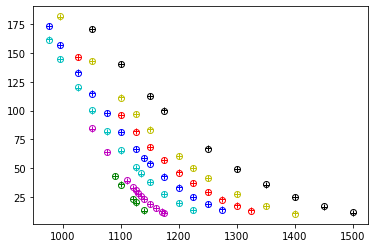

In [28]:
model_value=CGMYCIR_calculate_model_values(opt)
model_value=model_value.reshape([len(model_value),1])
model_value=pd.DataFrame(model_value)


plt.plot(options1['strike'], options1['price'], 'go', fillstyle='none', label='cena rynkowa')
plt.plot(options1['strike'], model_value.iloc[0:5], 'g+', fillstyle='none', label='cena rynkowa')

plt.plot(options2['strike'], options2['price'], 'mo', fillstyle='none', label='cena rynkowa')
plt.plot(options2['strike'], model_value.iloc[5:17], 'm+', fillstyle='none', label='cena rynkowa')

plt.plot(options3['strike'], options3['price'], 'co', fillstyle='none', label='cena rynkowa')
plt.plot(options3['strike'], model_value.iloc[17:29], 'c+', fillstyle='none', label='cena rynkowa')


plt.plot(options4['strike'], options4['price'], 'bo', fillstyle='none', label='cena rynkowa')
plt.plot(options4['strike'], model_value.iloc[29:43], 'b+', fillstyle='none', label='cena rynkowa')

plt.plot(options5['strike'], options5['price'], 'ro', fillstyle='none', label='cena rynkowa')
plt.plot(options5['strike'], model_value.iloc[43:54], 'r+', fillstyle='none', label='cena rynkowa')

plt.plot(options6['strike'], options6['price'], 'yo', fillstyle='none', label='cena rynkowa')
plt.plot(options6['strike'], model_value.iloc[54:65], 'y+', fillstyle='none', label='cena rynkowa')

plt.plot(options7['strike'], options7['price'], 'ko', fillstyle='none', label='cena rynkowa')
plt.plot(options7['strike'], model_value.iloc[65:], 'k+', fillstyle='none', label='cena rynkowa')

plt.savefig("CGMY-CIR_calibration",dpi=400)